# Hurricane Data Processing

In [150]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm 
from math import radians, sin, cos, sqrt, atan2

### Load and Clean Data

In [151]:
raw1 = pd.read_csv("HURDAT-2.txt", header=None, names=["DATE", "TIME_UTC", "POINT_TYPE", "STATUS", 
                                                      "LATITUDE", "LONGITUDE", "WINDSPEED_KT", "PRESSURE_MB", 
                                                      "NE_34KT", "SE_34KT", "NW_34_KT", "SW_34_KT",
                                                      "NE_50KT", "SE_50KT", "NW_50_KT", "SW_50_KT",
                                                      "NE_64KT", "SE_64KT", "NW_64_KT", "SW_64_KT", "RAD_MAX_WIND"], 
                  delim_whitespace=False)
raw2 = pd.read_csv("HURDAT-3.txt", header=None, names=["DATE", "TIME_UTC", "POINT_TYPE", "STATUS", 
                                                      "LATITUDE", "LONGITUDE", "WINDSPEED_KT", "PRESSURE_MB", 
                                                      "NE_34KT", "SE_34KT", "NW_34_KT", "SW_34_KT",
                                                      "NE_50KT", "SE_50KT", "NW_50_KT", "SW_50_KT",
                                                      "NE_64KT", "SE_64KT", "NW_64_KT", "SW_64_KT", "RAD_MAX_WIND"], 
                  delim_whitespace=False)
raw3 = pd.read_csv("HURDAT-4.txt", header=None, names=["DATE", "TIME_UTC", "POINT_TYPE", "STATUS", 
                                                      "LATITUDE", "LONGITUDE", "WINDSPEED_KT", "PRESSURE_MB", 
                                                      "NE_34KT", "SE_34KT", "NW_34_KT", "SW_34_KT",
                                                      "NE_50KT", "SE_50KT", "NW_50_KT", "SW_50_KT",
                                                      "NE_64KT", "SE_64KT", "NW_64_KT", "SW_64_KT", "RAD_MAX_WIND"], 
                  delim_whitespace=False)

raw['HID'] = raw['DATE'].where(raw['DATE'].str.contains("AL|EP|CP")).fillna(method='ffill')
raw['HNAME'] = raw['TIME_UTC'].where(raw['DATE'].str.contains("AL|EP|CP")).fillna(method='ffill')

panel = raw[~raw['DATE'].str.contains("AL|EP|CP")]

panel.reset_index(drop=True, inplace=True)

panel['LATITUDE'] = panel['LATITUDE'].str.strip()
panel['LONGITUDE'] = panel['LONGITUDE'].str.strip()

panel['LATITUDE'] = panel['LATITUDE'].apply(lambda x: "-" + x if "S" in x else x)
panel['LONGITUDE'] = panel['LONGITUDE'].apply(lambda x: "-" + x if "W" in x else x)

panel['LATITUDE'] = panel['LATITUDE'].str.replace("N", "")
panel['LATITUDE'] = panel['LATITUDE'].str.replace("S", "")
panel['LATITUDE'] = panel['LATITUDE'].astype(float)

panel['LONGITUDE'] = panel['LONGITUDE'].str.replace("E", "")
panel['LONGITUDE'] = panel['LONGITUDE'].str.replace("W", "")
panel['LONGITUDE'] = panel['LONGITUDE'].replace('--0.0', '0.0')
panel['LONGITUDE'] = panel['LONGITUDE'].astype(float)

panel['STATUS'] = panel['STATUS'].str.strip()
panel['POINT_TYPE'] = panel['POINT_TYPE'].str.strip()


panel.to_csv("Hurricane_Panel_Data.csv", index=False)

<ipython-input-151-63ad9e56625f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel['LATITUDE'] = panel['LATITUDE'].str.strip()
<ipython-input-151-63ad9e56625f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel['LONGITUDE'] = panel['LONGITUDE'].str.strip()
<ipython-input-151-63ad9e56625f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [152]:
hurricane_data = pd.read_csv("Hurricane_Panel_Data.csv")
hurricane_data = hurricane_data.replace(-999, np.nan)

In [153]:
print(hurricane_data)

           DATE  TIME_UTC POINT_TYPE STATUS  LATITUDE  LONGITUDE  \
0      19490611         0        NaN     TS      20.2     -106.3   
1      19490611       600        NaN     TS      20.2     -106.4   
2      19490611      1200        NaN     TS      20.2     -106.7   
3      19490611      1800        NaN     TS      20.3     -107.7   
4      19490612         0        NaN     TS      20.4     -108.6   
...         ...       ...        ...    ...       ...        ...   
31175  20231126      1200        NaN     LO      14.4     -123.7   
31176  20231126      1800        NaN     LO      14.3     -124.0   
31177  20231127         0        NaN     LO      14.1     -124.4   
31178  20231127       600        NaN     LO      13.8     -124.7   
31179  20231127      1200        NaN     LO      13.7     -125.0   

       WINDSPEED_KT  PRESSURE_MB  NE_34KT  SE_34KT  ...  SE_50KT  NW_50_KT  \
0              45.0          NaN      NaN      NaN  ...      NaN       NaN   
1              45.0        

### Checking if latitude and longitude are acceptable

In [154]:
for index, row in hurricane_data.iterrows():
    if row['LATITUDE'] < -90 or row['LATITUDE'] > 90:
        hurricane_data.at[index, 'LATITUDE'] = hurricane_data.at[index - 1, 'LATITUDE']
    
    if row['LONGITUDE'] < -180 or row['LONGITUDE'] > 180:
        hurricane_data.at[index, 'LONGITUDE'] = hurricane_data.at[index - 1, 'LONGITUDE']

### Filling in NaN Pressure Values

In [155]:

valid_pressure = hurricane_data.dropna(subset=['PRESSURE_MB'])

X = valid_pressure[['LATITUDE', 'LONGITUDE', 'WINDSPEED_KT']]
X['STATUS_HU'] = (valid_pressure['STATUS'] == 'HU').astype(int)
X['STATUS_TS_SS'] = ((valid_pressure['STATUS'] == 'TS') | (valid_pressure['STATUS'] == 'SS')).astype(int)
X = sm.add_constant(X)
y = valid_pressure['PRESSURE_MB']

pressure_model = sm.OLS(y, X).fit()

print(pressure_model.summary())

                            OLS Regression Results                            
Dep. Variable:            PRESSURE_MB   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 8.514e+04
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        02:27:22   Log-Likelihood:                -49592.
No. Observations:               18386   AIC:                         9.920e+04
Df Residuals:                   18380   BIC:                         9.924e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1025.0357      0.154   6652.882   

<ipython-input-155-666887ad8fe2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['STATUS_HU'] = (valid_pressure['STATUS'] == 'HU').astype(int)
<ipython-input-155-666887ad8fe2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['STATUS_TS_SS'] = ((valid_pressure['STATUS'] == 'TS') | (valid_pressure['STATUS'] == 'SS')).astype(int)


In [156]:
missing_pressure = hurricane_data[hurricane_data['PRESSURE_MB'].isnull()]

X_missing = missing_pressure[['LATITUDE', 'LONGITUDE', 'WINDSPEED_KT']]
X_missing['STATUS_HU'] = (missing_pressure['STATUS'] == 'HU').astype(int)
X_missing['STATUS_TS_SS'] = ((missing_pressure['STATUS'] == 'TS') | (missing_pressure['STATUS'] == 'SS')).astype(int)
X_missing = sm.add_constant(X_missing)

predicted_pressure = pressure_model.predict(X_missing)

hurricane_data.loc[hurricane_data['PRESSURE_MB'].isnull(), 'PRESSURE_MB'] = np.round(predicted_pressure, 1)

<ipython-input-156-39d8e6455bca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing['STATUS_HU'] = (missing_pressure['STATUS'] == 'HU').astype(int)
<ipython-input-156-39d8e6455bca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing['STATUS_TS_SS'] = ((missing_pressure['STATUS'] == 'TS') | (missing_pressure['STATUS'] == 'SS')).astype(int)


### Re-group STATUS variable

In [157]:
status_mapping = {
    'TD': 'TS',
    'TS': 'TS',
    'HU': 'HU',
    'EX': 'HU',
    'SD': 'SS',
    'SS': 'SS',
    'LO': 'LO',
    'DB': 'LO'
}
hurricane_data['STATUS'] = hurricane_data['STATUS'].replace(status_mapping)

### Adding Hurricane Categories

Based on Saffir-Simpson Hurricane Scale: https://www.weather.gov/mfl/saffirsimpson

Category 1: 64-82 kt

Category 2: 83-95 kt

Category 3: 96-112 kt

Category 4: 113-136 kt

Category 5: 137 kt or higher

*Note that there is no category for less than 64 kt so I have added 'Category 0' for this.

In [158]:
hurricane_data['CATEGORY'] = pd.qcut(hurricane_data['WINDSPEED_KT'], q=8, labels=False)

### Computing Speed Before Landfall

In [159]:

categories = ['Category 5', 'Category 4', 'Category 3', 'Category 2', 'Category 1', 'Category 0']
speeds = {}
landfall_factors = {}
average_no_landfall = {}
for category in categories:
    speeds[category] = {}
    category_storms = hurricane_data[hurricane_data['CATEGORY'] == category]
    landfall_storms = category_storms[category_storms['POINT_TYPE'].str.contains('L', na=False)]

    average_no_landfall[category] = len(landfall_storms)/len(landfall_storms['HID'].unique())

    average_speeds = []
    stopping_speeds = []

    for hid in landfall_storms['HID'].unique():
        storm_data = category_storms[category_storms['HID'] == hid].reset_index(drop=True)
        landfall_index = storm_data[storm_data['POINT_TYPE'].str.contains('L', na=False)].index[0]

        start_index = max(0, landfall_index - 5)
        end_index = landfall_index
        relevant_data = storm_data.iloc[start_index:end_index+1]

        if len(relevant_data) < 4:
            continue

        # Computing the speed leading up to landfall
        start_lat, start_lon = relevant_data.iloc[0]['LATITUDE'], relevant_data.iloc[0]['LONGITUDE']
        end_lat, end_lon = relevant_data.iloc[-2]['LATITUDE'], relevant_data.iloc[-2]['LONGITUDE']
        distance = np.sqrt((end_lat - start_lat)**2 + (end_lon - start_lon)**2)

        time_diff = (relevant_data.iloc[-2]['DATE'] - relevant_data.iloc[0]['DATE']) * 2400 + (relevant_data.iloc[-2]['TIME_UTC'] - relevant_data.iloc[0]['TIME_UTC'])
        average_speed = distance / time_diff
        average_speeds.append(average_speed)

        # Computing speed at landfall
        start_lat, start_lon = relevant_data.iloc[-2]['LATITUDE'], relevant_data.iloc[-2]['LONGITUDE']
        end_lat, end_lon = relevant_data.iloc[-1]['LATITUDE'], relevant_data.iloc[-1]['LONGITUDE']
        distance = np.sqrt((end_lat - start_lat)**2 + (end_lon - start_lon)**2)

        time_diff = (relevant_data.iloc[-1]['DATE'] - relevant_data.iloc[-2]['DATE']) * 2400 + (relevant_data.iloc[-1]['TIME_UTC'] - relevant_data.iloc[-2]['TIME_UTC'])
        stopping_speed = distance / time_diff
        stopping_speeds.append(stopping_speed)

    speeds[category]['Open Ocean'] = np.round(np.mean(average_speeds), 5)
    speeds[category]['At Landfall'] = np.round(np.mean(stopping_speeds), 5)
    landfall_factors[category] = np.mean(stopping_speeds)/np.mean(average_speeds)
    print(category)
    print(speeds[category])

Category 5
{'Open Ocean': nan, 'At Landfall': nan}
Category 4
{'Open Ocean': 0.00062, 'At Landfall': 0.00071}
Category 3
{'Open Ocean': 0.00136, 'At Landfall': 0.00205}
Category 2
{'Open Ocean': 0.00127, 'At Landfall': 0.00213}
Category 1
{'Open Ocean': 0.00168, 'At Landfall': 0.00235}
Category 0
{'Open Ocean': 0.00136, 'At Landfall': 0.00185}


/opt/python/envs/default/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python/envs/default/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [160]:
average_no_landfall

{'Category 5': 1.0,
 'Category 4': 1.0,
 'Category 3': 1.0,
 'Category 2': 1.0625,
 'Category 1': 1.1818181818181819,
 'Category 0': 1.208955223880597}

In [161]:
landfall_factors

{'Category 5': nan,
 'Category 4': 1.149391542265376,
 'Category 3': 1.5105069448552642,
 'Category 2': 1.6792188134798443,
 'Category 1': 1.4002249227250765,
 'Category 0': 1.359729652403157}

### Adding indicator if the storm makes future landfall at hurricane status

In [162]:
hurricane_data['HU_LANDFALL'] = 0
for hid, group in hurricane_data.groupby('HID'):
    storm_data = group.copy()
    
    landfall_indices = storm_data[storm_data['POINT_TYPE'] == 'L'].index
    for index, row in storm_data.iterrows():
        hu_landfall = 0
        future_landfall_indices = landfall_indices[landfall_indices > index]
        
        if len(future_landfall_indices) == 0:
            # If there are no future landfall
            hu_landfall = 0
        else:
            future_landfall_rows = storm_data.loc[future_landfall_indices]
            if any(future_landfall_rows['STATUS'] == 'HU'):
                # If any future landfall is HU
                hu_landfall = 1
            else:
                hu_landfall = 0

        hurricane_data.at[index, 'HU_LANDFALL'] = hu_landfall

In [163]:
columns = ['DATE', 'TIME_UTC', 'POINT_TYPE', 'STATUS', 'LATITUDE', 'LONGITUDE', 'HU_LANDFALL', 'HID', 'HNAME', 'WINDSPEED_KT', 'PRESSURE_MB', 'CATEGORY', 'NE_34KT', 'SE_34KT', 'NW_34_KT', 'SW_34_KT', 'NE_50KT', 'SE_50KT', 'NW_50_KT', 'SW_50_KT', 'NE_64KT','SE_64KT', 'NW_64_KT', 'SW_64_KT', 'RAD_MAX_WIND']
hurricane_data = hurricane_data[columns]

In [164]:
hurricane_data

DATE 
 TIME_UTC 
 POINT_TYPE 
 STATUS 
 LATITUDE 
 LONGITUDE 
 HU_LANDFALL 
 HID 
 HNAME 
 WINDSPEED_KT 
 ... 
 SW_34_KT 
 NE_50KT 
 SE_50KT 
 NW_50_KT 
 SW_50_KT 
 NE_64KT 
 SE_64KT 
 NW_64_KT 
 SW_64_KT 
 RAD_MAX_WIND 
 
 
 
 
 0 
 19490611 
 0 
 NaN 
 TS 
 20.2 
 -106.3 
 0 
 EP011949 
 UNNAMED 
 45.0 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 1 
 19490611 
 600 
 NaN 
 TS 
 20.2 
 -106.4 
 0 
 EP011949 
 UNNAMED 
 45.0 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 2 
 19490611 
 1200 
 NaN 
 TS 
 20.2 
 -106.7 
 0 
 EP011949 
 UNNAMED 
 45.0 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 3 
 19490611 
 1800 
 NaN 
 TS 
 20.3 
 -107.7 
 0 
 EP011949 
 UNNAMED 
 45.0 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 4 
 19490612 
 0 
 NaN 
 TS 
 20.4 
 -108.6 
 0 
 EP011949 
 UNNAMED 
 45.0 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 31175 
 20231126 
 1200 
 NaN 
 LO 
 14.4 
 -123.7 
 0 
 EP202023 
 RAMON 
 30.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 20.0 
 
 
 31176 
 20231126 
 1800 
 NaN 
 LO 
 14.3 
 -124.0 
 0 
 EP202023 
 RAMON 
 25.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 20.0 
 
 
 31177 
 20231127 
 0 
 NaN 
 LO 
 14.1 
 -124.4 
 0 
 EP202023 
 RAMON 
 25.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 20.0 
 
 
 31178 
 20231127 
 600 
 NaN 
 LO 
 13.8 
 -124.7 
 0 
 EP202023 
 RAMON 
 25.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 20.0 
 
 
 31179 
 20231127 
 1200 
 NaN 
 LO 
 13.7 
 -125.0 
 0 
 EP202023 
 RAMON 
 25.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 20.0 
 
 
 
 31180 rows × 25 columns

### Adding distance to next landfall

In [165]:

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface using the Haversine formula.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371000 * c  # Earth radius in meters
    return distance

hurricane_data['DIST_TO_LANDFALL'] = -1

# For each storm
for hid, group in hurricane_data.groupby('HID'):
    storm_data = group.copy()
    
    landfall_indices = storm_data[storm_data['POINT_TYPE'] == 'L'].index # Find all landfall indices
    
    for index, row in storm_data.iterrows():
        next_landfall_index = landfall_indices[landfall_indices > index].min() # Find index of the next landfall
        if row['POINT_TYPE'] == 'L': # If our row is a landfall distance is 0
            dist_to_landfall = 0
        elif pd.isnull(next_landfall_index): # If there is no next landfall, default to -1
            dist_to_landfall = -1
        else:                           # Compute distance to next landfall
            next_landfall_row = storm_data.loc[next_landfall_index]
            dist_to_landfall = haversine(row['LATITUDE'], row['LONGITUDE'],
                                          next_landfall_row['LATITUDE'], next_landfall_row['LONGITUDE'])
        if dist_to_landfall == -1:
            hurricane_data.at[index, 'DIST_TO_LANDFALL'] = -999
        else:
            hurricane_data.at[index, 'DIST_TO_LANDFALL'] = np.round(dist_to_landfall/1000, 2)

### Adding distance to nearest coastline

In [166]:
# Set filepath
coastline_fp = "Coastline Files/ne_10m_coastline.shp"

# Read file using gpd.read_file()
coastline_data = gpd.read_file(coastline_fp)

In [167]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data: 50.1 MiB
                            _5: 28.3 MiB
                      aug_data: 28.3 MiB
                 valid_lat_lon: 25.2 MiB
                            _4: 24.9 MiB
                         data1: 24.9 MiB
                           _87: 24.8 MiB
            hurricane_data_gdf: 24.8 MiB
                         data2: 24.8 MiB
                           _99: 24.8 MiB


<Axes: >

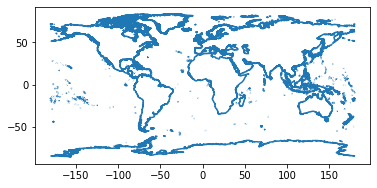

In [168]:
coastline_data.plot()

In [169]:


projected_crs = "EPSG:3395"  # World Mercator

# Convert hurricane_data to GeoDataFrame and re-project to a projected CRS
hurricane_data_geometry = [Point(xy) for xy in zip(hurricane_data['LONGITUDE'], hurricane_data['LATITUDE'])]
hurricane_data_gdf = gpd.GeoDataFrame(hurricane_data, geometry=hurricane_data_geometry, crs="EPSG:4326")
hurricane_data_gdf = hurricane_data_gdf.to_crs(projected_crs)

# Convert coastline_data to the same projected CRS
coastline_data_projected = coastline_data.to_crs(projected_crs)

# Compute distance to nearest coastline
nearest_coastline_distances = []
for point in tqdm(hurricane_data_gdf.geometry, desc="Computing distances"):
    nearest_distance = coastline_data_projected.distance(point).min()
    nearest_coastline_distances.append(nearest_distance/1000)

# Add the distances to hurricane_data as a new column
hurricane_data['DIST_TO_COASTLINE'] = np.round(nearest_coastline_distances, 2)

Computing distances:   0%|          | 0/31180 [00:00<?, ?it/s]/opt/python/envs/default/lib/python3.8/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
Computing distances: 100%|██████████| 31180/31180 [04:11<00:00, 124.01it/s]


In [170]:

columns = ['DATE', 'TIME_UTC', 'POINT_TYPE', 'STATUS', 'LATITUDE', 'LONGITUDE', 'DIST_TO_COASTLINE', 'HU_LANDFALL', 'HID', 'HNAME', 'WINDSPEED_KT', 'PRESSURE_MB', 'CATEGORY', 'NE_34KT', 'SE_34KT', 'NW_34_KT', 'SW_34_KT', 'NE_50KT', 'SE_50KT', 'NW_50_KT', 'SW_50_KT', 'NE_64KT','SE_64KT', 'NW_64_KT', 'SW_64_KT', 'RAD_MAX_WIND']
hurricane_data = hurricane_data[columns]

### Adding indicator for US East coast storm

In [171]:
hurricane_data['US_EAST_STORM'] = 0

us_east = (hurricane_data['LONGITUDE'].between(-100, -60)) & (hurricane_data['LATITUDE'].between(15, 40))

hurricane_data.loc[us_east, 'US_EAST_STORM'] = 1

In [172]:
hurricane_data.to_csv('Hurricane_Data_Final_3.csv', index=False)

In [173]:
hurricane_data = pd.read_csv('Hurricane_Data_Final_3.csv')

In [125]:

# Load the data
augmented_hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')

# Create 8 equal-sized bins for the WINDSPEED_KT column and label them from 0 to 7
augmented_hurricane_data['CATEGORY'] = pd.qcut(augmented_hurricane_data['WINDSPEED_KT'], q=8, labels=False)
augmented_hurricane_data['WINDSPEED_KT'] = augmented_hurricane_data['WINDSPEED_KT'].apply(lambda x: max(x, 0))

# Save the modified data to a new CSV file if needed
augmented_hurricane_data.to_csv('Augmented_Hurricane_Data.csv', index=False)
augmented_hurricane_data.to_csv('Hurricane_Data_Final.csv', index=False)


# Display the first few rows of the modified DataFrame
print(augmented_hurricane_data.head())

         DATE  TIME_UTC POINT_TYPE STATUS  LATITUDE  LONGITUDE  \
0  1851-06-25         0        NaN     HU      28.0      -94.8   
1  1851-06-25       600        NaN     HU      28.0      -95.4   
2  1851-06-25      1200        NaN     HU      28.0      -96.0   
3  1851-06-25      1800        NaN     HU      28.1      -96.5   
4  1851-06-25      2100          L     HU      28.2      -96.8   

   DIST_TO_COASTLINE  DIST_TO_LANDFALL  HU_LANDFALL       HID  ... SE_50KT  \
0             128.29            197.43            1  AL011851  ...     NaN   
1              94.77            139.11            1  AL011851  ...     NaN   
2              62.12             81.56            1  AL011851  ...     NaN   
3              20.26             31.44            1  AL011851  ...     NaN   
4               0.98              0.00            0  AL011851  ...     NaN   

   NW_50_KT  SW_50_KT  NE_64KT  SE_64KT  NW_64_KT  SW_64_KT  RAD_MAX_WIND  \
0       NaN       NaN      NaN      NaN       NaN       N

In [118]:
augmented_hurricane_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53976 entries, 0 to 53975
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               53976 non-null  object 
 1   TIME_UTC           53976 non-null  int64  
 2   POINT_TYPE         1209 non-null   object 
 3   STATUS             53976 non-null  object 
 4   LATITUDE           53976 non-null  float64
 5   LONGITUDE          53976 non-null  float64
 6   DIST_TO_COASTLINE  53976 non-null  float64
 7   DIST_TO_LANDFALL   53976 non-null  float64
 8   HU_LANDFALL        53976 non-null  int64  
 9   HID                53976 non-null  object 
 10  HNAME              53976 non-null  object 
 11  WINDSPEED_KT       53976 non-null  float64
 12  PRESSURE_MB        53976 non-null  float64
 13  CATEGORY           53976 non-null  int64  
 14  NE_34KT            10174 non-null  float64
 15  SE_34KT            10174 non-null  float64
 16  NW_34_KT           101

# Clustering Hurricane Paths

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from datetime import datetime
from sklearn.neighbors import NearestCentroid

In [59]:
hurricane_data = pd.read_csv('Extra Hurricane Data/Hurricane_Data_Final_Final.csv')
print(len(hurricane_data))
hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')

139905


In [60]:
hurricane_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53976 entries, 0 to 53975
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               53976 non-null  object 
 1   TIME_UTC           53976 non-null  int64  
 2   POINT_TYPE         1209 non-null   object 
 3   STATUS             53976 non-null  object 
 4   LATITUDE           53976 non-null  float64
 5   LONGITUDE          53976 non-null  float64
 6   DIST_TO_COASTLINE  53976 non-null  float64
 7   DIST_TO_LANDFALL   53976 non-null  float64
 8   HU_LANDFALL        53976 non-null  int64  
 9   HID                53976 non-null  object 
 10  HNAME              53976 non-null  object 
 11  WINDSPEED_KT       53976 non-null  float64
 12  PRESSURE_MB        53976 non-null  float64
 13  CATEGORY           53976 non-null  int64  
 14  NE_34KT            10174 non-null  float64
 15  SE_34KT            10174 non-null  float64
 16  NW_34_KT           101

### Plotting all the storms

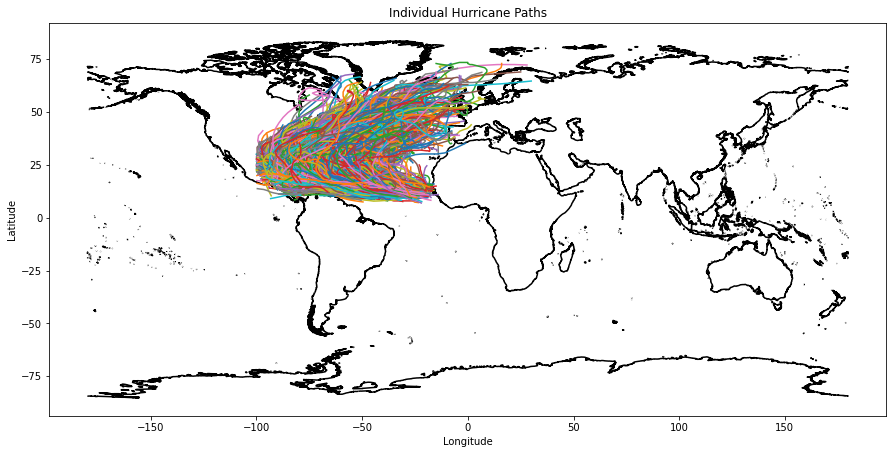

In [63]:
valid_lat_lon = hurricane_data[(hurricane_data['LATITUDE'].between(-70, 75)) & 
                               (hurricane_data['LONGITUDE'].between(-100, 30))]

coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

unique_storms = valid_lat_lon['HID'].unique()

fig, ax = plt.subplots(figsize=(15, 10))
coastline.plot(ax=ax, color='black')
for storm_id in unique_storms:
    storm_data = valid_lat_lon[valid_lat_lon['HID'] == storm_id]
    plt.plot(storm_data['LONGITUDE'], storm_data['LATITUDE'], linestyle='-')

plt.title('Individual Hurricane Paths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

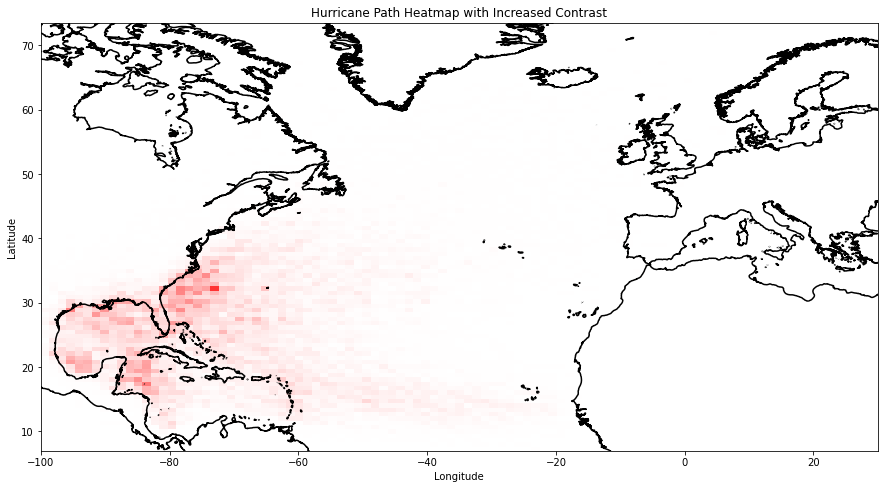

In [64]:
colors = [(1, 1, 1, 0), (1, 0.2, 0.2, 0.3), (1, 0, 0, 1)]
n_bins = 100
cmap_name = 'hurricane_heatmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

lon_min, lon_max = valid_lat_lon['LONGITUDE'].min(), valid_lat_lon['LONGITUDE'].max()
lat_min, lat_max = valid_lat_lon['LATITUDE'].min(), valid_lat_lon['LATITUDE'].max()

lon_bins = np.linspace(lon_min, lon_max, 100)
lat_bins = np.linspace(lat_min, lat_max, 100)

heatmap, xedges, yedges = np.histogram2d(valid_lat_lon['LONGITUDE'], valid_lat_lon['LATITUDE'], bins=[lon_bins, lat_bins])

fig, ax = plt.subplots(figsize=(15, 10))
coastline.plot(ax=ax, color='black')
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm, alpha=0.8)

plt.title('Hurricane Path Heatmap with Increased Contrast')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [65]:
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'], format='%Y%m%d')

current_year = datetime.now().year



florida_lat_range = [15, 35]
florida_lon_range = [-90, -50]

hurricane_data['florida_mask'] = hurricane_data.apply(
    lambda row: 1 if (florida_lat_range[0] <= row['LATITUDE'] <= florida_lat_range[1]) and 
                     (florida_lon_range[0] <= row['LONGITUDE'] <= florida_lon_range[1]) else 0, axis= 1
)
florida_data = hurricane_data[hurricane_data['florida_mask'] == 1]
florida_hids = florida_data['HID'].unique()

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)

florida_data_trimmed = florida_data[(florida_data['LATITUDE'].between(*greater_lat_range)) & 
                             (florida_data['LONGITUDE'].between(*greater_lon_range))]

ValueError: ValueError: time data '1851-06-25' does not match format '%Y%m%d' (match)

In [165]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

fig, ax = plt.subplots(figsize=(15, 10))
for storm_id in florida_hids:
    storm_data = florida_data[florida_data['HID'] == storm_id]
    plt.plot(storm_data['LONGITUDE'], storm_data['LATITUDE'], linestyle='-')

coastline.plot(ax=ax, color='black')

plt.title('Individual Hurricane Paths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)
plt.show()

KeyboardInterrupt: KeyboardInterrupt: 

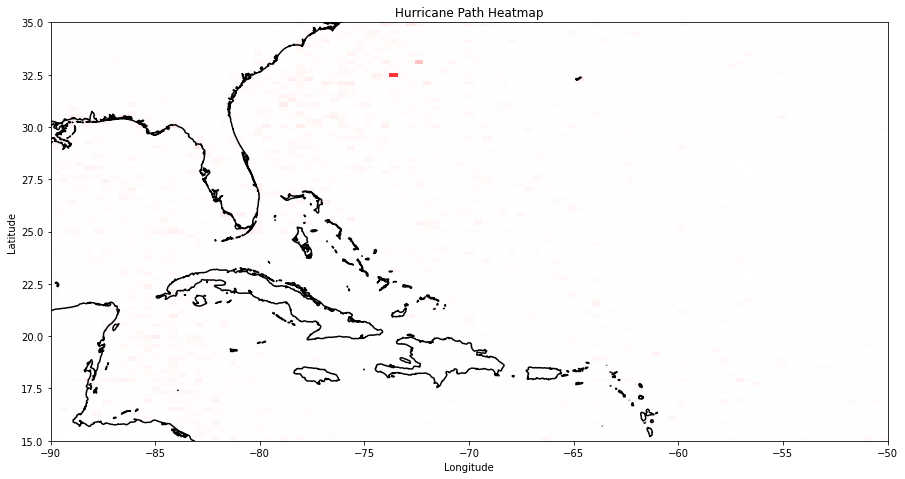

In [87]:
colors = [(1, 1, 1, 0), (1, 0.2, 0.2, 0.3), (1, 0, 0, 1)]
n_bins = 100 
cmap_name = 'hurricane_heatmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Create a grid for the heatmap
lon_min, lon_max = florida_data_trimmed['LONGITUDE'].min(), florida_data_trimmed['LONGITUDE'].max()
lat_min, lat_max = florida_data_trimmed['LATITUDE'].min(), florida_data_trimmed['LATITUDE'].max()

lon_bins = np.linspace(lon_min, lon_max, 100)
lat_bins = np.linspace(lat_min, lat_max, 100)

heatmap, xedges, yedges = np.histogram2d(florida_data_trimmed['LONGITUDE'], florida_data_trimmed['LATITUDE'], bins=[lon_bins, lat_bins])

fig, ax = plt.subplots(figsize=(15, 10))
coastline.plot(ax=ax, color='black')
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm, alpha=0.8) 

plt.title('Hurricane Path Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Clustering

In [48]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp38-cp38-linux_x86_64.whl size=582215 sha256=d2ae1bee915a11b8f564842ddf0de36763b5e87d2e341b481e255ab22fd945fc
  Stored in directory: /home/datalore/.cache/pip/wheels/e9/ac/30/c962f9d759dd68cb5482727c44441fdfb48040fdbe983857e8
Successfully built fastdtw

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import geopandas as gpd
import torch
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures

In [50]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

In [51]:

hurricane_data = pd.read_csv('Hurricane_Data_Final.csv')
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'], format='%Y-%m-%d')

florida_lat_range = (15, 35)
florida_lon_range = (-90, -50)

def is_mostly_in_florida(group):
    in_florida = group[(group['LATITUDE'].between(*florida_lat_range)) & 
                       (group['LONGITUDE'].between(*florida_lon_range))]
    return (len(in_florida) / len(group) >= 0.7) or len(in_florida) > 25

grouped = hurricane_data.groupby('HID')
florida_hids = grouped.filter(is_mostly_in_florida)['HID'].unique()

florida_data = hurricane_data[hurricane_data['HID'].isin(florida_hids)]

storm_data = florida_data

In [52]:
storms = storm_data.groupby('HID')
print(len(storms))

726


In [53]:
storms = storm_data.groupby('HID')

def preprocess_paths(storms, n_points=100):
    paths = []
    ids = []
    stripped_ids = []
    for hid, group in storms:
        group = group.sort_values(by='DATE')
        latitudes = group['LATITUDE'].values
        longitudes = group['LONGITUDE'].values
        
        if len(latitudes) < 2:
            continue
        
        lat_interp = interp1d(np.linspace(0, 1, len(latitudes)), latitudes, kind='linear')
        lon_interp = interp1d(np.linspace(0, 1, len(longitudes)), longitudes, kind='linear')
        new_path = np.array(list(zip(lat_interp(np.linspace(0, 1, n_points)), 
                                     lon_interp(np.linspace(0, 1, n_points)))))
        paths.append(new_path)
        ids.append(hid)
        
    return np.array(paths), ids

normalized_paths, storm_ids = preprocess_paths(storms)
print(len(normalized_paths))

714


### This cell takes a long time, load the csv below

In [126]:
n_paths = len(normalized_paths)
distances = np.zeros((n_paths, n_paths))

def compute_distance(i, j, normalized_paths):
    distance, _ = fastdtw(normalized_paths[i], normalized_paths[j], dist=euclidean)
    return i, j, distance

with ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for i in tqdm(range(n_paths), desc="Submitting tasks"):
        for j in range(i, n_paths):
            futures.append(executor.submit(compute_distance, i, j, normalized_paths))
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Computing distances"):
        i, j, distance = future.result()
        distances[i, j] = distance
        distances[j, i] = distance

Computing distances:   0%|          | 1042/350703 [00:06<40:31, 143.80it/s]Process ForkProcess-38:
Process ForkProcess-37:
Traceback (most recent call last):
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/python/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/python/lib/python3.8/multiprocessing/queues.py", line 97, in get
    res = self._recv_bytes()
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/python/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/python/lib/python3.8/multiprocessing/connection.py", line 421, in _recv_bytes
    return se

KeyboardInterrupt: KeyboardInterrupt: 

In [116]:
distances_df = pd.DataFrame(distances)

distances_df.to_csv('Clustering/distances_v2.csv', index=False)

NameError: NameError: name 'distances' is not defined

In [54]:
distances_df = pd.read_csv('Clustering/distances_v2.csv')
distances = distances_df.values

In [55]:
print(len(distances))

714


In [56]:
dbscan = DBSCAN(eps=400, min_samples=3, metric='precomputed')
labels = dbscan.fit_predict(distances)

num_noise = sum(labels == -1)
print(f'Number of noise points: {num_noise}')
print(f'Number of non-noise points: {len(labels) - num_noise}')

reduced_distances = distances[labels != -1][:, labels != -1]
reduced_paths = normalized_paths[labels != -1]
reduced_labels = labels[labels != -1]
reduced_hids = np.array(storm_ids)[labels != -1]
noise_hids = np.array(storm_ids)[labels == -1]

Number of noise points: 79
Number of non-noise points: 635


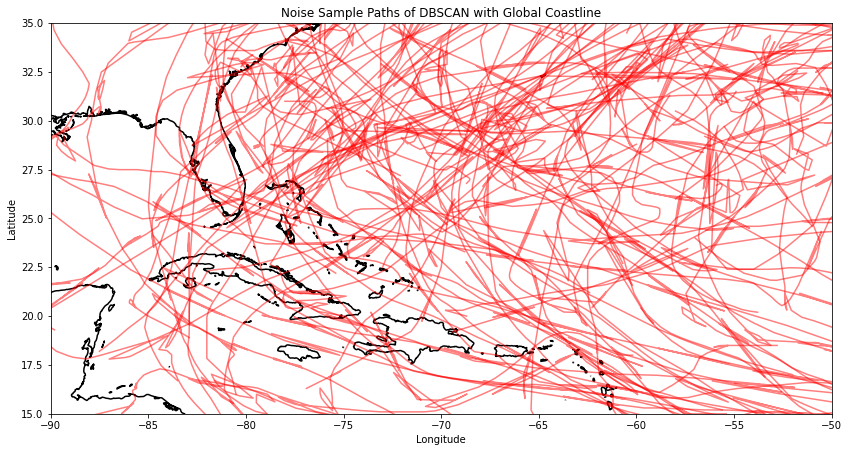

In [57]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline.plot(ax=ax, color='black')

for path in normalized_paths[labels == -1]:
    plt.plot(path[:, 1], path[:, 0], color='red', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Noise Sample Paths of DBSCAN with Global Coastline')

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

plt.show()

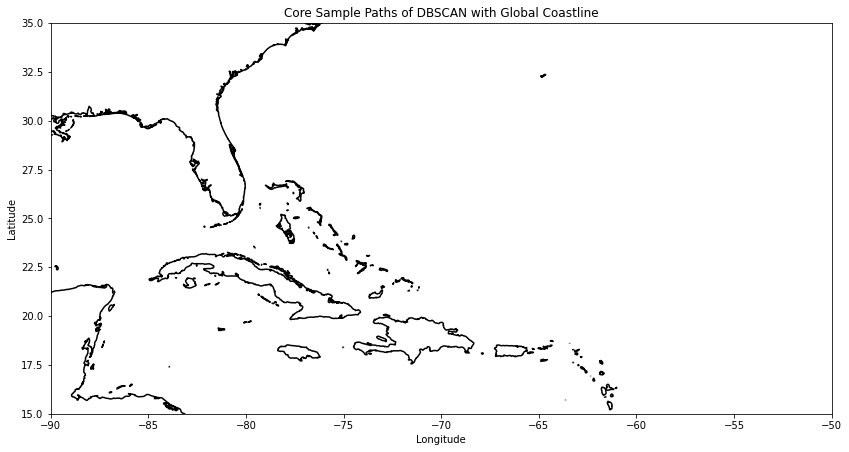

In [58]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline.plot(ax=ax, color='black')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for label in np.unique(reduced_labels):
    if label > 0:  
        cluster_paths = reduced_paths[reduced_labels == label]
        for path in cluster_paths:
            plt.plot(path[:, 1], path[:, 0], color=colors[label % len(colors)], alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Core Sample Paths of DBSCAN with Global Coastline')

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

plt.show()

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs

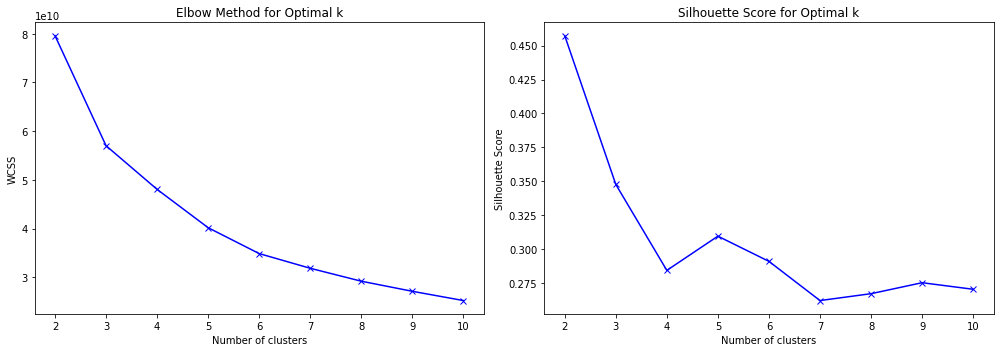

In [59]:
wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(reduced_distances)
    
    wcss.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(reduced_distances, clusters)
    silhouette_scores.append(silhouette_avg)
    
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

Silhouette Score: 0.45726612575273345


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


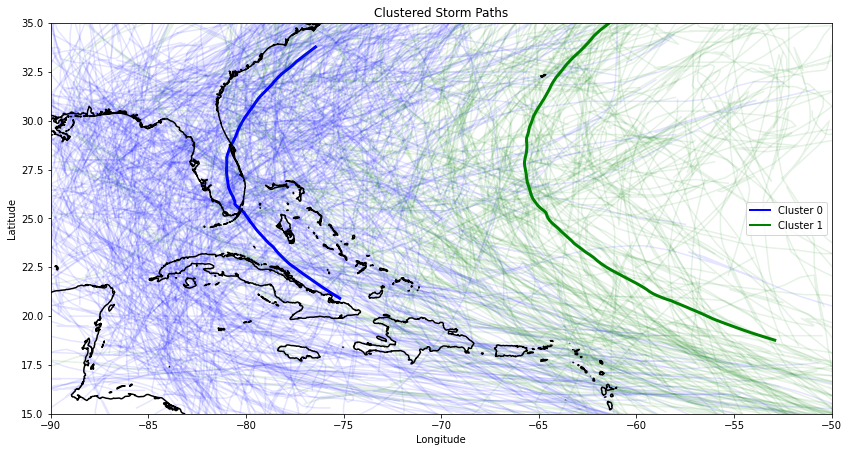

In [60]:
k = 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(reduced_distances)

silhouette_avg = silhouette_score(reduced_distances, clusters)
print(f'Silhouette Score: {silhouette_avg}')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

mean_paths = []
for cluster in range(k):
    cluster_paths = reduced_paths[clusters == cluster]
    mean_path = np.mean(cluster_paths, axis=0)
    mean_paths.append(mean_path)

plt.figure(figsize=(14, 10))

for cluster in range(k):
    cluster_paths = reduced_paths[clusters == cluster]
    for path in cluster_paths:
        plt.plot(path[:, 1], path[:, 0], color=colors[cluster % len(colors)], alpha=0.1)
    plt.plot(mean_paths[cluster][:, 1], mean_paths[cluster][:, 0], color=colors[cluster % len(colors)], linewidth=3, label=f'Mean Path Cluster {cluster}')
        
coastline.plot(ax=plt.gca(), color='black')

handles = [plt.Line2D([0], [0], color=colors[i % len(colors)], lw=2, label=f'Cluster {i}') for i in range(k)]
plt.legend(handles=handles)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Storm Paths')
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)
plt.show()

In [61]:
k = 2
kmeans = KMeans(n_clusters=k)
two_clusters = kmeans.fit_predict(reduced_distances)

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### After intital 2-clustering I will try to recluster the paths

In [62]:
subset1 = reduced_paths[two_clusters == 0]
subset1_hids = reduced_hids[two_clusters == 0]
subset2 = reduced_paths[two_clusters == 1]
subset2_hids = reduced_hids[two_clusters == 1]

print(len(subset1))
print(len(subset2))


def compute_distance(i, j, subset):
    distance, _ = fastdtw(subset[i], subset[j], dist=euclidean)
    return i, j, distance

def compute_distances_parallel(subset, desc):
    n_paths = len(subset)
    distances = np.zeros((n_paths, n_paths))

    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for i in range(n_paths):
            for j in range(i, n_paths):
                futures.append(executor.submit(compute_distance, i, j, subset))
        
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=desc):
            i, j, distance = future.result()
            distances[i, j] = distance
            distances[j, i] = distance

    return distances

distances1 = compute_distances_parallel(subset1, "Processing subset1")

distances2 = compute_distances_parallel(subset2, "Processing subset2")

print("Distances for subset1:")
print(distances1)
print("Distances for subset2:")
print(distances2)

423
212


Processing subset1:  13%|█▎        | 11674/89676 [01:45<11:30, 112.91it/s]Process ForkProcess-12:
Traceback (most recent call last):
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/python/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/python/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/python/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/opt/python/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Processing subset1:  13%|█▎        | 11682/89676 [01:45<11:45, 110.61it/s]


KeyboardInterrupt: KeyboardInterrupt: 

In [134]:
def elbow_and_silhouette(distances):
    wcss = []
    silhouette_scores = []
    K = range(2, 11)

    for k in K:
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit_predict(distances)

        wcss.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(distances, clusters)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(K, wcss, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')

    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')

    plt.tight_layout()
    plt.show()


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs

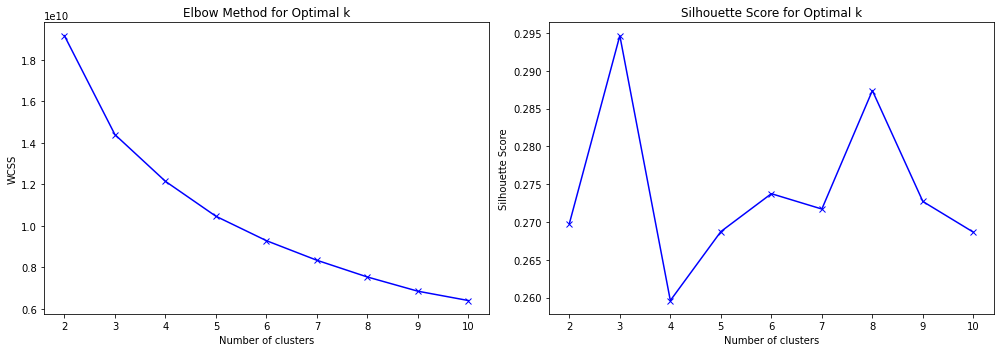

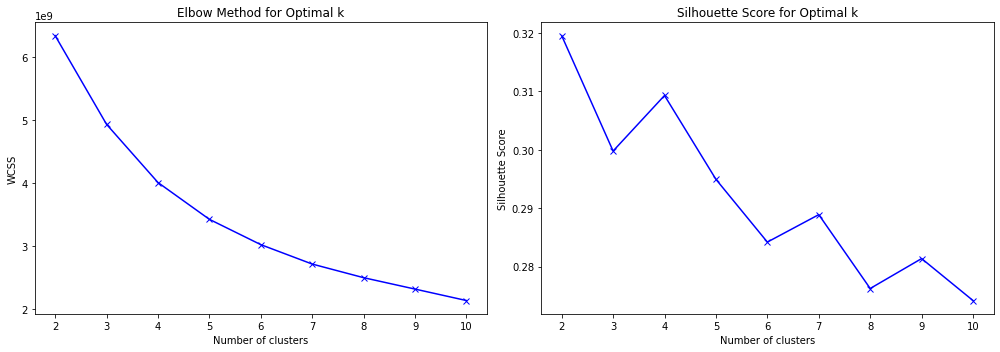

In [135]:
elbow_and_silhouette(distances1)
elbow_and_silhouette(distances2)

In [141]:
def cluster_and_plot(distances, paths, k, colors, title, ax):
    
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(distances)
    cluster_centroids = kmeans.cluster_centers_
    
    silhouette_avg = silhouette_score(distances, clusters)
    print(f'Silhouette Score: {silhouette_avg}')

    mean_paths = []
    for cluster in range(k):
        cluster_paths = paths[clusters == cluster]
        mean_path = np.mean(cluster_paths, axis=0)
        mean_paths.append(mean_path)
    
    for cluster in range(k):
        cluster_paths = paths[clusters == cluster]
        for path in cluster_paths:
            ax.plot(path[:, 1], path[:, 0], color=colors[cluster % len(colors)], alpha=0.1)
        ax.plot(mean_paths[cluster][:, 1], mean_paths[cluster][:, 0], color=colors[cluster % len(colors)], linewidth=3, label=f'Mean Path Cluster {cluster}')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()

    return clusters, mean_paths

Silhouette Score: 0.2764428782798069
Silhouette Score: 0.3195467682821186


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


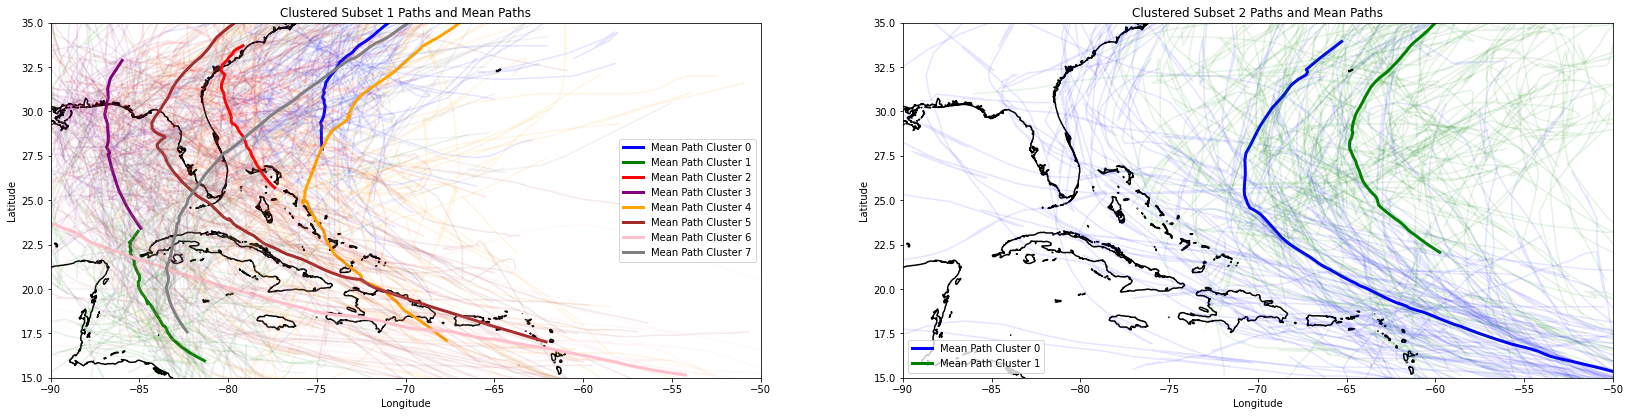

In [142]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

fig, axs = plt.subplots(1, 2, figsize=(28, 10))

coastline.plot(ax=axs[0], color='black')
coastline.plot(ax=axs[1], color='black')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

clusters1, cluster1_centroids = cluster_and_plot(distances1, subset1, k=8, colors=colors, title='Clustered Subset 1 Paths and Mean Paths', ax=axs[0])
clusters2, cluster2_centroids = cluster_and_plot(distances2, subset2, k=2, colors=colors, title='Clustered Subset 2 Paths and Mean Paths', ax=axs[1])

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
for ax in axs:
    ax.set_xlim(greater_lon_range)
    ax.set_ylim(greater_lat_range)

plt.show()

In [152]:
mean_path_subset1 = np.mean(subset1, axis=0)
mean_path_subset2 = np.mean(subset2, axis=0)
initial_centroids = [mean_path_subset1, mean_path_subset2]

def assign_noise_points(noise_paths, initial_centroids, subset_centroids):
    assigned_clusters = []
    for path in noise_paths:
        distances_to_centroids = []
        for centroid in initial_centroids:
            distances_to_centroids.append(fastdtw(path, centroid, dist=euclidean)[0])
        nearest_cluster = np.argmin(distances_to_centroids)
        distances_to_subset_centroids = []
        for centroid in subset_centroids[nearest_cluster]:
            distances_to_subset_centroids.append(fastdtw(path, centroid, dist=euclidean)[0])
        assigned_clusters.append(np.argmin(distances_to_subset_centroids) + nearest_cluster*8)
    return np.array(assigned_clusters)

subset_centroids = [cluster1_centroids, cluster2_centroids]

noise_paths = normalized_paths[labels == -1]
noise_clusters = assign_noise_points(noise_paths, initial_centroids, subset_centroids)

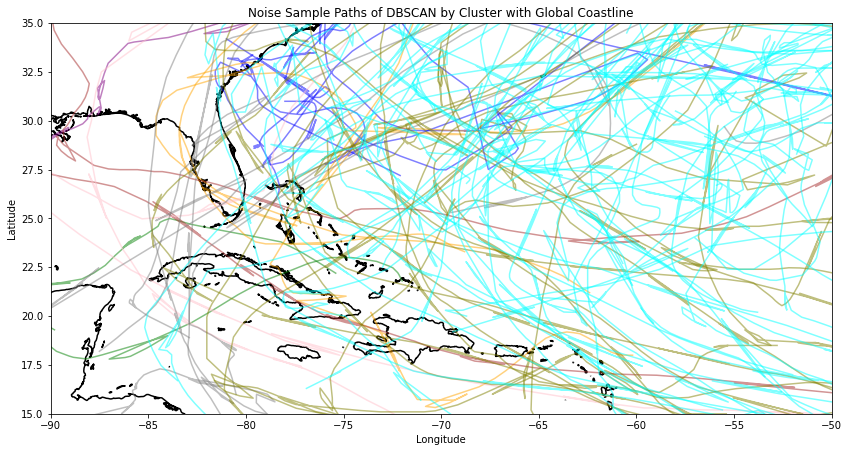

In [153]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline.plot(ax=ax, color='black')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, color in enumerate(colors):
    noise_paths_cluster = normalized_paths[np.isin(storm_ids, noise_hids[noise_clusters == i])]
    for path in noise_paths_cluster:
        plt.plot(path[:, 1], path[:, 0], color=color, alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Noise Sample Paths of DBSCAN by Cluster with Global Coastline')

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

plt.show()

In [154]:
count_paths_per_cluster1 = pd.Series(clusters1).value_counts().sort_index()
print("Number of paths per cluster in Subset 1:")
print(count_paths_per_cluster1)

count_paths_per_cluster2 = pd.Series(clusters2).value_counts().sort_index()
print("Number of paths per cluster in Subset 2:")
print(count_paths_per_cluster2)

Number of paths per cluster in Subset 1:
0    63
1    44
2    70
3    64
4    39
5    50
6    26
7    67
dtype: int64
Number of paths per cluster in Subset 2:
0     88
1    124
dtype: int64


### Augmenting the hurricane dataset with the cluster mappings

In [155]:
mapping1 = pd.DataFrame({'HID': subset1_hids, 'CLUSTER': clusters1})
mapping2 = pd.DataFrame({'HID': subset2_hids, 'CLUSTER': clusters2+8})
noise_mapping = pd.DataFrame({'HID': noise_hids, 'CLUSTER': noise_clusters})

cluster_mapping = pd.concat([mapping1, mapping2, noise_mapping], ignore_index=True)
print(cluster_mapping)

hurricane_data_augmented = hurricane_data.merge(cluster_mapping, on='HID', how='left')
hurricane_data_augmented['CLUSTER'].fillna(-1, inplace=True)

display(hurricane_data_augmented)

          HID  CLUSTER
0    AL011852        5
1    AL011860        3
2    AL011862        0
3    AL011867        2
4    AL011872        3
..        ...      ...
709  AL171936        8
710  AL192003        8
711  AL201984        9
712  AL212010        8
713  AL272020        9

[714 rows x 2 columns]


DATE 
 TIME_UTC 
 POINT_TYPE 
 STATUS 
 LATITUDE 
 LONGITUDE 
 DIST_TO_COASTLINE 
 DIST_TO_LANDFALL 
 HU_LANDFALL 
 HID 
 ... 
 SE_50KT 
 NW_50_KT 
 SW_50_KT 
 NE_64KT 
 SE_64KT 
 NW_64_KT 
 SW_64_KT 
 RAD_MAX_WIND 
 US_EAST_STORM 
 CLUSTER 
 
 
 
 
 0 
 1851-06-25 
 0 
 NaN 
 HU 
 28.0 
 -94.8 
 128.29 
 197.43 
 1 
 AL011851 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1 
 -1.0 
 
 
 1 
 1851-06-25 
 600 
 NaN 
 HU 
 28.0 
 -95.4 
 94.77 
 139.11 
 1 
 AL011851 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1 
 -1.0 
 
 
 2 
 1851-06-25 
 1200 
 NaN 
 HU 
 28.0 
 -96.0 
 62.12 
 81.56 
 1 
 AL011851 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1 
 -1.0 
 
 
 3 
 1851-06-25 
 1800 
 NaN 
 HU 
 28.1 
 -96.5 
 20.26 
 31.44 
 1 
 AL011851 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1 
 -1.0 
 
 
 4 
 1851-06-25 
 2100 
 L 
 HU 
 28.2 
 -96.8 
 0.98 
 0.00 
 0 
 AL011851 
 ... 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1 
 -1.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 53971 
 2022-11-10 
 1900 
 L 
 TS 
 29.2 
 -83.0 
 2.65 
 0.00 
 0 
 AL172022 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 70.0 
 1 
 5.0 
 
 
 53972 
 2022-11-11 
 0 
 L 
 TS 
 30.1 
 -84.0 
 1.04 
 0.00 
 0 
 AL172022 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 70.0 
 1 
 5.0 
 
 
 53973 
 2022-11-11 
 600 
 NaN 
 TS 
 31.2 
 -84.6 
 146.64 
 -999.00 
 0 
 AL172022 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 90.0 
 1 
 5.0 
 
 
 53974 
 2022-11-11 
 1200 
 NaN 
 TS 
 33.2 
 -84.6 
 390.30 
 -999.00 
 0 
 AL172022 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 250.0 
 1 
 5.0 
 
 
 53975 
 2022-11-11 
 1800 
 NaN 
 LO 
 35.4 
 -83.8 
 503.59 
 -999.00 
 0 
 AL172022 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 400.0 
 1 
 5.0 
 
 
 
 53976 rows × 29 columns

In [197]:
filtered_data = hurricane_data_augmented[hurricane_data_augmented['CLUSTER'] != -1]
len(filtered_data)

22853

### Validating that the augmentation worked as expected

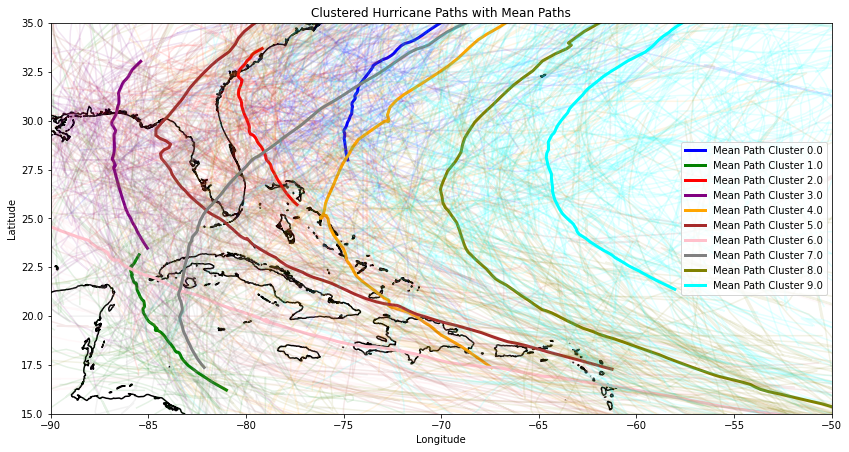

In [196]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

storms = filtered_data.groupby('HID')

def preprocess_paths_for_plotting(storms):
    paths = []
    clusters = []
    for hid, group in storms:
        group = group.sort_values(by='DATE')
        latitudes = group['LATITUDE'].values
        longitudes = group['LONGITUDE'].values
        cluster = group['CLUSTER'].iloc[0]
        
        if len(latitudes) < 2:
            continue
        
        paths.append(np.array(list(zip(latitudes, longitudes))))
        clusters.append(cluster)
        
    return paths, np.array(clusters)

paths, clusters = preprocess_paths_for_plotting(storms)

def interpolate_path(path, n_points=100):
    latitudes = path[:, 0]
    longitudes = path[:, 1]
    interp_lat = interp1d(np.linspace(0, 1, len(latitudes)), latitudes, kind='linear')
    interp_lon = interp1d(np.linspace(0, 1, len(longitudes)), longitudes, kind='linear')
    new_lat = interp_lat(np.linspace(0, 1, n_points))
    new_lon = interp_lon(np.linspace(0, 1, n_points))
    return np.column_stack((new_lat, new_lon))

def plot_paths_and_means(paths, clusters, colors, title, ax, n_points=100):
    unique_clusters = np.unique(clusters)
    mean_paths = []
    
    for cluster in unique_clusters:
        cluster_paths = [interpolate_path(path, n_points) for path, cl in zip(paths, clusters) if cl == cluster]
        mean_path = np.mean(cluster_paths, axis=0)
        mean_paths.append(mean_path)
        
        for path in cluster_paths:
            ax.plot(path[:, 1], path[:, 0], color=colors[int(cluster) % len(colors)], alpha=0.1)
        ax.plot(mean_path[:, 1], mean_path[:, 0], color=colors[int(cluster) % len(colors)], linewidth=3, label=f'Mean Path Cluster {cluster}')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline.plot(ax=ax, color='black')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

plot_paths_and_means(paths, clusters, colors, 'Clustered Hurricane Paths with Mean Paths', ax)

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

plt.show()

In [203]:
hid_counts_by_cluster = hurricane_data_augmented.groupby('CLUSTER')['HID'].nunique()

print(hid_counts_by_cluster)

CLUSTER
-1.0    1238
 0.0      68
 1.0      46
 2.0      70
 3.0      65
 4.0      42
 5.0      52
 6.0      28
 7.0      73
 8.0     107
 9.0     163
Name: HID, dtype: int64


In [204]:
print(len(hurricane_data_augmented))

53976


In [205]:
hurricane_data_augmented.to_csv('Augmented_Hurricane_Data.csv', index=False)

# Landfall Model

In [251]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 33.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [266]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
#from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.decomposition import PCA


In [267]:
data1 = pd.read_csv('Hurricane_Data_Final.csv').drop(['DIST_TO_LANDFALL'], axis = 1 )
data2 = pd.read_csv('Extra Hurricane Data/Hurricane_Data_Final_2.csv')
data3 = pd.read_csv('Extra Hurricane Data/Hurricane_Data_Final_3.csv')

data = pd.concat([data1,data2,data3],ignore_index=True)
#data.to_csv('Extra Hurricane Data/Hurricane_Data_Final_Final.csv', index = False)

print(len(data))
#data.to_csv('Hurricane_Data_Final_Final.csv', index=False)
#aug_data = pd.read_csv('Augmented_Hurricane_Data_new.csv')
aug_data = pd.read_csv('Extra Hurricane Data/Augmented_Hurricane_Data_2.csv')
#aug_data = aug_data[aug_data['CLUSTER']!=-1]
print(len(aug_data))

139905
139905


In [268]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
aug_data.columns

Index(['DATE', 'TIME_UTC', 'POINT_TYPE', 'STATUS', 'LATITUDE', 'LONGITUDE',
       'DIST_TO_COASTLINE', 'HU_LANDFALL', 'HID', 'HNAME', 'WINDSPEED_KT',
       'PRESSURE_MB', 'CATEGORY', 'NE_34KT', 'SE_34KT', 'NW_34_KT', 'SW_34_KT',
       'NE_50KT', 'SE_50KT', 'NW_50_KT', 'SW_50_KT', 'NE_64KT', 'SE_64KT',
       'NW_64_KT', 'SW_64_KT', 'RAD_MAX_WIND', 'US_EAST_STORM', 'CLUSTER'],
      dtype='object')

In [292]:
import geopandas as gpd

# Define the latitude and longitude ranges and the number of bins
lat_range = (15, 35)
lon_range = (-90, -50)
lat_bins = 4
lon_bins = 8
total_bins = lat_bins * lon_bins

# Create the bins
lat_bin_edges = np.linspace(lat_range[0], lat_range[1], lat_bins + 1)
lon_bin_edges = np.linspace(lon_range[0], lon_range[1], lon_bins + 1)



# Function to find the bin for a given latitude and longitude
def find_bin(lat, lon, lat_bin_edges, lon_bin_edges):
    lat_bin = np.digitize(lat, lat_bin_edges) - 1
    lon_bin = np.digitize(lon, lon_bin_edges) - 1
    
    # Correct for values exactly on the upper edge
    if lat == lat_bin_edges[-1]:
        lat_bin -= 1
    if lon == lon_bin_edges[-1]:
        lon_bin -= 1
    
    # Ensure the bins are within valid range
    lat_bin = np.clip(lat_bin, 0, len(lat_bin_edges) - 2)
    lon_bin = np.clip(lon_bin, 0, len(lon_bin_edges) - 2)
    
    combined_bin = lat_bin * lon_bins + lon_bin
    return combined_bin

def process_hurricane_label(row):
    combined_bin = find_bin(row['LATITUDE'], row['LONGITUDE'], lat_bin_edges, lon_bin_edges)
    return combined_bin

# Initialize hurricane labels
hurricane_labels = []

# Parallel processing of hurricanes
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for idx, row in tqdm(aug_data.iterrows(), total=aug_data.shape[0], desc="Submitting tasks"):
        futures.append(executor.submit(process_hurricane_label, row))

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results"):
        combined_bin = future.result()
        hurricane_labels.append(combined_bin)

hurricane_labels = np.array(hurricane_labels)

print(hurricane_labels.shape)

(139905,)


Processing results: 100%|██████████| 139905/139905 [00:56<00:00, 2475.64it/s]


[14 30 30 ...  0  0  0]


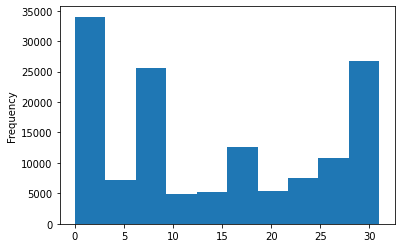

In [299]:
print(hurricane_labels)
pd.Series(hurricane_labels).plot.hist()
aug_data['DIST_BUCKET'] = hurricane_labels

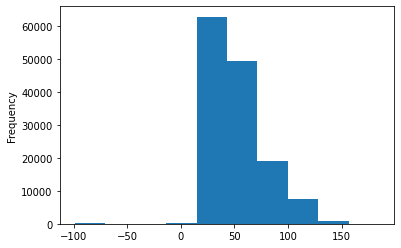

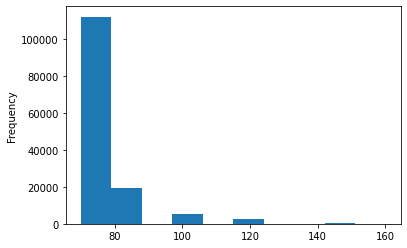

In [274]:
def f(x):
    x = x['WINDSPEED_KT']
    if x <= 74:
        return 70
    elif x <= 95:
        return 85
    elif x <= 111:
        return 100
    elif x <= 130:
        return 120
    elif x <= 157:
        return 145
    else:
        return 160
aug_data.WINDSPEED_KT.plot.hist()
plt.show()
aug_data['WINDSPEED_CAT'] = aug_data.apply(
    lambda row: f(row), axis=1
)
aug_data.WINDSPEED_CAT.plot.hist()
plt.show()

In [316]:
columns = ["DIST_TO_COASTLINE", "CLUSTER","WINDSPEED_CAT"]#, "PRESSURE_MB"]
X = aug_data[columns]
y = aug_data['HU_LANDFALL']
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#X_scaled = pd.DataFrame(X_scaled, columns = columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.8675887209177656
Classification Report:
<function classification_report at 0x7f6a851340d0>
Confusion Matrix:


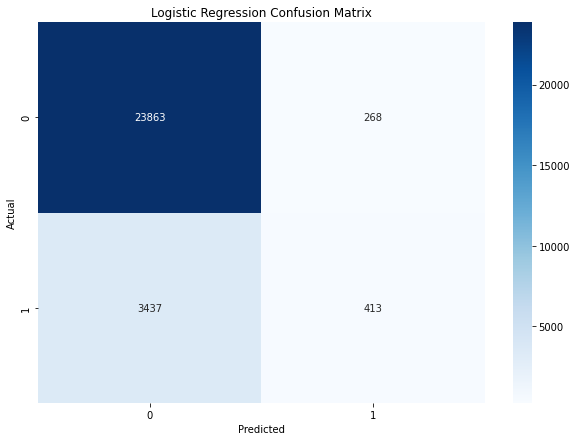

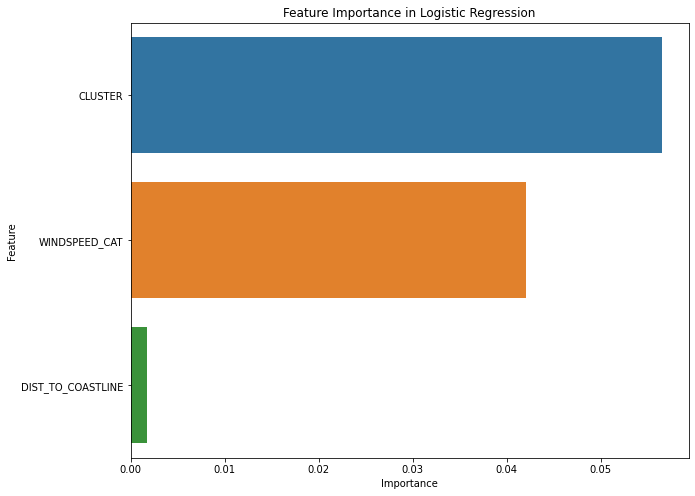

In [271]:



# Create a Logistic Regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cnf = confusion_matrix(y_test.tolist(), y_pred.tolist())

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report)
print("Confusion Matrix:")

plt.figure(figsize=(10, 7))
sns.heatmap(cnf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

coefficients = logistic_model.coef_[0]

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is a DataFrame. If X is a NumPy array, provide column names accordingly.
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance_df['Importance'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Logistic Regression')
plt.show()



In [320]:
# Assuming X and y are your feature matrix and target vector
# X = ... # Your feature matrix
# y = ... # Your target vector

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample')

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
 random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
 random_state=42)

Accuracy: 0.9081162217218827
F1 Score: 0.7015670342426001
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     24131
           1       0.63      0.78      0.70      3850

    accuracy                           0.91     27981
   macro avg       0.80      0.86      0.82     27981
weighted avg       0.92      0.91      0.91     27981



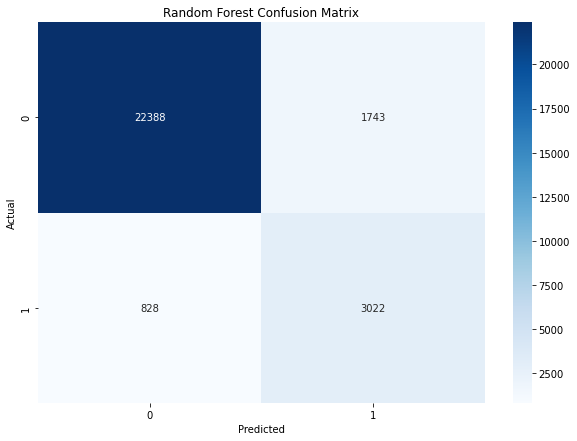

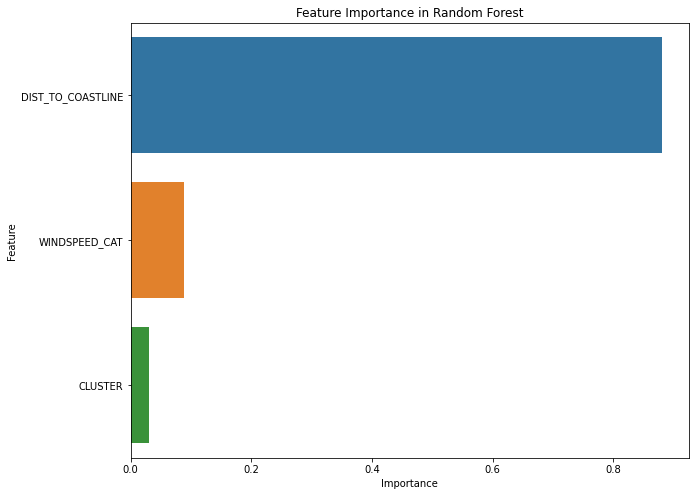

In [321]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print(f"F1 Score: {f1_score_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

feature_importances = rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is a DataFrame. If X is a NumPy array, provide column names accordingly.
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

In [319]:
scores_test = []
scores_train = []
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf_model.fit(X.iloc[train], y.iloc[train])
    y_pred_rf = rf_model.predict(X.iloc[test])
    accuracy_rf = accuracy_score(y.iloc[test], y_pred_rf)
    f1_score_rf = f1_score(y.iloc[test], y_pred_rf)
    scores_test.append((accuracy_rf, f1_score_rf))
    y_pred_rf = rf_model.predict(X.iloc[train])
    accuracy_rf = accuracy_score(y.iloc[train], y_pred_rf)
    f1_score_rf = f1_score(y.iloc[train], y_pred_rf)
    scores_train.append((accuracy_rf, f1_score_rf))
display(pd.DataFrame(scores_train, columns=['Accuracy Test', 'F1 Score Test']))
display(pd.DataFrame(scores_test, columns=['Accuracy Test', 'F1 Score Test']))

Accuracy Test 
 F1 Score Test 
 
 
 
 
 0 
 0.962055 
 0.877066 
 
 
 1 
 0.962332 
 0.877818 
 
 
 2 
 0.961492 
 0.875441 
 
 
 3 
 0.962162 
 0.877179 
 
 
 4 
 0.962224 
 0.877442

Accuracy Test 
 F1 Score Test 
 
 
 
 
 0 
 0.907437 
 0.699117 
 
 
 1 
 0.905114 
 0.693099 
 
 
 2 
 0.907866 
 0.704629 
 
 
 3 
 0.908652 
 0.704167 
 
 
 4 
 0.908438 
 0.704975

In [280]:
lat_range = [25.6, 26.9]
long_range = [-80.282, -80.057]
aug_data['miami_mask'] = aug_data.apply(
    lambda row: 1 if (lat_range[0] <= row['LATITUDE'] <= lat_range[1]) and 
                     (long_range[0] <= row['LONGITUDE'] <= long_range[1]) else 0, axis= 1
)

In [282]:
columns = ["DIST_TO_COASTLINE", "CLUSTER","WINDSPEED_CAT"]#, "PRESSURE_MB"]
X = aug_data[columns]
y = aug_data['HU_LANDFALL']

y_pred = rf_model.predict(X)

X['PREDICTION_L'] = y_pred
aug_data['HU_LANDFALL_MIAMI'] = aug_data.apply(lambda row: 1 if (row['miami_mask'] == 1) & (row['HU_LANDFALL']) else 0, axis=1)
y = aug_data['HU_LANDFALL_MIAMI']

<ipython-input-282-fb145ddd41aa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PREDICTION_L'] = y_pred


In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest model
rf_model_city = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')

# Train the model
rf_model_city.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.9999285229262714
f1 score: 0.7499999999999999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27978
           1       0.60      1.00      0.75         3

    accuracy                           1.00     27981
   macro avg       0.80      1.00      0.87     27981
weighted avg       1.00      1.00      1.00     27981

Accuracy: 0.9999213752188986
f1 score: 0.717948717948718
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    139891
           1       0.56      1.00      0.72        14

    accuracy                           1.00    139905
   macro avg       0.78      1.00      0.86    139905
weighted avg       1.00      1.00      1.00    139905



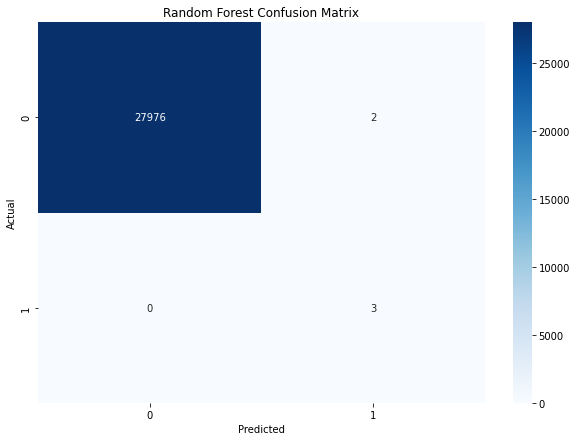

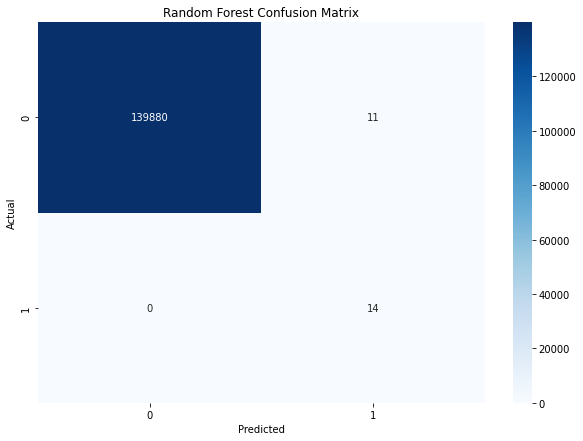

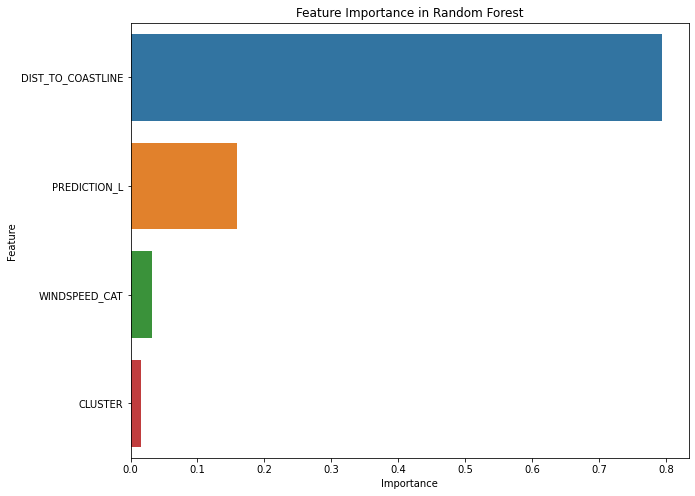

In [284]:
y_pred_rf = rf_model_city.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print(f"f1 score: {f1_score_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

y_pred_rf = rf_model_city.predict(X)

# Evaluate the model
accuracy_rf = accuracy_score(y, y_pred_rf)
f1_score_rf = f1_score(y, y_pred_rf)
classification_report_rf = classification_report(y, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print(f"f1 score: {f1_score_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

feature_importances = rf_model_city.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is a DataFrame. If X is a NumPy array, provide column names accordingly.
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

In [285]:
scores = []
for (train, test), i in zip(cv.split(X, y), range(5)):
    rf_model_city.fit(X.iloc[train], y.iloc[train])
    y_pred_rf = rf_model_city.predict(X.iloc[test])
    accuracy_rf = accuracy_score(y.iloc[test], y_pred_rf)
    f1_score_rf = f1_score(y.iloc[test], y_pred_rf)
    scores.append((accuracy_rf, f1_score_rf))
display(pd.DataFrame(scores, columns=['Accuracy Test', 'F1 Score Test']))

Accuracy Test 
 F1 Score Test 
 
 
 
 
 0 
 0.999964 
 0.800000 
 
 
 1 
 0.999893 
 0.666667 
 
 
 2 
 0.999929 
 0.750000 
 
 
 3 
 0.999893 
 0.666667 
 
 
 4 
 0.999929 
 0.750000

In [287]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
scores = []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf_model.fit(X.iloc[train], y.iloc[train])
    y_pred_rf = rf_model.predict(X.iloc[test])
    accuracy_rf = accuracy_score(y.iloc[test], y_pred_rf)
    f1_score_rf = f1_score(y.iloc[test], y_pred_rf)
    scores.append((accuracy_rf, f1_score_rf))
pd.DataFrame(scores, columns=['Accuracy Test', 'F1 Score Test'])

Accuracy Test 
 F1 Score Test 
 
 
 
 
 0 
 0.999964 
 0.666667 
 
 
 1 
 0.999964 
 0.800000 
 
 
 2 
 0.999964 
 0.800000 
 
 
 3 
 0.999964 
 0.800000 
 
 
 4 
 1.000000 
 1.000000

array([[%lt;Axes: title={'center': 'DIST_TO_COASTLINE'}%gt;,
 %lt;Axes: title={'center': 'CLUSTER'}%gt;],
 [%lt;Axes: title={'center': 'WINDSPEED_KT'}%gt;, %lt;Axes: %gt;]], dtype=object)

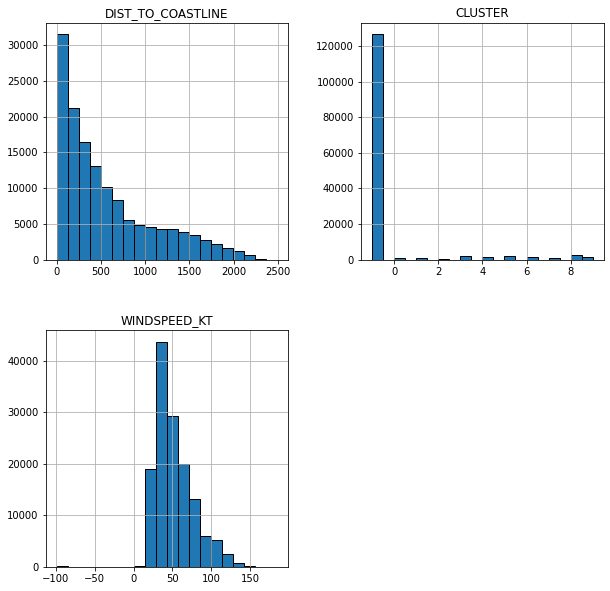

In [19]:
aug_data[columns].hist(figsize=(10, 10), bins=20, edgecolor='black')

DIST_TO_COASTLINE 
 CLUSTER 
 Actual 
 Predicted 
 
 
 
 
 count 
 216.000000 
 216.000000 
 216.0 
 216.0 
 
 
 mean 
 149.173333 
 5.481481 
 1.0 
 0.0 
 
 
 std 
 146.517751 
 2.180171 
 0.0 
 0.0 
 
 
 min 
 0.590000 
 0.000000 
 1.0 
 0.0 
 
 
 25% 
 43.767500 
 3.000000 
 1.0 
 0.0 
 
 
 50% 
 95.790000 
 5.000000 
 1.0 
 0.0 
 
 
 75% 
 201.230000 
 8.000000 
 1.0 
 0.0 
 
 
 max 
 780.750000 
 8.000000 
 1.0 
 0.0

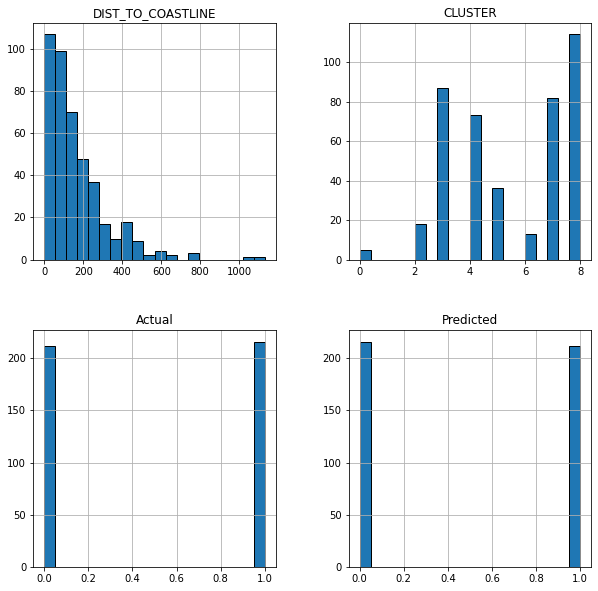

In [34]:
#display(misclassified_df.describe())
misclassified_df.reset_index()
#print(misclassified_df.columns)
ones_mis = misclassified_df[misclassified_df['Predicted'] == 0]
misclassified_df.hist(figsize=(10, 10), bins=20, edgecolor='black')
display(ones_mis.describe())

DIST_TO_COASTLINE 
 CLUSTER 
 Actual 
 Predicted 
 
 
 
 
 count 
 212.000000 
 212.000000 
 212.0 
 212.0 
 
 
 mean 
 176.255613 
 5.419811 
 0.0 
 1.0 
 
 
 std 
 165.120706 
 2.139270 
 0.0 
 0.0 
 
 
 min 
 0.210000 
 0.000000 
 0.0 
 1.0 
 
 
 25% 
 67.807500 
 4.000000 
 0.0 
 1.0 
 
 
 50% 
 141.655000 
 5.000000 
 0.0 
 1.0 
 
 
 75% 
 234.222500 
 7.250000 
 0.0 
 1.0 
 
 
 max 
 1131.090000 
 8.000000 
 0.0 
 1.0

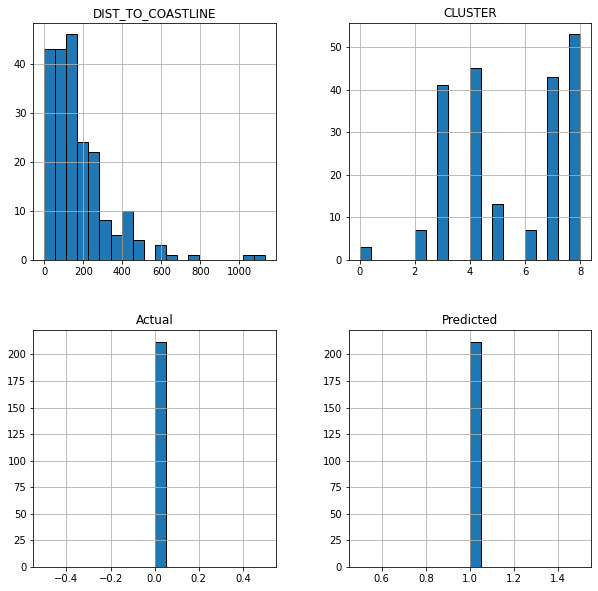

In [35]:
zeros_mis = misclassified_df[misclassified_df['Predicted'] == 1]
zeros_mis.hist(figsize=(10, 10), bins=20, edgecolor='black')
display(zeros_mis.describe())

Accuracy: 0.5192307692307693
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.51       198
           1       0.54      0.50      0.52       218

    accuracy                           0.52       416
   macro avg       0.52      0.52      0.52       416
weighted avg       0.52      0.52      0.52       416

Accuracy: 0.9903614457831326
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       828
           1       0.99      0.99      0.99       832

    accuracy                           0.99      1660
   macro avg       0.99      0.99      0.99      1660
weighted avg       0.99      0.99      0.99      1660



ValueError: ValueError: All arrays must be of the same length

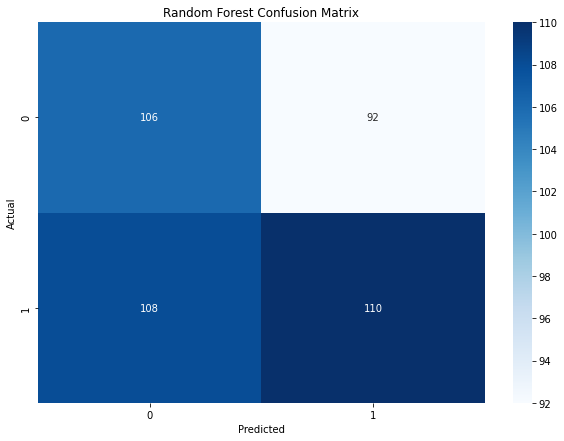

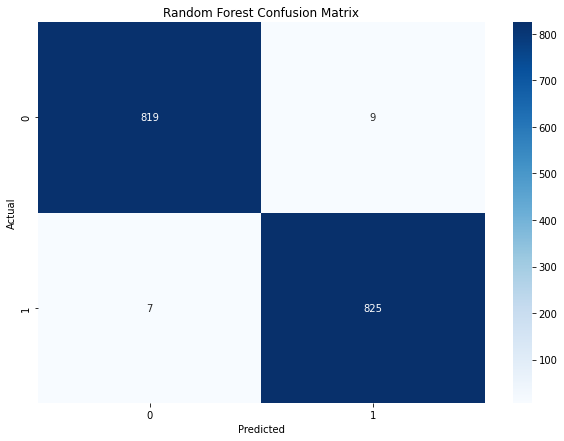

In [67]:


cols_sub = ['DIST_TO_COASTLINE', 'CLUSTER'] #, 'WINDSPEED_KT', 'PRESSURE_MB']
df = misclassified_df[cols_sub]
y = misclassified_df['Actual']

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns= cols_sub)

X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

y_pred_rf = rf_model.predict(X_train)

# Evaluate the model
accuracy_rf = accuracy_score(y_train, y_pred_rf)
classification_report_rf = classification_report(y_train, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y_train, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


feature_importances = rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is a DataFrame. If X is a NumPy array, provide column names accordingly.
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()
'''
misclassified_indices = np.where(y_test != y_pred_rf)[0]
misclassified_samples = X_test.iloc[misclassified_indices]
misclassified_actual = y_test.iloc[misclassified_indices]
misclassified_predicted = y_pred_rf[misclassified_indices]

# Create a DataFrame to display misclassified samples
misclassified_df = misclassified_samples.copy()
misclassified_df['Actual'] = misclassified_actual
misclassified_df['Predicted'] = misclassified_predicted

print("Misclassified Instances:")
#print(misclassified_df)
'''


'''
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming we want 3 clusters
kmeans.fit(df_scaled)

# Add the cluster labels to the original DataFrame
misclassified_df['Cluster'] = kmeans.labels_
misclassified_df['Diff'] = abs(misclassified_df['Cluster'] - misclassified_df['Actual'])
misclassified_df['Diff'].plot.hist()

display(misclassified_df[misclassified_df['Actual'] == 0].describe())
display(misclassified_df[misclassified_df['Actual'] == 1].describe())
'''
'''
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = kmeans.labels_
'''
'''
# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=cols_sub[0], y=cols_sub[1], hue='Cluster',data=df, palette='viridis')
plt.title('K-means Clustering Visualization with PCA')
plt.xlabel(cols_sub[0])
plt.ylabel(cols_sub[1])
plt.legend(title='Cluster')
plt.show()
'''

In [38]:
print(len(misclassified_indices))
aug_data['misclassfied_mask'] = 0
aug_data.loc[misclassified_indices, 'misclassfied_mask'] = 1

columns = ["DIST_TO_COASTLINE", "WINDSPEED_KT", "PRESSURE_MB", "CLUSTER"]
X = aug_data[columns]
y = aug_data['misclassfied_mask']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a Logistic Regression model
logistic_model = LogisticRegression(class_weight='balanced', solver='liblinear', l1_ratio=0.5)

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(np.array(y_test))
print(y_pred)
cnf = confusion_matrix(y_test.tolist(), y_pred.tolist())

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report)
print("Confusion Matrix:")

plt.figure(figsize=(10, 7))
sns.heatmap(cnf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

coefficients = logistic_model.coef_[0]

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # Assuming X is a DataFrame. If X is a NumPy array, provide column names accordingly.
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance_df['Importance'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Logistic Regression')
plt.show()

428


KeyError: KeyError: '[1, 6, 16, 17, 18, 24, 28, 29, 31, 33, 35, 39, 40, 42, 44, 50, 55, 58, 81, 83, 85, 88, 89, 94, 171, 175, 176, 177, 183, 186, 190, 194, 198, 200, 232, 236, 239, 243, 250, 253, 254, 255, 256, 260, 266, 269, 270, 271, 272, 277, 279, 280, 284, 287, 299, 311, 336, 337, 341, 343, 348, 351, 352, 354, 356, 359, 360, 361, 364, 371, 375, 378, 400, 402, 403, 405, 406, 407, 410, 413, 427, 443, 445, 449, 453, 455, 456, 502, 508, 511, 512, 515, 518, 523, 524, 529, 536, 538, 542, 543, 545, 546, 555, 556, 564, 568, 570, 571, 572, 574, 630, 633, 636, 638, 642, 646, 651, 654, 661, 695, 697, 700, 703, 705, 707, 713, 717, 723, 732, 733, 734, 741, 748, 750, 754, 755, 757, 758, 765, 767, 786, 793, 794, 804, 805, 806, 844, 845, 846, 851, 900, 902, 903, 907, 933, 938, 941, 946, 958, 978, 979, 985, 987, 994, 998, 1005, 1006, 1010, 1012, 1023, 1028, 1030, 1033, 1034, 1036, 1037, 1040, 1063, 1067, 1069, 1071, 1077, 1087, 1089, 1090, 1093, 1094, 1096, 1099, 1106, 1109, 1110, 1113, 1114, 1118, 1120, 1122, 1131, 1134, 1138, 1140, 1144, 1147, 1148, 1153, 1155, 1162, 1163, 1166, 1170, 1171, 1174, 1176, 1177, 1190, 1193, 1199, 1202, 1218, 1222, 1231, 1233, 1234, 1238, 1248, 1250, 1252, 1297, 1304, 1313, 1316, 1367, 1368, 1372, 1374, 1380, 1394, 1401, 1403, 1407, 1410, 1411, 1413, 1416, 1432, 1435, 1436, 1438, 1439, 1443, 1444, 1445, 1450, 1451, 1453, 1454, 1455, 1468, 1471, 1473, 1475, 1489, 1490, 1496, 1497, 1502, 1515, 1518, 1523, 1524, 1538, 1540, 1544, 1552, 1557, 1567, 1578, 1579, 1594, 1598, 1600, 1609, 1610, 1615, 1617, 1618, 1644, 1659, 1660, 1666, 1671] not in index'

67
8356
Accuracy: 0.7910447761194029
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        59
           1       0.12      0.12      0.12         8

    accuracy                           0.79        67
   macro avg       0.50      0.50      0.50        67
weighted avg       0.79      0.79      0.79        67



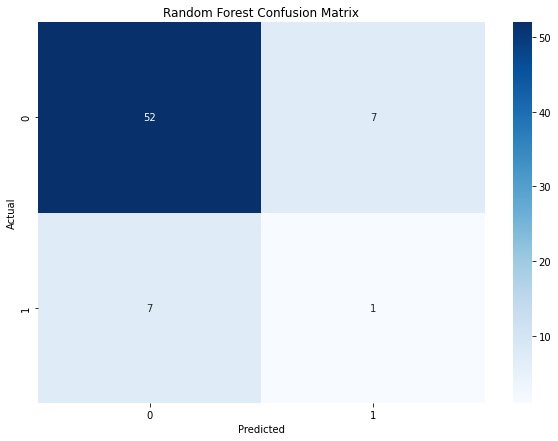

In [40]:
lat_range = [25.89, 28.4]
long_range = [-82.6, -81.5]
aug_data['miami_mask'] = aug_data.apply(
    lambda row: 1 if (lat_range[0] <= row['LATITUDE'] <= lat_range[1]) and 
                     (long_range[0] <= row['LONGITUDE'] <= long_range[1]) else 0, axis= 1
)

miami_data = aug_data[aug_data['miami_mask'] == 1]
print(len(miami_data))
print(len(aug_data))
columns = ["DIST_TO_COASTLINE", "CLUSTER"] #, "WINDSPEED_KT", "PRESSURE_MB"]
X = miami_data[columns]
y = miami_data['HU_LANDFALL']

y_pred_rf = rf_model.predict(X)

# Evaluate the model
accuracy_rf = accuracy_score(y, y_pred_rf)
classification_report_rf = classification_report(y, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

### Model to Predict 0 - 1 Made Landfall in Miami

lat range: 25.5 to 27
lon range: -81 to 80

In [41]:
aug_data['MIAMI_HU_LANDFALL'] = aug_data.apply(
    lambda row: 1 if (25.5 <= row['LATITUDE'] <= 27) and (-81 <= row['LONGITUDE'] <= -80) and (row['HU_LANDFALL'] == 1) else 0,
    axis=1
)

Class distribution before resampling:
0    8349
1       7
Name: MIAMI_HU_LANDFALL, dtype: int64
Class distribution in the training set before resampling:
0    6677
1       7
Name: MIAMI_HU_LANDFALL, dtype: int64
Class distribution after resampling:
0    6677
1    6677
Name: MIAMI_HU_LANDFALL, dtype: int64
Training Set Accuracy: 0.9094653287404523
Training Set Confusion Matrix:
[[5468 1209]
 [   0 6677]]
Actual values: [0 0 0 ... 0 0 0]
Predicted values: [0 0 0 ... 0 0 0]
Accuracy: 0.8241626794258373
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1672
           1       0.00      0.00      0.00         0

    accuracy                           0.82      1672
   macro avg       0.50      0.41      0.45      1672
weighted avg       1.00      0.82      0.90      1672

Confusion Matrix:
[[1378  294]
 [   0    0]]


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


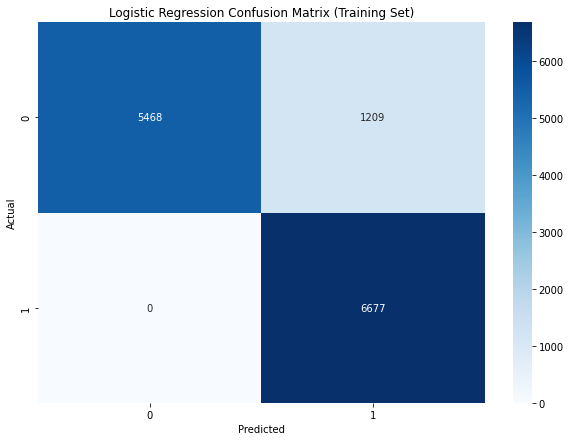

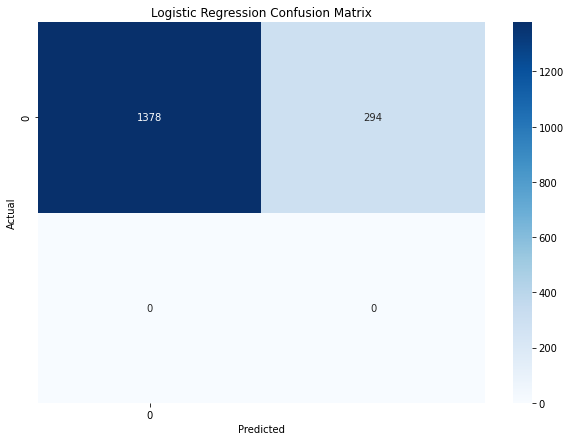

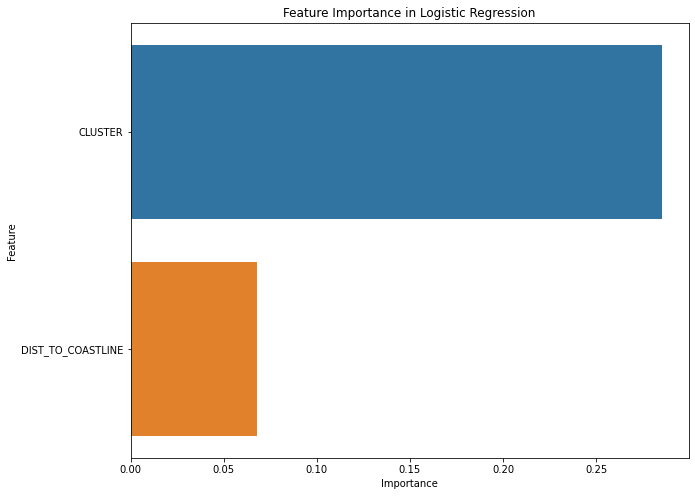

In [42]:
columns = ["DIST_TO_COASTLINE", "CLUSTER"] #, "WINDSPEED_KT", "PRESSURE_MB"]
X = aug_data[columns]
y = aug_data['MIAMI_HU_LANDFALL']

# Checking the class distribution
class_counts = y.value_counts()
print("Class distribution before resampling:")
print(class_counts)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the class distribution in the training set
train_class_counts = y_train.value_counts()
print("Class distribution in the training set before resampling:")
print(train_class_counts)

# Applying SMOTE to handle the class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the class distribution after resampling
resampled_class_counts = pd.Series(y_train_resampled).value_counts()
print("Class distribution after resampling:")
print(resampled_class_counts)

# Create a Logistic Regression model
logistic_model = LogisticRegression()

# Train the model
logistic_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the training set
y_train_pred = logistic_model.predict(X_train_resampled)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
cnf_train = confusion_matrix(y_train_resampled.tolist(), y_train_pred.tolist())

print(f"Training Set Accuracy: {accuracy_train}")
print("Training Set Confusion Matrix:")
print(cnf_train)

plt.figure(figsize=(10, 7))
sns.heatmap(cnf_train, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train_resampled), yticklabels=np.unique(y_train_resampled))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix (Training Set)')
plt.show()

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Actual values: {np.array(y_test)}")
print(f"Predicted values: {y_pred}")
cnf = confusion_matrix(y_test.tolist(), y_pred.tolist())

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(cnf)

plt.figure(figsize=(10, 7))
sns.heatmap(cnf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

coefficients = logistic_model.coef_[0]

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance_df['Importance'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [43]:
# Count the number of HIDs by cluster
hid_counts_by_cluster = aug_data.groupby('CLUSTER')['HID'].nunique()

# Print the counts
print(hid_counts_by_cluster)

CLUSTER
0.0    53
1.0    33
2.0     7
3.0    21
4.0    57
5.0    59
6.0    22
7.0    55
8.0    94
Name: HID, dtype: int64


Class distribution before resampling:
0    139849
1        56
Name: MIAMI_HU_LANDFALL, dtype: int64
Class distribution in the training set before resampling:
0    111876
1        48
Name: MIAMI_HU_LANDFALL, dtype: int64
Class distribution after resampling:
0    111876
1    111876
Name: MIAMI_HU_LANDFALL, dtype: int64
Accuracy: 0.9997498302419499
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27973
           1       0.53      1.00      0.70         8

    accuracy                           1.00     27981
   macro avg       0.77      1.00      0.85     27981
weighted avg       1.00      1.00      1.00     27981



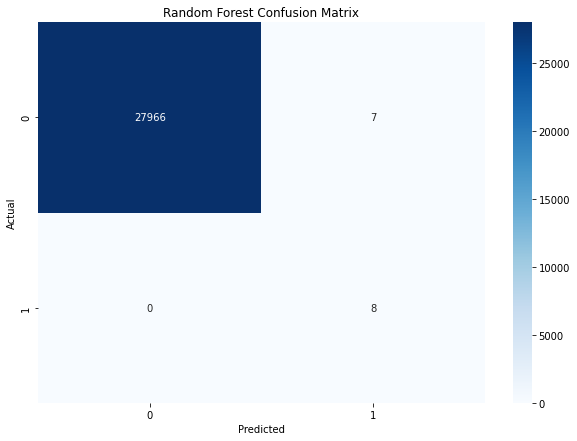

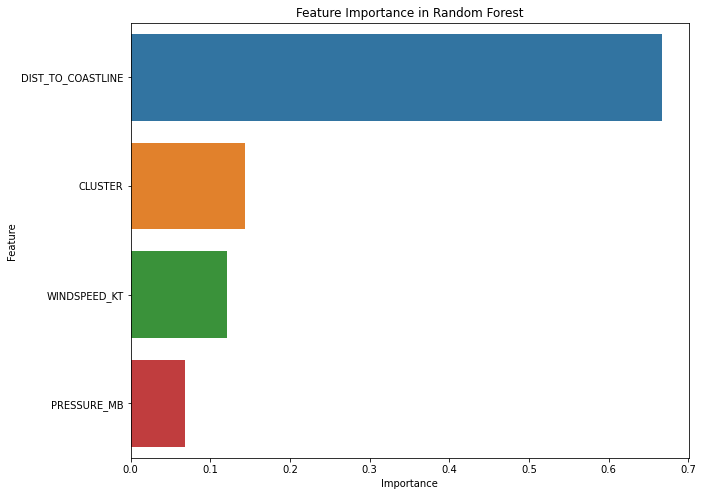

In [18]:
columns = ["DIST_TO_COASTLINE", "WINDSPEED_KT", "PRESSURE_MB", "CLUSTER"]
X = aug_data[columns]
y = aug_data['MIAMI_HU_LANDFALL']

# Checking the class distribution
class_counts = y.value_counts()
print("Class distribution before resampling:")
print(class_counts)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the class distribution in the training set
train_class_counts = y_train.value_counts()
print("Class distribution in the training set before resampling:")
print(train_class_counts)

# Applying SMOTE to handle the class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the class distribution after resampling
resampled_class_counts = pd.Series(y_train_resampled).value_counts()
print("Class distribution after resampling:")
print(resampled_class_counts)

# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:")
print(classification_report_rf)

# Compute the confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest')
plt.show()

Class distribution before resampling:
0    139849
1        56
Name: MIAMI_HU_LANDFALL, dtype: int64
Class distribution in the training set before resampling:
0    111876
1        48
Name: MIAMI_HU_LANDFALL, dtype: int64
Class distribution after resampling:
0    111876
1    111876
Name: MIAMI_HU_LANDFALL, dtype: int64
Accuracy: 0.9955326828919624
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27973
           1       0.06      1.00      0.11         8

    accuracy                           1.00     27981
   macro avg       0.53      1.00      0.56     27981
weighted avg       1.00      1.00      1.00     27981



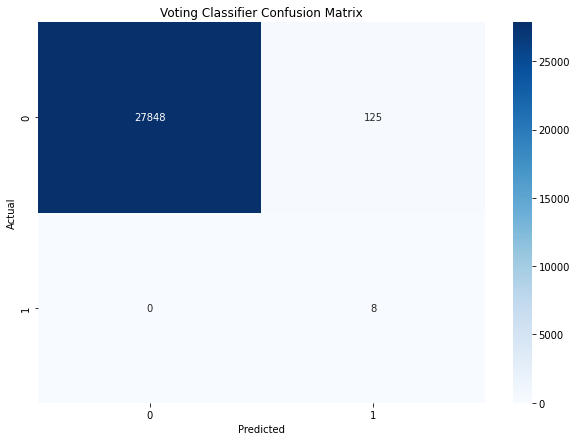

In [16]:
columns = ["DIST_TO_COASTLINE", "WINDSPEED_KT", "PRESSURE_MB", "CLUSTER"]
X = aug_data[columns]
y = aug_data['MIAMI_HU_LANDFALL']

# Checking the class distribution
class_counts = y.value_counts()
print("Class distribution before resampling:")
print(class_counts)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the class distribution in the training set
train_class_counts = y_train.value_counts()
print("Class distribution in the training set before resampling:")
print(train_class_counts)

# Applying SMOTE to handle the class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the class distribution after resampling
resampled_class_counts = pd.Series(y_train_resampled).value_counts()
print("Class distribution after resampling:")
print(resampled_class_counts)

# Create the base models
logistic_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the ensemble model using voting
voting_model = VotingClassifier(estimators=[
    ('logistic', logistic_model),
    ('rf', rf_model)
], voting='soft')  # Use 'hard' for majority voting, 'soft' for weighted voting based on probabilities

# Train the ensemble model
voting_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_voting = voting_model.predict(X_test)

# Evaluate the model
accuracy_voting = accuracy_score(y_test, y_pred_voting)
classification_report_voting = classification_report(y_test, y_pred_voting)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_voting}")
print("Classification Report:")
print(classification_report_voting)

# Compute the confusion matrix
cnf_matrix_voting = confusion_matrix(y_test, y_pred_voting)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cnf_matrix_voting, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Voting Classifier Confusion Matrix')
plt.show()

# Storm Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import numpy as np
import pyarrow as pq
from sklearn.preprocessing import MinMaxScaler
import glob
from tqdm import tqdm
import concurrent.futures

In [2]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 20.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [12]:

weather_data_directory = 'Weather/Open Meteo/Final/'

weather_files = glob.glob(f'{weather_data_directory}*.parquet')

weather_data_list = []

for file in weather_files:
    df = pd.read_parquet(file)
    weather_data_list.append(df)

weather_data = pd.concat(weather_data_list)

print(weather_data.describe())

scaler = MinMaxScaler()
weather_variables = ['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction']
weather_data[weather_variables] = scaler.fit_transform(weather_data[weather_variables])


florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

          precip_sum  severe_weather  temp_anomalies       temp_max  \
count  432264.000000        432264.0   432264.000000  432264.000000   
mean       90.053238             0.0        3.937170      25.208061   
std        71.687210             0.0        8.658982       3.673425   
min         0.000000             0.0        0.000000       1.963875   
25%        37.500000             0.0        0.000000      23.299999   
50%        73.300003             0.0        0.000000      25.932812   
75%       123.199997             0.0        1.000000      27.534374   
max      1163.499878             0.0       32.000000      40.436947   

           temp_mean       temp_min  wind_anomalies  wind_direction  \
count  432264.000000  432264.000000   432264.000000   432264.000000   
mean       23.708651      22.389645        2.489150      143.046219   
std         4.029182       4.610407        2.335178       53.691093   
min        -3.109052      -6.810875        0.000000        5.536644   
25%  

### Creating and Saving Weather Samples

In [13]:
weather_grid_lat = weather_data.index.get_level_values('latitude').unique()
weather_grid_lon = weather_data.index.get_level_values('longitude').unique()
weather_times = weather_data.index.get_level_values('time').unique().sort_values()

seq_length = 12

weather_variables = ['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction', 'severe_weather']
channels = len(weather_variables)
height = len(weather_grid_lat)
width = len(weather_grid_lon)

num_samples = len(weather_times) - seq_length

In [14]:
print(weather_times[10])
print(weather_times[10] + pd.DateOffset(months=12) - pd.DateOffset(days=1))
weather_times_year_month = weather_data.index.get_level_values('time').to_period('M').unique().sort_values()
print(weather_times_year_month[10+ seq_length - 1] + 1)

1940-11-01 00:00:00
1941-10-31 00:00:00
1941-11


In [7]:
def extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width):
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    data_array = np.zeros((seq_length, channels, height, width))
    for i, date in enumerate(dates):
        month_data = weather_data.loc[date]
        data_array[i] = month_data.values.T.reshape(channels, height, width)
    return data_array

def process_weather_sample(i, seq_length, weather_times, weather_data, channels, height, width):
    start_date = weather_times[i]
    end_date = start_date + pd.DateOffset(months=12) - pd.DateOffset(days=1)

    sample = extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width)
    return sample

num_samples = len(weather_times) - seq_length
weather_samples = np.zeros((num_samples, seq_length, channels, height, width))

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for i in tqdm(range(num_samples), desc="Submitting tasks for weather samples"):
        futures.append(executor.submit(process_weather_sample, i, seq_length, weather_times, weather_data, channels, height, width))
    
    for i, future in enumerate(tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results of weather samples")):
        weather_samples[i] = future.result()

print(weather_samples.shape)  # Should be (num_samples, seq_length, channels, height, width)

hdf5_filename = 'Weather/Open Meteo/weather_samples_storms.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('weather_samples_storms', data=weather_samples)

(984, 12, 9, 14, 31)


Processing results of weather samples: 100%|██████████| 984/984 [01:46<00:00,  9.27it/s]


In [30]:
hdf5_filename = 'Samples/weather_samples_storms.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('weather_samples_storms', data=weather_samples)

hdf5_filename

'Samples/weather_samples_storms.h5'

### Loading Weather Samples

In [15]:
with h5py.File('Samples/weather_samples_storms.h5', 'r') as f:
    dataset_name = list(f.keys())[0]  # Assuming there's at least one dataset
    weather_samples = f[dataset_name][:]
    
weather_samples.shape

(984, 12, 9, 14, 31)

In [16]:

hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'].astype(str), format='%Y-%m-%d')
hurricane_data = hurricane_data[hurricane_data['CLUSTER'] != -1]
hurricane_data['YEAR_MONTH'] = hurricane_data['DATE'].dt.to_period('M')

florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

hurricane_data = hurricane_data[
    (hurricane_data['LATITUDE'] >= florida_lat_range[0]) &
    (hurricane_data['LATITUDE'] <= florida_lat_range[1]) &
    (hurricane_data['LONGITUDE'] >= florida_lon_range[0]) &
    (hurricane_data['LONGITUDE'] <= florida_lon_range[1])
]

In [17]:
seq_length = 12
weather_times_year_month = weather_data.index.get_level_values('time').to_period('M').unique().sort_values()

def create_hurricane_labels(weather_times_year_month, hurricane_data, lat_range, lon_range, seq_length):
    num_samples = len(weather_times_year_month) - seq_length
    hurricane_labels = np.zeros(num_samples)
    season_feature = np.zeros(num_samples)
    hurricane_season_months = [6, 7, 8, 9, 10, 11]
    for idx in range(num_samples):
        next_month_period = weather_times_year_month[idx + seq_length - 1] + 1
        hurricanes_at_time = hurricane_data[hurricane_data['YEAR_MONTH'] == next_month_period]
        if not hurricanes_at_time.empty:
            hurricane_labels[idx] = 1
        if next_month_period.month in hurricane_season_months:
            season_feature[idx] = 1
    return hurricane_labels, season_feature


hurricane_labels, season_feature = create_hurricane_labels(weather_times_year_month, hurricane_data, florida_lat_range, florida_lon_range, seq_length)

print(hurricane_labels.shape)
print(hurricane_labels.mean())
print(season_feature.mean())

(984,)
0.3130081300813008
0.5


In [18]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data, labels, season_feature):
        self.weather_data = weather_data  # Shape: (num_samples, seq_length, channels, height, width)
        self.labels = labels  # Shape: (num_samples,)
        self.season_feature = season_feature  # Shape: (num_samples,)

    def __len__(self):
        return len(self.weather_data)

    def __getitem__(self, idx):
        return self.weather_data[idx], self.labels[idx], self.season_feature[idx]

class HybridModel(nn.Module):
    def __init__(self, input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes):
        super(HybridModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(cnn_out_channels, cnn_out_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        
        self.lstm = nn.LSTM(cnn_out_channels * 2 * (height // 4) * (width // 4), lstm_hidden_size, lstm_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_size + 1, num_classes)
        )

    def forward(self, x, season_feature):
        batch_size, seq_length, channels, height, width = x.size()
        
        cnn_features = []
        for t in range(seq_length):
            out = self.cnn(x[:, t, :, :, :])
            out = out.view(batch_size, -1)
            cnn_features.append(out)
        
        cnn_features = torch.stack(cnn_features, dim=1)
        
        lstm_out, _ = self.lstm(cnn_features)
        lstm_out = lstm_out[:, -1, :]
        
        lstm_out = torch.cat((lstm_out, season_feature.unsqueeze(1)), dim=1)
        
        out = self.fc(lstm_out)
        return out

In [30]:
class_counts = np.bincount(hurricane_labels.astype(int))
class_weights = 1. / class_counts
weights = class_weights[hurricane_labels.astype(int)]
sample_weights = torch.from_numpy(weights).float()

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = 2
height, width = len(weather_grid_lat), len(weather_grid_lon) 

dataset = WeatherDataset(weather_samples, hurricane_labels, season_feature)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, sampler=WeightedRandomSampler(sample_weights[:train_size], num_samples=train_size, replacement=True))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    for inputs, labels, season in train_loader:
        inputs, labels, season = inputs.to(torch.float32), labels.to(torch.long), season.to(torch.float32)
        
        optimizer.zero_grad()
        
        outputs = model(inputs, season)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels, season in test_loader:
            inputs, labels, season = inputs.to(torch.float32), labels.to(torch.long), season.to(torch.float32)
            outputs = model(inputs, season)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

print("Training complete!")

Epoch 1/25, Train Loss: 0.6885950374603271, Test Loss: 0.6933424151860751
Epoch 2/25, Train Loss: 0.5926982188224792, Test Loss: 0.49681198596954346
Epoch 3/25, Train Loss: 0.4394424158334732, Test Loss: 0.5413710635442001
Epoch 4/25, Train Loss: 0.48593627870082856, Test Loss: 0.49576858144540054
Epoch 5/25, Train Loss: 0.43630703538656235, Test Loss: 0.5352224363730504
Epoch 6/25, Train Loss: 0.4371608649194241, Test Loss: 0.4844152537676004
Epoch 7/25, Train Loss: 0.4489248752593994, Test Loss: 0.49535234845601595
Epoch 8/25, Train Loss: 0.4364962169528008, Test Loss: 0.5142121016979218
Epoch 9/25, Train Loss: 0.40030506312847136, Test Loss: 0.5328574077441142
Epoch 10/25, Train Loss: 0.47330393821001054, Test Loss: 0.5022811075815787
Epoch 11/25, Train Loss: 0.4192963778972626, Test Loss: 0.4909489705012395
Epoch 12/25, Train Loss: 0.4450755774974823, Test Loss: 0.4600775654499347
Epoch 13/25, Train Loss: 0.4332413327693939, Test Loss: 0.47921526661285985
Epoch 14/25, Train Loss: 0

Training Accuracy: 0.7980
Training Precision: 0.8426
Training Recall: 0.7980
Training F1-Score: 0.8062
Test Accuracy: 0.7614
Test Precision: 0.7779
Test Recall: 0.7614
Test F1-Score: 0.7653


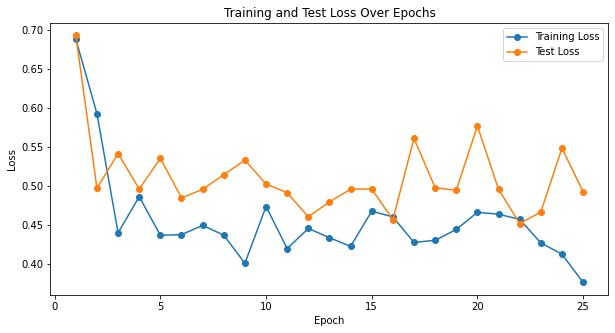

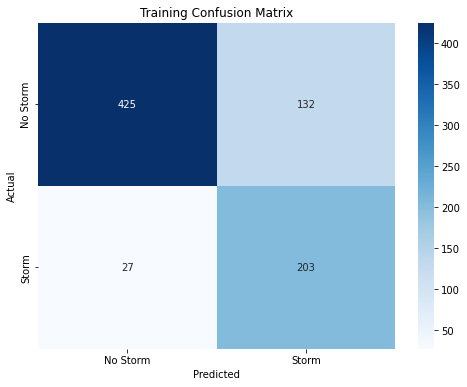

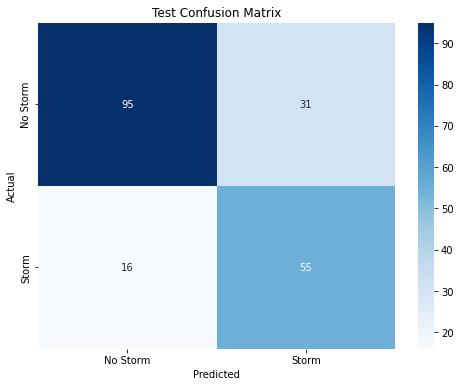

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval()
train_labels = []
train_preds = []

with torch.no_grad():
    for inputs, labels, season in train_loader:
        inputs, labels, season = inputs.to(torch.float32), labels.to(torch.long), season.to(torch.float32)
        outputs = model(inputs, season)
        _, preds = torch.max(outputs, 1)
        train_labels.extend(labels.numpy())
        train_preds.extend(preds.numpy())

train_accuracy = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
train_f1 = f1_score(train_labels, train_preds, average='weighted')

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Precision: {train_precision:.4f}')
print(f'Training Recall: {train_recall:.4f}')
print(f'Training F1-Score: {train_f1:.4f}')

train_conf_matrix = confusion_matrix(train_labels, train_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Storm', 'Storm'], yticklabels=['No Storm', 'Storm'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')
plt.show()

test_labels = []
test_preds = []

with torch.no_grad():
    for inputs, labels, season in test_loader:
        inputs, labels, season = inputs.to(torch.float32), labels.to(torch.long), season.to(torch.float32)
        outputs = model(inputs, season)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.numpy())
        test_preds.extend(preds.numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

test_conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Storm', 'Storm'], yticklabels=['No Storm', 'Storm'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

In [32]:
model_path = 'Models/storm_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to Models/storm_model.pth


In [19]:
input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = 2
height, width = len(weather_grid_lat), len(weather_grid_lon) 

model_path = 'Models/storm_model.pth'
model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(672, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=65, out_features=2, bias=True)
  )
)

In [20]:
dataset = WeatherDataset(weather_samples, hurricane_labels, season_feature)


def get_data_for_month(dataset, month_year, weather_times_year_month):
    for i in range(len(dataset)):
        weather_sample, label, season = dataset[i]
        sample_month_year = weather_times_year_month[i]
        if sample_month_year == month_year:
            return weather_sample, label, season
    return None, None, None

def get_model_prediction_and_probability(model, sample, season_feature):
    model.eval()
    with torch.no_grad():
        sample = torch.tensor(sample).unsqueeze(0).float()
        season_feature = torch.tensor(season_feature).unsqueeze(0).float()
        output = model(sample, season_feature)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_label = torch.max(output, 1)
        predicted_probability = probabilities[0, predicted_label].item()
        all_probabilities = probabilities.squeeze(0).numpy()
    return predicted_label.item(), predicted_probability, all_probabilities

month_to_check = '2017-09'
month_period = pd.Period(month_to_check, freq='M')

sample, true_label, season = get_data_for_month(dataset, month_period, weather_times_year_month)

if sample is not None:
    predicted_label, predicted_probability, all_probabilities = get_model_prediction_and_probability(model, sample, season)
    print(f'Month: {month_period}, True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {predicted_probability:.4f}')
    print(f'Class Probabilities: {all_probabilities}')
else:
    print(f'Month: {month_period} data not found.')

print("Spot checking complete!")

Month: 2017-09, True Label: 1.0, Predicted Label: 1, Probability: 0.9189
Class Probabilities: [0.08108003 0.91892   ]
Spot checking complete!


# Path Model

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import torch
import torch.nn as nn
from collections import Counter
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 44.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
weather_data_directory = 'Weather/Open Meteo/Final/'
weather_files = glob.glob(f'{weather_data_directory}*.parquet')
weather_data_list = [pd.read_parquet(file) for file in weather_files]
weather_data = pd.concat(weather_data_list)

scaler = MinMaxScaler()
weather_variables = ['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction', 'severe_weather']
weather_data[weather_variables] = scaler.fit_transform(weather_data[weather_variables])

hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')
#print(hurricane_data[hurricane_data['HNAME'].apply(lambda x: x.strip())=='MICHAEL'])
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'].astype(str), format='%Y-%m-%d')

florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

hurricane_data = hurricane_data[
    (hurricane_data['LATITUDE'] >= florida_lat_range[0]) &
    (hurricane_data['LATITUDE'] <= florida_lat_range[1]) &
    (hurricane_data['LONGITUDE'] >= florida_lon_range[0]) &
    (hurricane_data['LONGITUDE'] <= florida_lon_range[1])
]


weather_times_year_month = weather_data.index.get_level_values('time').to_period('M').unique()
min_month = min(weather_data.index.get_level_values('time'))+timedelta(days=365)
max_month = max(weather_data.index.get_level_values('time'))

hurricane_data = hurricane_data[(hurricane_data['DATE']>=min_month)&(hurricane_data['DATE']<=max_month)]
print(hurricane_data[hurricane_data['HNAME'].apply(lambda x: x.strip())=='MICHAEL'])

hurricane_data = hurricane_data[hurricane_data['CLUSTER'] != -1]

seq_length = 12 

channels = len(weather_variables)
weather_grid_lat = weather_data.index.get_level_values('latitude').unique()
weather_grid_lon = weather_data.index.get_level_values('longitude').unique()
height = len(weather_grid_lat)
width = len(weather_grid_lon)

            DATE  TIME_UTC POINT_TYPE STATUS  LATITUDE  LONGITUDE  \
42185 2000-10-15      1200        NaN     SS      30.0      -71.2   
42186 2000-10-15      1800        NaN     SS      30.0      -71.5   
42187 2000-10-16         0        NaN     SS      29.9      -71.8   
42188 2000-10-16       600        NaN     SS      29.9      -71.9   
42189 2000-10-16      1200        NaN     SS      29.7      -71.7   
42190 2000-10-16      1800        NaN     SS      29.8      -71.4   
42191 2000-10-17         0        NaN     TS      29.9      -71.1   
42192 2000-10-17       600        NaN     TS      29.8      -71.0   
42193 2000-10-17      1200        NaN     TS      29.8      -70.9   
42194 2000-10-17      1800        NaN     HU      30.1      -70.9   
42195 2000-10-18         0        NaN     HU      30.4      -70.9   
42196 2000-10-18       600        NaN     HU      30.8      -70.8   
42197 2000-10-18      1200        NaN     HU      31.5      -70.4   
42198 2000-10-18      1800        

In [5]:
hid_counts_by_cluster = hurricane_data.groupby('CLUSTER')['HID'].nunique()

print(hid_counts_by_cluster)

CLUSTER
0.0     47
1.0     33
2.0     42
3.0     39
4.0     16
5.0     18
6.0     13
7.0     34
8.0     70
9.0    106
Name: HID, dtype: int64


In [209]:
from tqdm import tqdm
import h5py
import concurrent.futures
import pandas as pd
import numpy as np

def extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width):
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    data_array = np.zeros((seq_length, channels, height, width))
    for i, date in enumerate(dates):
        month_data = weather_data.loc[date]
        data_array[i] = month_data.values.T.reshape(channels, height, width)
    return data_array

def process_hurricane(row, seq_length, channels, height, width, weather_data):
    hurricane_date = row['DATE']
    hurricane_cluster = row['CLUSTER']
    
    start_date = hurricane_date - pd.DateOffset(months=seq_length)
    end_date = hurricane_date - pd.DateOffset(months=1)
    
    sample = extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width)
    return sample, hurricane_cluster

weather_samples = []
hurricane_labels = []

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for idx, row in tqdm(hurricane_data.iterrows(), total=hurricane_data.shape[0], desc="Submitting tasks"):
        futures.append(executor.submit(process_hurricane, row, seq_length, channels, height, width, weather_data))

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results"):
        sample, cluster = future.result()
        weather_samples.append(sample)
        hurricane_labels.append(cluster)

weather_samples = np.array(weather_samples)
hurricane_labels = np.array(hurricane_labels)

print(weather_samples.shape)  # Should be (num_samples, seq_length, channels, height, width)
print(hurricane_labels.shape)

hdf5_filename = 'Weather/Open Meteo/weather_samples_paths.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('weather_samples_paths', data=weather_samples)
hdf5_filename = 'Weather/Open Meteo/hurricane_labels_paths.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('hurricane_labels_paths', data=hurricane_labels)

(9890, 12, 9, 14, 31)
(9890,)


Processing results: 100%|██████████| 9890/9890 [18:03<00:00,  9.13it/s]


In [210]:

hdf5_filename = 'Samples/weather_samples_paths.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('weather_samples_paths', data=weather_samples)
hdf5_filename = 'Samples/hurricane_labels_paths.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('hurricane_labels_paths', data=hurricane_labels)

### Start here to load from saved files

In [9]:
import h5py
weather_samples_filename = 'Samples/weather_samples_paths.h5'
hurricane_labels_filename = 'Samples/hurricane_labels_paths.h5'

with h5py.File(weather_samples_filename, 'r') as f:
    weather_samples = f['weather_samples_paths'][:]

with h5py.File(hurricane_labels_filename, 'r') as f:
    hurricane_labels = f['hurricane_labels_paths'][:]

print(f'Weather samples shape: {weather_samples.shape}')
print(f'Hurricane labels shape: {hurricane_labels.shape}')

Weather samples shape: (9890, 12, 9, 14, 31)
Hurricane labels shape: (9890,)


In [7]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data, labels):
        self.weather_data = weather_data  # Shape: (num_samples, seq_length, channels, height, width)
        self.labels = labels  # Shape: (num_samples,)

    def __len__(self):
        return len(self.weather_data)

    def __getitem__(self, idx):
        return self.weather_data[idx], self.labels[idx]

class HybridModel(nn.Module):
    def __init__(self, input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes):
        super(HybridModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(cnn_out_channels, cnn_out_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        
        self.lstm = nn.LSTM(cnn_out_channels * 2 * (height // 4) * (width // 4), lstm_hidden_size, lstm_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_size, num_classes)
        )

    def forward(self, x):
        batch_size, seq_length, channels, height, width = x.size()
        
        cnn_features = []
        for t in range(seq_length):
            out = self.cnn(x[:, t, :, :, :])
            out = out.view(batch_size, -1)
            cnn_features.append(out)
        
        cnn_features = torch.stack(cnn_features, dim=1)
        
        lstm_out, _ = self.lstm(cnn_features)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step
        
        out = self.fc(lstm_out)
        return out

In [47]:


input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = len(np.unique(hurricane_labels))


class_counts = np.bincount(hurricane_labels.astype(int))
class_weights = 1. / class_counts
weights = class_weights[hurricane_labels.astype(int)]
sample_weights = torch.from_numpy(weights).float()

dataset = WeatherDataset(weather_samples, hurricane_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_weights = sample_weights[:train_size]
test_weights = sample_weights[train_size:]
train_sampler = WeightedRandomSampler(train_weights, num_samples=train_size, replacement=True)
test_sampler = WeightedRandomSampler(test_weights, num_samples=test_size, replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, sampler=test_sampler, num_workers=4)

model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(torch.float32), labels.to(torch.long)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(torch.float32), labels.to(torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

print("Training complete!")

Epoch 1/20, Train Loss: 2.30466025477708, Test Loss: 2.30252883895751
Epoch 2/20, Train Loss: 2.2983088618577128, Test Loss: 2.277889190181609
Epoch 3/20, Train Loss: 2.278559013328167, Test Loss: 2.2458594902869193
Epoch 4/20, Train Loss: 2.169341119852933, Test Loss: 2.122440977442649
Epoch 5/20, Train Loss: 2.069232289478032, Test Loss: 1.946619890389904
Epoch 6/20, Train Loss: 1.8371452476039076, Test Loss: 1.644754647247253
Epoch 7/20, Train Loss: 1.5374147753522853, Test Loss: 1.4010000844155588
Epoch 8/20, Train Loss: 1.2924142307103281, Test Loss: 1.140268761304117
Epoch 9/20, Train Loss: 1.1118468624172788, Test Loss: 0.9907560543187203
Epoch 10/20, Train Loss: 1.0031592591242358, Test Loss: 0.862979206827379
Epoch 11/20, Train Loss: 0.8928702180433755, Test Loss: 0.7739658386957261
Epoch 12/20, Train Loss: 0.8315708099591611, Test Loss: 0.7836888247439938
Epoch 13/20, Train Loss: 0.7738951015653033, Test Loss: 0.7225626678236069
Epoch 14/20, Train Loss: 0.73422580888175, Test

/opt/python/envs/default/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 20/20: 100%|██████████| 495/495 [00:21<00:00, 23.15it/s]


Training Accuracy: 0.7323
Training Precision: 0.7812
Training Recall: 0.7323
Training F1-Score: 0.7316
Test Accuracy: 0.7204
Test Precision: 0.7822
Test Recall: 0.7204
Test F1-Score: 0.7227


/opt/python/envs/default/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


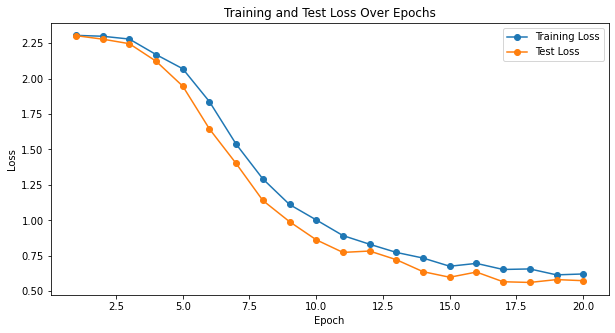

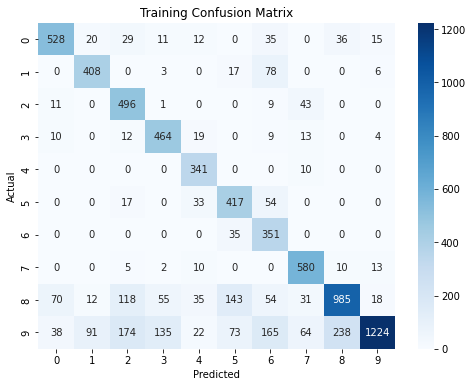

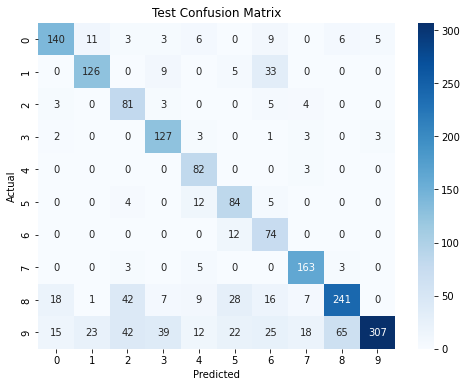

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval()
train_labels = []
train_preds = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(torch.float32), labels.to(torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        train_labels.extend(labels.numpy())
        train_preds.extend(preds.numpy())

train_accuracy = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
train_f1 = f1_score(train_labels, train_preds, average='weighted')

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Precision: {train_precision:.4f}')
print(f'Training Recall: {train_recall:.4f}')
print(f'Training F1-Score: {train_f1:.4f}')

train_conf_matrix = confusion_matrix(train_labels, train_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')
plt.show()

test_labels = []
test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(torch.float32), labels.to(torch.long)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.numpy())
        test_preds.extend(preds.numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

test_conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

In [203]:
model_path = 'Models/path_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to Models/path_model.pth


In [10]:
input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = len(np.unique(hurricane_labels))

model_path = 'Models/path_model.pth'
model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(672, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [11]:
dataset = WeatherDataset(weather_samples, hurricane_labels)

def get_data_for_month(dataset, month_year, weather_times_year_month):
    for i in range(len(dataset)):
        weather_sample, label = dataset[i]
        sample_month_year = weather_times_year_month[i]
        if sample_month_year == month_year:
            return weather_sample, label
    return None, None

def get_model_prediction_and_probabilities(model, sample):
    model.eval()
    with torch.no_grad():
        sample = torch.tensor(sample).unsqueeze(0).float()
        output = model(sample)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_label = torch.max(output, 1)
        all_probabilities = probabilities.squeeze(0).numpy()
    return predicted_label.item(), all_probabilities

month_to_check = '2017-09'
month_period = pd.Period(month_to_check, freq='M')

sample, true_label = get_data_for_month(dataset, month_period, weather_times_year_month)

if sample is not None:
    predicted_label, all_probabilities = get_model_prediction_and_probabilities(model, sample)
    predicted_probability = all_probabilities[predicted_label]
    print(f'Month: {month_period}, True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {predicted_probability:.4f}')
    print(f'Class Probabilities: {all_probabilities}')
else:
    print(f'Month: {month_period} data not found.')

print("Spot checking complete!")

Month: 2017-09, True Label: 7.0, Predicted Label: 7, Probability: 0.9863
Class Probabilities: [8.0130203e-04 9.4098505e-04 5.6626217e-04 5.0801923e-04 1.7053140e-03
 7.0804170e-05 2.0656717e-05 9.8626107e-01 1.5029343e-03 7.6226955e-03]
Spot checking complete!


# Lat/Lon Model

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import h5py
import concurrent.futures
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import seaborn as sns
from datetime import datetime, timedelta
import geopandas as gpd

In [83]:
!pip install pyarrow


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [22]:
weather_samples_filename = 'Samples/weather_samples_paths.h5'

with h5py.File(weather_samples_filename, 'r') as f:
    weather_samples = f['weather_samples_paths'][:]


print(f'Weather samples shape: {weather_samples.shape}')

Weather samples shape: (9890, 12, 9, 14, 31)


In [23]:
weather_data_directory = 'Weather/Open Meteo/Final/'
weather_files = glob.glob(f'{weather_data_directory}*.parquet')
weather_data_list = [pd.read_parquet(file) for file in weather_files]
weather_data = pd.concat(weather_data_list)

scaler = MinMaxScaler()
weather_variables = ['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction', 'severe_weather']
weather_data[weather_variables] = scaler.fit_transform(weather_data[weather_variables])

hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'].astype(str), format='%Y-%m-%d')

florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

hurricane_data = hurricane_data[
    (hurricane_data['LATITUDE'] >= florida_lat_range[0]) &
    (hurricane_data['LATITUDE'] <= florida_lat_range[1]) &
    (hurricane_data['LONGITUDE'] >= florida_lon_range[0]) &
    (hurricane_data['LONGITUDE'] <= florida_lon_range[1])
]


weather_times_year_month = weather_data.index.get_level_values('time').to_period('M').unique()
min_month = min(weather_data.index.get_level_values('time'))+timedelta(days=365)
max_month = max(weather_data.index.get_level_values('time'))

hurricane_data = hurricane_data[(hurricane_data['DATE']>=min_month)&(hurricane_data['DATE']<=max_month)]
hurricane_data = hurricane_data[hurricane_data['CLUSTER'] != -1]

seq_length = 12 

channels = len(weather_variables)
weather_grid_lat = weather_data.index.get_level_values('latitude').unique()
weather_grid_lon = weather_data.index.get_level_values('longitude').unique()
height = len(weather_grid_lat)
width = len(weather_grid_lon)

### Trying with Bins instead

In [24]:
import geopandas as gpd

lat_range = (15, 35)
lon_range = (-90, -50)
lat_bins = 4
lon_bins = 8
total_bins = lat_bins * lon_bins

lat_bin_edges = np.linspace(lat_range[0], lat_range[1], lat_bins + 1)
lon_bin_edges = np.linspace(lon_range[0], lon_range[1], lon_bins + 1)

def find_bin(lat, lon, lat_bin_edges, lon_bin_edges):
    lat_bin = np.digitize(lat, lat_bin_edges) - 1
    lon_bin = np.digitize(lon, lon_bin_edges) - 1
    
    if lat == lat_bin_edges[-1]:
        lat_bin -= 1
    if lon == lon_bin_edges[-1]:
        lon_bin -= 1
    
    lat_bin = np.clip(lat_bin, 0, len(lat_bin_edges) - 2)
    lon_bin = np.clip(lon_bin, 0, len(lon_bin_edges) - 2)
    
    combined_bin = lat_bin * lon_bins + lon_bin
    return combined_bin


In [25]:
def process_hurricane_label(row):
    combined_bin = find_bin(row['LATITUDE'], row['LONGITUDE'], lat_bin_edges, lon_bin_edges)
    return combined_bin

hurricane_labels = []

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for idx, row in tqdm(hurricane_data.iterrows(), total=hurricane_data.shape[0], desc="Submitting tasks"):
        futures.append(executor.submit(process_hurricane_label, row))

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results"):
        combined_bin = future.result()
        hurricane_labels.append(combined_bin)

hurricane_labels = np.array(hurricane_labels)

print(hurricane_labels.shape)

(9890,)


Processing results: 100%|██████████| 9890/9890 [00:04<00:00, 2251.26it/s]


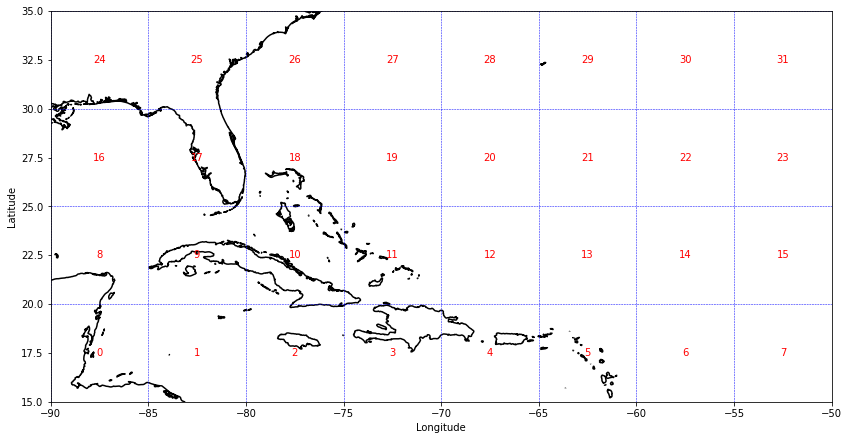

In [26]:
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline.plot(ax=ax, color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

for lat in lat_bin_edges:
    plt.axhline(y=lat, color='blue', linestyle='--', linewidth=0.5)
for lon in lon_bin_edges:
    plt.axvline(x=lon, color='blue', linestyle='--', linewidth=0.5)

for i in range(lat_bins):
    for j in range(lon_bins):
        lat_center = (lat_bin_edges[i] + lat_bin_edges[i + 1]) / 2
        lon_center = (lon_bin_edges[j] + lon_bin_edges[j + 1]) / 2
        bin_number = i * lon_bins + j
        plt.text(lon_center, lat_center, str(bin_number), color='red', ha='center', va='center')

plt.show()

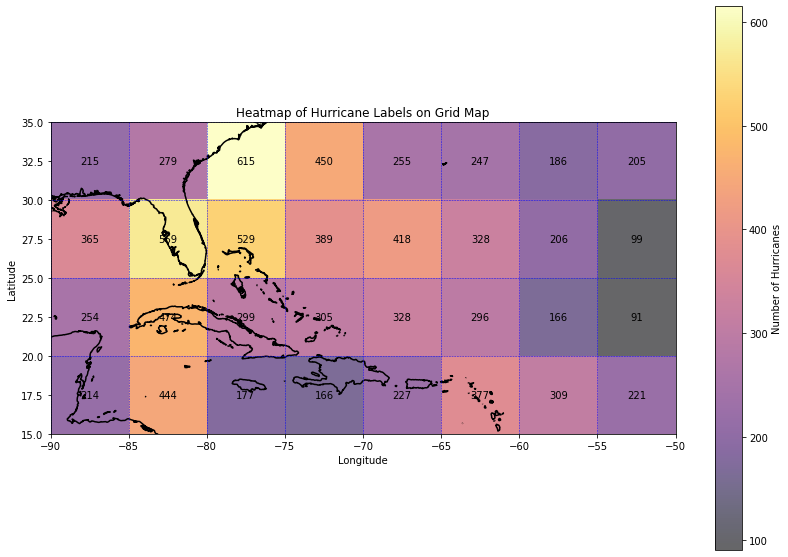

In [27]:
heatmap, xedges, yedges = np.histogram2d(
    hurricane_data['LONGITUDE'], hurricane_data['LATITUDE'], bins=[lon_bin_edges, lat_bin_edges]
)

counts, _, _ = np.histogram2d(
    hurricane_data['LONGITUDE'], hurricane_data['LATITUDE'], bins=[lon_bin_edges, lat_bin_edges]
)

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')
coastline.plot(ax=ax, color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

for lat in lat_bin_edges:
    plt.axhline(y=lat, color='blue', linestyle='--', linewidth=0.5)
for lon in lon_bin_edges:
    plt.axvline(x=lon, color='blue', linestyle='--', linewidth=0.5)

extent = [lon_bin_edges[0], lon_bin_edges[-1], lat_bin_edges[0], lat_bin_edges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='inferno', alpha=0.6)

for i in range(len(lat_bin_edges) - 1):
    for j in range(len(lon_bin_edges) - 1):
        plt.text((lon_bin_edges[j] + lon_bin_edges[j + 1]) / 2, 
                 (lat_bin_edges[i] + lat_bin_edges[i + 1]) / 2, 
                 str(int(counts[j, i])), 
                 color='black', ha='center', va='center')

plt.colorbar(label='Number of Hurricanes')
plt.title('Heatmap of Hurricane Labels on Grid Map')
plt.show()

In [28]:
cluster_labels = []

for idx, row in tqdm(hurricane_data.iterrows(), total=hurricane_data.shape[0], desc="Processing hurricanes"):
    hurricane_date = row['DATE']
    hurricane_cluster = row['CLUSTER']
    
    cluster_labels.append(hurricane_cluster)

cluster_labels = np.array(cluster_labels)

print(cluster_labels.shape)

(9890,)


Processing hurricanes: 100%|██████████| 9890/9890 [00:00<00:00, 23552.39it/s]


In [29]:
def create_distance_matrix(lat_bin_edges, lon_bin_edges, lat_bins, lon_bins):
    lat_centers = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
    lon_centers = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2
    
    distance_matrix = np.zeros((lat_bins * lon_bins, lat_bins * lon_bins))
    
    for i in range(lat_bins):
        for j in range(lon_bins):
            bin_idx1 = i * lon_bins + j
            for m in range(lat_bins):
                for n in range(lon_bins):
                    bin_idx2 = m * lon_bins + n
                    distance = np.sqrt((lat_centers[i] - lat_centers[m])**2 + (lon_centers[j] - lon_centers[n])**2)
                    distance_matrix[bin_idx1, bin_idx2] = distance
    
    return torch.tensor(distance_matrix, dtype=torch.float32)

distance_matrix = create_distance_matrix(lat_bin_edges, lon_bin_edges, lat_bins, lon_bins)

In [92]:
class SpatialLoss(nn.Module):
    def __init__(self, distance_matrix):
        super(SpatialLoss, self).__init__()
        self.distance_matrix = distance_matrix

    def forward(self, pred, target):
        # Convert target to one-hot encoding
        target_one_hot = nn.functional.one_hot(target, num_classes=self.distance_matrix.size(0)).float()
        pred_probs = nn.functional.softmax(pred, dim=1)
        
        # Compute the weighted distance
        loss = torch.sum(self.distance_matrix * target_one_hot.unsqueeze(2) * pred_probs.unsqueeze(1), dim=(1, 2))
        return loss.mean()

In [30]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data, cluster_labels, hurricane_labels):
        self.weather_data = weather_data  # Shape: (num_samples, seq_length, channels, height, width)
        self.cluster_labels = cluster_labels  # Shape: (num_samples,)
        self.hurricane_labels = hurricane_labels  # Shape: (num_samples,)

    def __len__(self):
        return len(self.weather_data)

    def __getitem__(self, idx):
        return self.weather_data[idx], self.cluster_labels[idx], self.hurricane_labels[idx]

class HybridModel(nn.Module):
    def __init__(self, input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes, num_clusters):
        super(HybridModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(cnn_out_channels, cnn_out_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        
        self.lstm = nn.LSTM(cnn_out_channels * 2 * (height // 4) * (width // 4), lstm_hidden_size, lstm_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_size + num_clusters, num_classes)
        )
        
        self.embedding = nn.Embedding(num_clusters, num_clusters)

    def forward(self, x, clusters):
        batch_size, seq_length, channels, height, width = x.size()
        
        cnn_features = []
        for t in range(seq_length):
            out = self.cnn(x[:, t, :, :, :])
            out = out.view(batch_size, -1)
            cnn_features.append(out)
        
        cnn_features = torch.stack(cnn_features, dim=1)
        
        lstm_out, _ = self.lstm(cnn_features)
        lstm_out = lstm_out[:, -1, :]  
        
        cluster_embeddings = self.embedding(clusters)
        lstm_out = torch.cat((lstm_out, cluster_embeddings), dim=1)
        
        out = self.fc(lstm_out)
        return out

In [216]:
print(len(weather_samples))
print(len(cluster_labels))
print(len(hurricane_labels))

9890
9890
9890


In [217]:
input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = len(np.unique(hurricane_labels))
num_clusters = len(np.unique(cluster_labels))

class_counts = np.bincount(hurricane_labels.astype(int))
class_weights = 1. / class_counts
weights = class_weights[hurricane_labels.astype(int)]
sample_weights = torch.from_numpy(weights).float()

dataset = WeatherDataset(weather_samples, cluster_labels, hurricane_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_weights = sample_weights[:train_size]
test_weights = sample_weights[train_size:]
train_sampler = WeightedRandomSampler(train_weights, num_samples=train_size, replacement=True)
test_sampler = WeightedRandomSampler(test_weights, num_samples=test_size, replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, sampler=test_sampler, num_workers=4)

model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes, num_clusters)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, clusters, hurricane_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, clusters, hurricane_labels = inputs.to(torch.float32), clusters.to(torch.long), hurricane_labels.to(torch.long)
        
        optimizer.zero_grad()
        
        outputs = model(inputs, clusters)
        loss = criterion(outputs, hurricane_labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, clusters, hurricane_labels in test_loader:
            inputs, clusters, hurricane_labels = inputs.to(torch.float32), clusters.to(torch.long), hurricane_labels.to(torch.long)
            outputs = model(inputs, clusters)
            loss = criterion(outputs, hurricane_labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

print("Training complete!")

Epoch 1/100, Train Loss: 3.3317150226747145, Test Loss: 3.163213501053472
Epoch 2/100, Train Loss: 3.1523672532553624, Test Loss: 2.983556003339829
Epoch 3/100, Train Loss: 3.0578227197281036, Test Loss: 2.9001587513954408
Epoch 4/100, Train Loss: 3.0214530983356513, Test Loss: 2.8596256413767414
Epoch 5/100, Train Loss: 3.0225089530752163, Test Loss: 2.859389801179209
Epoch 6/100, Train Loss: 2.988085098459263, Test Loss: 2.847966282598434
Epoch 7/100, Train Loss: 2.996156682390155, Test Loss: 2.8305799095861373
Epoch 8/100, Train Loss: 3.00403530429108, Test Loss: 2.8218975201729806
Epoch 9/100, Train Loss: 3.01198987382831, Test Loss: 2.8412436035371598
Epoch 10/100, Train Loss: 2.974447405458701, Test Loss: 2.8050105456382997
Epoch 11/100, Train Loss: 2.95591390060656, Test Loss: 2.7955723750975823
Epoch 12/100, Train Loss: 2.964436520952167, Test Loss: 2.784263728126403
Epoch 13/100, Train Loss: 2.9500423686672943, Test Loss: 2.8301265393534014
Epoch 14/100, Train Loss: 2.92626415

Epoch 100/100: 100%|██████████| 495/495 [00:20<00:00, 23.77it/s]


Training Accuracy: 0.3298
Training Precision: 0.3641
Training Recall: 0.3298
Training F1-Score: 0.3272
Test Accuracy: 0.2619
Test Precision: 0.3051
Test Recall: 0.2619
Test F1-Score: 0.2677


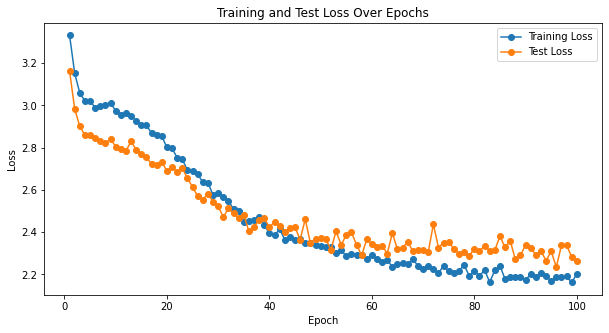

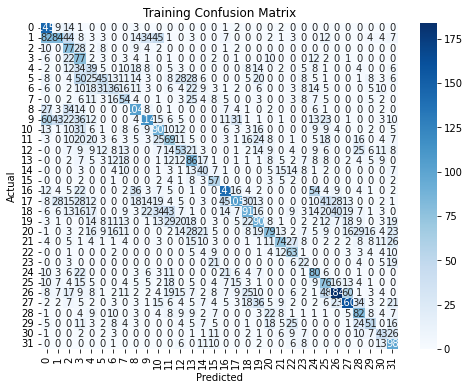

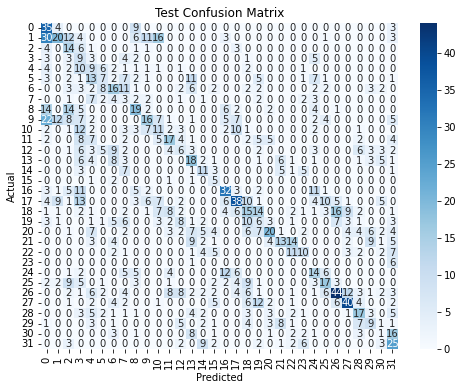

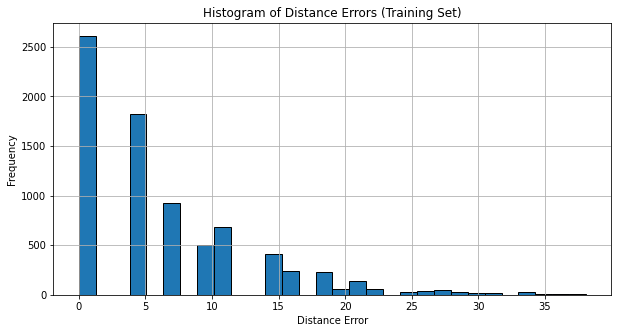

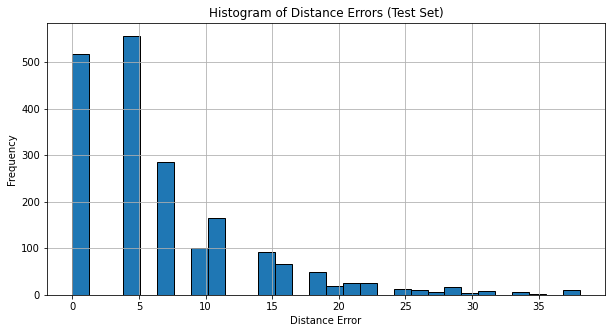

In [219]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval()
train_labels = []
train_preds = []

with torch.no_grad():
    for inputs, clusters, labels in train_loader:
        inputs, clusters, labels = inputs.to(torch.float32), clusters.to(torch.long), labels.to(torch.long)
        outputs = model(inputs, clusters)
        _, preds = torch.max(outputs, 1)
        train_labels.extend(labels.numpy())
        train_preds.extend(preds.numpy())

train_accuracy = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
train_f1 = f1_score(train_labels, train_preds, average='weighted')

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Precision: {train_precision:.4f}')
print(f'Training Recall: {train_recall:.4f}')
print(f'Training F1-Score: {train_f1:.4f}')

train_conf_matrix = confusion_matrix(train_labels, train_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')
plt.show()

test_labels = []
test_preds = []

with torch.no_grad():
    for inputs, clusters, labels in test_loader:
        inputs, clusters, labels = inputs.to(torch.float32), clusters.to(torch.long), labels.to(torch.long)
        outputs = model(inputs, clusters)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.numpy())
        test_preds.extend(preds.numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

test_conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

train_distances = [distance_matrix[true, pred] for true, pred in zip(train_labels, train_preds)]
test_distances = [distance_matrix[true, pred] for true, pred in zip(test_labels, test_preds)]

plt.figure(figsize=(10, 5))
plt.hist(train_distances, bins=30, edgecolor='black')
plt.xlabel('Distance Error')
plt.ylabel('Frequency')
plt.title('Histogram of Distance Errors (Training Set)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(test_distances, bins=30, edgecolor='black')
plt.xlabel('Distance Error')
plt.ylabel('Frequency')
plt.title('Histogram of Distance Errors (Test Set)')
plt.grid(True)
plt.show()

In [220]:
model_path = 'Models/latlon_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to Models/latlon_model.pth


In [31]:
input_channels = len(weather_variables) 
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = len(np.unique(hurricane_labels))  
num_clusters = len(np.unique(cluster_labels))  

model_path = 'Models/latlon_model.pth'
model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes, num_clusters)
model.load_state_dict(torch.load(model_path))
model.eval() 

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(672, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=74, out_features=32, bias=True)
  )
  (embedding): Embedding(10, 10)
)

In [32]:
dataset = WeatherDataset(weather_samples, cluster_labels, hurricane_labels)

def get_data_for_month(dataset, month_year, weather_times_year_month):
    for i in range(len(dataset)):
        weather_sample, cluster_label, hurricane_label = dataset[i]
        sample_month_year = weather_times_year_month[i]
        if sample_month_year == month_year:
            return weather_sample, cluster_label, hurricane_label
    return None, None, None

def get_model_prediction_and_probabilities(model, sample, custom_cluster):
    model.eval()
    with torch.no_grad():
        sample = torch.tensor(sample).unsqueeze(0).float()
        custom_cluster = torch.tensor(custom_cluster).unsqueeze(0).long()
        output = model(sample, custom_cluster)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_label = torch.max(output, 1)
        all_probabilities = probabilities.squeeze(0).numpy()
    return predicted_label.item(), all_probabilities

month_to_check = '2017-09'
month_period = pd.Period(month_to_check, freq='M')

sample, cluster_label, true_label = get_data_for_month(dataset, month_period, weather_times_year_month)

custom_cluster_prediction = 7  # Output from path model

if sample is not None:
    predicted_label, all_probabilities = get_model_prediction_and_probabilities(model, sample, custom_cluster_prediction)
    predicted_probability = all_probabilities[predicted_label]

    print(f'Month: {month_period}, True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {predicted_probability:.4f}, Distance:{distance_matrix[true_label][predicted_label]}')
    
    df_probabilities = pd.DataFrame(all_probabilities, columns=['Probability'])
    df_probabilities.index.name = 'Class'
    print(df_probabilities)
else:
    print(f'Month: {month_period} data not found.')

print("Spot checking complete!")

Month: 2017-09, True Label: 2, Predicted Label: 9, Probability: 0.4966, Distance:7.071067810058594
       Probability
Class             
0         0.014793
1         0.115158
2         0.011226
3         0.003373
4         0.001579
5         0.000742
6         0.000369
7         0.000224
8         0.012473
9         0.496628
10        0.026334
11        0.007017
12        0.001978
13        0.000820
14        0.000220
15        0.000132
16        0.010485
17        0.099641
18        0.051585
19        0.025354
20        0.001477
21        0.000559
22        0.000207
23        0.000420
24        0.003482
25        0.015994
26        0.029833
27        0.064161
28        0.001357
29        0.001749
30        0.000409
31        0.000222
Spot checking complete!


In [99]:
dataset = WeatherDataset(weather_samples, cluster_labels, hurricane_labels)

def get_data_for_months(dataset, month_years, weather_times_year_month):
    month_data = {}
    for month_year in month_years:
        for i in range(len(dataset)):
            weather_sample, cluster_label, hurricane_label = dataset[i]
            sample_month_year = weather_times_year_month[i]
            if sample_month_year == month_year:
                month_data[month_year] = (weather_sample, cluster_label, hurricane_label)
                break
    return month_data

def get_model_prediction_and_probability(model, sample, custom_cluster):
    model.eval()
    with torch.no_grad():
        sample = torch.tensor(sample).unsqueeze(0).float()
        custom_cluster = torch.tensor(custom_cluster).unsqueeze(0)
        output = model(sample, custom_cluster)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_label = torch.max(output, 1)
        predicted_probability = probabilities[0, predicted_label].item()
    return predicted_label.item(), predicted_probability

months_to_check = ['2018-10', '1992-08', '2004-08', '2017-08', '2004-09']
month_periods = [pd.Period(m, freq='M') for m in months_to_check]

saved_num_classes = 32
saved_num_clusters = 10

month_data = get_data_for_months(dataset, month_periods, weather_times_year_month)

results = []

custom_cluster_predictions = {
    '2018-10': 0,
    '1992-08': 6,
    '2004-08': 7,
    '2017-08': 7,
    '2004-09': 7
}

for month in month_periods:
    if month in month_data:
        sample, _, true_label = month_data[month]
        custom_cluster = custom_cluster_predictions[str(month)]
        predicted_label, predicted_probability = get_model_prediction_and_probability(model, sample, custom_cluster)
        results.append((month, true_label, predicted_label, predicted_probability))
        print(f'Month: {month}, True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {predicted_probability:.4f}, Distance: {distance_matrix[predicted_label][true_label]}')
    else:
        print(f'Month: {month} data not found.')

print("Spot checking complete!")

Month: 2018-10, True Label: 9, Predicted Label: 18, Probability: 0.1361, Distance: 7.071067810058594
Month: 1992-08, True Label: 12, Predicted Label: 8, Probability: 0.1903, Distance: 20.0
Month: 2004-08, True Label: 1, Predicted Label: 2, Probability: 0.1872, Distance: 5.0
Month: 2017-08, True Label: 8, Predicted Label: 9, Probability: 0.4966, Distance: 5.0
Month: 2004-09, True Label: 26, Predicted Label: 2, Probability: 0.1872, Distance: 15.0
Spot checking complete!


# Category Model

In [103]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import h5py
import concurrent.futures

In [33]:
weather_samples_filename = 'Samples/weather_samples_paths.h5'
with h5py.File(weather_samples_filename, 'r') as f:
    weather_samples = f['weather_samples_paths'][:]

print(weather_samples.shape)

(9890, 12, 9, 14, 31)


In [34]:
weather_data_directory = 'Weather/Open Meteo/Final/'
weather_files = glob.glob(f'{weather_data_directory}*.parquet')
weather_data_list = [pd.read_parquet(file) for file in weather_files]
weather_data = pd.concat(weather_data_list)

scaler = MinMaxScaler()
weather_variables = ['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction', 'severe_weather']
weather_data[weather_variables] = scaler.fit_transform(weather_data[weather_variables])

hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'].astype(str), format='%Y-%m-%d')

florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

hurricane_data = hurricane_data[
    (hurricane_data['LATITUDE'] >= florida_lat_range[0]) &
    (hurricane_data['LATITUDE'] <= florida_lat_range[1]) &
    (hurricane_data['LONGITUDE'] >= florida_lon_range[0]) &
    (hurricane_data['LONGITUDE'] <= florida_lon_range[1])
]


weather_times_year_month = weather_data.index.get_level_values('time').to_period('M').unique()
min_month = min(weather_data.index.get_level_values('time'))+timedelta(days=365)
max_month = max(weather_data.index.get_level_values('time'))

hurricane_data = hurricane_data[(hurricane_data['DATE']>=min_month)&(hurricane_data['DATE']<=max_month)]
hurricane_data = hurricane_data[hurricane_data['CLUSTER'] != -1]

seq_length = 12 

channels = len(weather_variables)
weather_grid_lat = weather_data.index.get_level_values('latitude').unique()
weather_grid_lon = weather_data.index.get_level_values('longitude').unique()
height = len(weather_grid_lat)
width = len(weather_grid_lon)

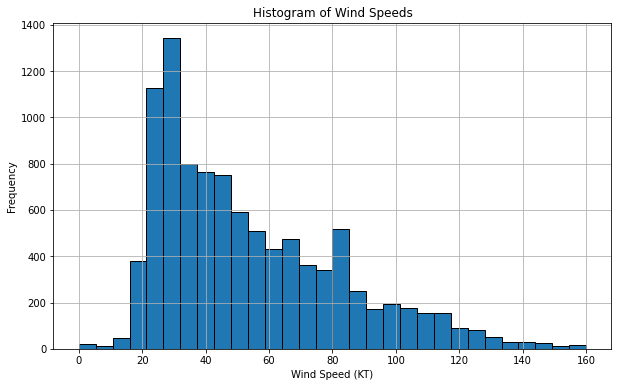

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(hurricane_data['WINDSPEED_KT'], bins=30, edgecolor='black')
plt.xlabel('Wind Speed (KT)')
plt.ylabel('Frequency')
plt.title('Histogram of Wind Speeds')
plt.grid(True)
plt.show()

In [36]:
def process_hurricane_label(row):
    return row['CATEGORY']

hurricane_labels = []

with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for idx, row in tqdm(hurricane_data.iterrows(), total=hurricane_data.shape[0], desc="Submitting tasks"):
        futures.append(executor.submit(process_hurricane_label, row))

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results"):
        category = future.result()
        hurricane_labels.append(category)

hurricane_labels = np.array(hurricane_labels)
print(hurricane_labels.shape)
category_counts = Counter(hurricane_labels)
for category, count in category_counts.items():
    print(f"Category {category}: {count} instances")

(9890,)
Category 5: 1266 instances
Category 1: 799 instances
Category 6: 860 instances
Category 0: 2927 instances
Category 7: 1428 instances
Category 3: 750 instances
Category 2: 762 instances
Category 4: 1098 instances


Processing results: 100%|██████████| 9890/9890 [00:03<00:00, 2689.73it/s]


In [37]:
cluster_labels = []

for idx, row in tqdm(hurricane_data.iterrows(), total=hurricane_data.shape[0], desc="Processing hurricanes"):
    hurricane_date = row['DATE']
    hurricane_cluster = row['CLUSTER']
    
    cluster_labels.append(hurricane_cluster)

cluster_labels = np.array(cluster_labels)

print(cluster_labels.shape)

(9890,)


Processing hurricanes: 100%|██████████| 9890/9890 [00:00<00:00, 22989.70it/s]


In [38]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data, cluster_labels, hurricane_labels):
        self.weather_data = weather_data  # Shape: (num_samples, seq_length, channels, height, width)
        self.cluster_labels = cluster_labels  # Shape: (num_samples,)
        self.hurricane_labels = hurricane_labels  # Shape: (num_samples,)

    def __len__(self):
        return len(self.weather_data)

    def __getitem__(self, idx):
        return self.weather_data[idx], self.cluster_labels[idx], self.hurricane_labels[idx]

class HybridModel(nn.Module):
    def __init__(self, input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes, num_clusters):
        super(HybridModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(cnn_out_channels, cnn_out_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )
        
        self.lstm = nn.LSTM(cnn_out_channels * 2 * (height // 4) * (width // 4), lstm_hidden_size, lstm_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(lstm_hidden_size + num_clusters, num_classes)
        )
        
        self.embedding = nn.Embedding(num_clusters, num_clusters)

    def forward(self, x, clusters):
        batch_size, seq_length, channels, height, width = x.size()
        
        cnn_features = []
        for t in range(seq_length):
            out = self.cnn(x[:, t, :, :, :])
            out = out.view(batch_size, -1)
            cnn_features.append(out)
        
        cnn_features = torch.stack(cnn_features, dim=1)
        
        lstm_out, _ = self.lstm(cnn_features)
        lstm_out = lstm_out[:, -1, :]
        
        cluster_embeddings = self.embedding(clusters)
        lstm_out = torch.cat((lstm_out, cluster_embeddings), dim=1)
        
        out = self.fc(lstm_out)
        return out

In [110]:
print(weather_samples.shape)
print(cluster_labels.shape)
print(np.unique(hurricane_labels))

(9890, 12, 9, 14, 31)
(9890,)
[0 1 2 3 4 5 6 7]


In [229]:
input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = len(np.unique(hurricane_labels))
num_clusters = len(np.unique(cluster_labels))

class_counts = np.bincount(hurricane_labels.astype(int))
class_weights = 1. / class_counts
weights = class_weights[hurricane_labels.astype(int)]
sample_weights = torch.from_numpy(weights).float()

dataset = WeatherDataset(weather_samples, cluster_labels, hurricane_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_weights = sample_weights[:train_size]
test_weights = sample_weights[train_size:]
train_sampler = WeightedRandomSampler(train_weights, num_samples=train_size, replacement=True)
test_sampler = WeightedRandomSampler(test_weights, num_samples=test_size, replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, sampler=test_sampler, num_workers=4)

model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes, num_clusters)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, clusters, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, clusters, labels = inputs.to(torch.float32), clusters.to(torch.long), labels.to(torch.long)
        
        optimizer.zero_grad()
        
        outputs = model(inputs, clusters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, clusters, labels in test_loader:
            inputs, clusters, labels = inputs.to(torch.float32), clusters.to(torch.long), labels.to(torch.long)
            outputs = model(inputs, clusters)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

print("Training complete!")

Epoch 1/50, Train Loss: 2.0733492314213455, Test Loss: 2.0604973252742522
Epoch 2/50, Train Loss: 2.050378013379646, Test Loss: 2.037978624143908
Epoch 3/50, Train Loss: 2.0430581817723286, Test Loss: 2.046547129269569
Epoch 4/50, Train Loss: 2.0365266392929384, Test Loss: 2.0488933334427495
Epoch 5/50, Train Loss: 2.0418141242229577, Test Loss: 2.0381257995482414
Epoch 6/50, Train Loss: 2.0338598785978377, Test Loss: 2.0422379432186
Epoch 7/50, Train Loss: 2.0376472983697447, Test Loss: 2.028678408553523
Epoch 8/50, Train Loss: 2.0326024325207026, Test Loss: 2.0530388287959562
Epoch 9/50, Train Loss: 2.024096431635847, Test Loss: 2.0358220233071234
Epoch 10/50, Train Loss: 2.019920159590365, Test Loss: 2.0139325193820463
Epoch 11/50, Train Loss: 2.016405950170575, Test Loss: 2.0043495133999856
Epoch 12/50, Train Loss: 2.014598418727066, Test Loss: 2.0043622168802444
Epoch 13/50, Train Loss: 2.006172836428941, Test Loss: 2.014330199649257
Epoch 14/50, Train Loss: 1.991920607499402, Tes

Epoch 50/50: 100%|██████████| 495/495 [00:20<00:00, 24.19it/s]


Training Accuracy: 0.4128
Training Precision: 0.4758
Training Recall: 0.4128
Training F1-Score: 0.4247
Test Accuracy: 0.3185
Test Precision: 0.3621
Test Recall: 0.3185
Test F1-Score: 0.3265


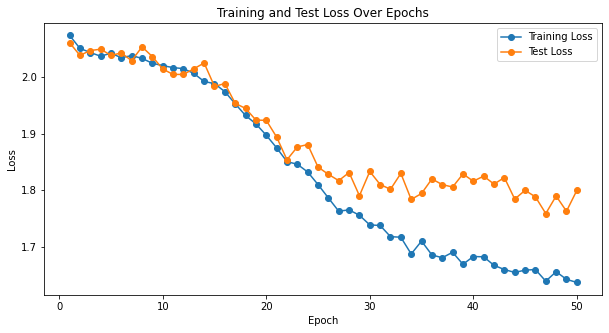

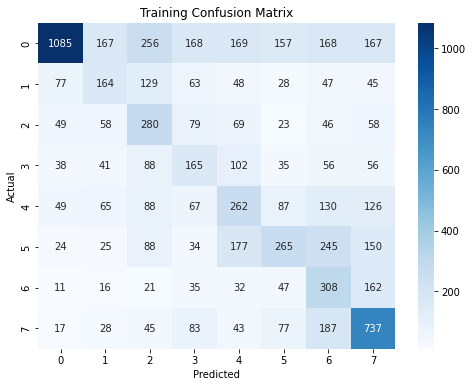

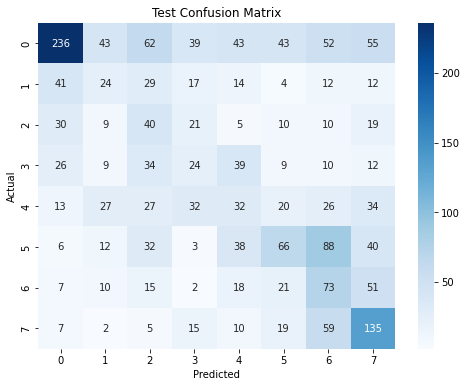

In [230]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

model.eval()
train_labels = []
train_preds = []

with torch.no_grad():
    for inputs, clusters, labels in train_loader:
        inputs, clusters, labels = inputs.to(torch.float32), clusters.to(torch.long), labels.to(torch.long)
        outputs = model(inputs, clusters)
        _, preds = torch.max(outputs, 1)
        train_labels.extend(labels.numpy())
        train_preds.extend(preds.numpy())

train_accuracy = accuracy_score(train_labels, train_preds)
train_precision = precision_score(train_labels, train_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
train_f1 = f1_score(train_labels, train_preds, average='weighted')

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Precision: {train_precision:.4f}')
print(f'Training Recall: {train_recall:.4f}')
print(f'Training F1-Score: {train_f1:.4f}')

train_conf_matrix = confusion_matrix(train_labels, train_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')
plt.show()

test_labels = []
test_preds = []

with torch.no_grad():
    for inputs, clusters, labels in test_loader:
        inputs, clusters, labels = inputs.to(torch.float32), clusters.to(torch.long), labels.to(torch.long)
        outputs = model(inputs, clusters)
        _, preds = torch.max(outputs, 1)
        test_labels.extend(labels.numpy())
        test_preds.extend(preds.numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

test_conf_matrix = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

In [232]:
model_path = 'Models/category_model.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to Models/category_model.pth


In [39]:
input_channels = len(weather_variables)
cnn_out_channels = 16
lstm_hidden_size = 64
lstm_layers = 2
num_classes = len(np.unique(hurricane_labels))
num_clusters = len(np.unique(cluster_labels))

model_path = 'Models/category_model.pth'
model = HybridModel(input_channels, cnn_out_channels, lstm_hidden_size, lstm_layers, num_classes, num_clusters)
model.load_state_dict(torch.load(model_path))
model.eval()

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (lstm): LSTM(672, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=74, out_features=8, bias=True)
  )
  (embedding): Embedding(10, 10)
)

In [40]:
dataset = WeatherDataset(weather_samples, cluster_labels, hurricane_labels)

def get_data_for_month(dataset, month_year, weather_times_year_month):
    for i in range(len(dataset)):
        weather_sample, cluster_label, hurricane_label = dataset[i]
        sample_month_year = weather_times_year_month[i]
        if sample_month_year == month_year:
            return weather_sample, cluster_label, hurricane_label
    return None, None, None

def get_model_prediction_and_probabilities(model, sample, custom_cluster):
    model.eval()
    with torch.no_grad():
        sample = torch.tensor(sample).unsqueeze(0).float()
        custom_cluster = torch.tensor(custom_cluster).unsqueeze(0).long()
        output = model(sample, custom_cluster)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_label = torch.max(output, 1)
        all_probabilities = probabilities.squeeze(0).numpy()
    return predicted_label.item(), all_probabilities

month_to_check = '2017-09'
month_period = pd.Period(month_to_check, freq='M')

sample, cluster_label, true_label = get_data_for_month(dataset, month_period, weather_times_year_month)

custom_cluster_prediction = 9 

if sample is not None:
    predicted_label, all_probabilities = get_model_prediction_and_probabilities(model, sample, custom_cluster_prediction)
    predicted_probability = all_probabilities[predicted_label]

    print(f'Month: {month_period}, True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {predicted_probability:.4f}')
    
    df_probabilities = pd.DataFrame(all_probabilities, columns=['Probability'])
    df_probabilities.index.name = 'Class'
    print(df_probabilities)
else:
    print(f'Month: {month_period} data not found.')

print("Spot checking complete!")

Month: 2017-09, True Label: 4, Predicted Label: 7, Probability: 0.6459
       Probability
Class             
0         0.001971
1         0.003378
2         0.004282
3         0.003930
4         0.006073
5         0.079824
6         0.254612
7         0.645930
Spot checking complete!


# Open Meteo Data Collection

In [25]:
import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry
from tqdm import tqdm
import time
import requests

In [24]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install pyarrow


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 16.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Below code will pull complete dataset (will need subscription)


Your personal API key is: AAWjeLzVD4vFNOq7
Your monthly API call limit: 1 million API calls

In [26]:
api_key = "AAWjeLzVD4vFNOq7"

In [27]:
import requests_cache
import pandas as pd
import numpy as np
from tqdm import tqdm
from retry_requests import retry
import openmeteo_requests
import time

florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

latitude_points = np.arange(florida_lat_range[0], florida_lat_range[1] + 1, 1.5)
longitude_points = np.arange(florida_lon_range[0], florida_lon_range[1] + 1, 1.5)

start_year = 2023
end_year = 2023
years = list(range(start_year, end_year + 1))

cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_weather_data(lat, lon, start_time, end_time, api_key):
    url = "https://customer-archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_time.strftime("%Y-%m-%d"),
        "end_date": end_time.strftime("%Y-%m-%d"),
        "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"],
        "apikey": api_key
    }

    responses = openmeteo.weather_api(url, params=params)
    if not responses:
        raise ValueError("No response from API")

    response = responses[0]

    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
    daily_wind_direction_dominant = daily.Variables(6).ValuesAsNumpy()

    daily_data = {
        "lat": lat,
        "lon": lon,
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "weather_code": daily_weather_code,
        "temperature_2m_max": daily_temperature_2m_max,
        "temperature_2m_min": daily_temperature_2m_min,
        "temperature_2m_mean": daily_temperature_2m_mean,
        "precipitation_sum": daily_precipitation_sum,
        "wind_speed_10m_max": daily_wind_speed_10m_max,
        "wind_direction_10m_dominant": daily_wind_direction_dominant
    }

    daily_dataframe = pd.DataFrame(data=daily_data)
    return daily_dataframe

def fetch_and_save_weather_data(year, api_key):
    months = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='MS')
    
    weather_data = []
    daily_data_list = []

    for lat in tqdm(latitude_points, desc="Latitudes"):
        for lon in tqdm(longitude_points, desc="Longitudes", leave=False):
            for start_time in tqdm(months, desc="Months", leave=False):
                end_time = start_time + pd.DateOffset(months=1)
                try:
                    df = get_weather_data(lat, lon, start_time, end_time, api_key)
                    
                    daily_data_list.append(df)

                    temp_max_mean = df['temperature_2m_max'].mean()
                    temp_min_mean = df['temperature_2m_min'].mean()
                    temp_mean_mean = df['temperature_2m_mean'].mean()
                    temp_anomalies = ((df['temperature_2m_max'] > temp_mean_mean + 5) | (df['temperature_2m_min'] < temp_mean_mean - 5)).sum()
                    precip_sum = df['precipitation_sum'].sum()
                    wind_max_mean = df['wind_speed_10m_max'].mean()
                    wind_anomalies = (df['wind_speed_10m_max'] > wind_max_mean + 10).sum()
                    wind_direction_mean = df['wind_direction_10m_dominant'].mean()
                    severe_weather = ((df['weather_code'] >= 91) & (df['weather_code'] <= 99)).sum()
                    
                    weather_data.append({
                        'latitude': lat,
                        'longitude': lon,
                        'time': start_time,
                        'temp_max': temp_max_mean,
                        'temp_min': temp_min_mean,
                        'temp_mean': temp_mean_mean,
                        'temp_anomalies': temp_anomalies,
                        'precip_sum': precip_sum,
                        'wind_max': wind_max_mean,
                        'wind_anomalies': wind_anomalies,
                        'wind_direction': wind_direction_mean,
                        'severe_weather': severe_weather
                    })
                except requests.exceptions.RequestException as e:
                    print(f"An error occurred: {e}")
                except ValueError as e:
                    print(f"An error occurred: {e}")
                

    weather_df = pd.DataFrame(weather_data)

    weather_df_pivot = weather_df.pivot_table(index=['time', 'latitude', 'longitude'], 
                                          values=['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction', 'severe_weather'])

    weather_df_pivot.to_parquet(f'Weather/Open Meteo/Final/meteo_weather_{year}.parquet')
    print(f"Monthly data collection for {year} complete and saved as Final/meteo_weather_{year}.parquet")

    daily_df = pd.concat(daily_data_list)
    daily_df.to_parquet(f'Weather/Open Meteo/Raw/daily_meteo_weather_{year}.parquet')
    print(f"Daily data collection for {year} complete and saved as Raw/daily_meteo_weather_{year}.parquet")

for year in years:
    fetch_and_save_weather_data(year, api_key)
    print(f"Completed data collection for {year}")

Longitudes:   0%|          | 0/31 [00:00<?, ?it/s]

Months:   0%|          | 0/12 [00:00<?, ?it/s]

Months:   8%|▊         | 1/12 [00:07<01:27,  7.93s/it]

Months:  25%|██▌       | 3/12 [00:08<00:19,  2.12s/it]

Months:  42%|████▏     | 5/12 [00:08<00:07,  1.08s/it]

Months:  58%|█████▊    | 7/12 [00:08<00:03,  1.53it/s]

Months:  75%|███████▌  | 9/12 [00:08<00:01,  2.25it/s]

Months:  92%|█████████▏| 11/12 [00:08<00:00,  3.03it/s]

Months: 100%|██████████| 12/12 [00:08<00:00,  3.50it/s]

                                                       
Longitudes:   3%|▎         | 1/31 [00:08<04:29,  9.00s/it]

Months:   0%|          | 0/12 [00:00<?, ?it/s]

Months:  17%|█▋        | 2/12 [00:00<00:00, 16.26it/s]

Months:  33%|███▎      | 4/12 [00:00<00:00, 15.51it/s]

Months:  50%|█████     | 6/12 [00:00<00:00, 14.50it/s]

Months:  67%|██████▋   | 8/12 [00:00<00:00, 14.43it/s]

Months:  83%|████████▎ | 10/12 [00:00<00:00, 13.85it/s]

Months: 100%|██████████| 12/12 [00:00<00:00, 13.90it/s]

    

KeyboardInterrupt: KeyboardInterrupt: 

### Testing

In [65]:
import requests_cache
import pandas as pd
import numpy as np
from tqdm import tqdm
from retry_requests import retry
import openmeteo_requests
import time

florida_lat_range = (20, 30)
florida_lon_range = (-80, -70)

latitude_points = np.arange(florida_lat_range[0], florida_lat_range[1] + 1, 2.5)
longitude_points = np.arange(florida_lon_range[0], florida_lon_range[1] + 1, 2.5)

start_year = 1992
end_year = 1995
months = pd.date_range(start='1992-01-01', end='1995-12-31', freq='MS')

cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def get_weather_data(lat, lon, start_time, end_time):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_time.strftime("%Y-%m-%d"),
        "end_date": end_time.strftime("%Y-%m-%d"),
        "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]
    }

    responses = openmeteo.weather_api(url, params=params)
    if not responses:
        raise ValueError("No response from API")

    response = responses[0]

    daily = response.Daily()
    daily_weather_code = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
    daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()
    daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
    daily_wind_direction_dominant = daily.Variables(6).ValuesAsNumpy()

    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "weather_code": daily_weather_code,
        "temperature_2m_max": daily_temperature_2m_max,
        "temperature_2m_min": daily_temperature_2m_min,
        "temperature_2m_mean": daily_temperature_2m_mean,
        "precipitation_sum": daily_precipitation_sum,
        "wind_speed_10m_max": daily_wind_speed_10m_max,
        "wind_direction_10m_dominant": daily_wind_direction_dominant
    }

    daily_dataframe = pd.DataFrame(data=daily_data)
    return daily_dataframe

def fetch_and_save_weather_data():
    weather_data = []

    for lat in tqdm(latitude_points, desc="Latitudes"):
        for lon in tqdm(longitude_points, desc="Longitudes", leave=False):
            time.sleep(15)
            for start_time in tqdm(months, desc="Months", leave=False):
                end_time = start_time + pd.DateOffset(months=1)
                try:
                    df = get_weather_data(lat, lon, start_time, end_time)
                    
                    temp_max_mean = df['temperature_2m_max'].mean()
                    temp_min_mean = df['temperature_2m_min'].mean()
                    temp_mean_mean = df['temperature_2m_mean'].mean()
                    temp_anomalies = ((df['temperature_2m_max'] > temp_mean_mean + 10) | (df['temperature_2m_min'] < temp_mean_mean - 10)).sum()
                    precip_sum = df['precipitation_sum'].sum()
                    wind_max_mean = df['wind_speed_10m_max'].mean()
                    wind_anomalies = (df['wind_speed_10m_max'] > wind_max_mean + 10).sum()
                    wind_direction_mean = df['wind_direction_10m_dominant'].mean()
                    severe_weather = ((df['weather_code'] >= 91) & (df['weather_code'] <= 99)).sum()
                    
                    weather_data.append({
                        'latitude': lat,
                        'longitude': lon,
                        'time': start_time,
                        'temp_max': temp_max_mean,
                        'temp_min': temp_min_mean,
                        'temp_mean': temp_mean_mean,
                        'temp_anomalies': temp_anomalies,
                        'precip_sum': precip_sum,
                        'wind_max': wind_max_mean,
                        'wind_anomalies': wind_anomalies,
                        'wind_direction': wind_direction_mean,
                        'severe_weather': severe_weather
                    })
                except requests.exceptions.RequestException as e:
                    print(f"An error occurred: {e}")
                except ValueError as e:
                    print(f"An error occurred: {e}")

    weather_df = pd.DataFrame(weather_data)

    weather_df_pivot = weather_df.pivot_table(index=['time', 'latitude', 'longitude'], 
                                          values=['temp_max', 'temp_min', 'temp_mean', 'temp_anomalies', 'precip_sum', 'wind_max', 'wind_anomalies', 'wind_direction', 'severe_weather'])

    weather_df_pivot.to_parquet(f'Weather/Open Meteo/meteo_weather_{start_year}_{end_year}.parquet')
    print("Data collection for testing complete and saved")
    
    return weather_df_pivot

weather_df = fetch_and_save_weather_data()
print(weather_df)

Data collection for testing complete and saved
                               precip_sum  severe_weather  temp_anomalies  \
time       latitude longitude                                               
1992-01-01 20.0     -80.0        8.500000               0               0   
                    -77.5        3.500000               0               0   
                    -75.0       10.500000               0               0   
                    -72.5       21.500000               0               0   
                    -70.0       58.199997               0               0   
...                                   ...             ...             ...   
1995-12-01 30.0     -80.0       96.800003               0               0   
                    -77.5      117.400009               0               0   
                    -75.0       67.399994               0               0   
                    -72.5       41.200001               0               0   
                    -70.0    

Longitudes:   0%|          | 0/5 [00:00<?, ?it/s]

Months:   0%|          | 0/48 [00:00<?, ?it/s]

Months:   2%|▏         | 1/48 [00:00<00:17,  2.70it/s]

Months:   6%|▋         | 3/48 [00:00<00:06,  7.10it/s]

Months:  10%|█         | 5/48 [00:00<00:04, 10.08it/s]

Months:  15%|█▍        | 7/48 [00:00<00:03, 12.16it/s]

Months:  19%|█▉        | 9/48 [00:00<00:02, 13.57it/s]

Months:  23%|██▎       | 11/48 [00:00<00:02, 14.53it/s]

Months:  27%|██▋       | 13/48 [00:01<00:03, 10.03it/s]

Months:  31%|███▏      | 15/48 [00:01<00:02, 11.25it/s]

Months:  35%|███▌      | 17/48 [00:01<00:02, 11.97it/s]

Months:  40%|███▉      | 19/48 [00:01<00:02, 12.69it/s]

Months:  44%|████▍     | 21/48 [00:01<00:01, 13.68it/s]

Months:  48%|████▊     | 23/48 [00:01<00:01, 14.72it/s]

Months:  52%|█████▏    | 25/48 [00:02<00:01, 11.86it/s]

Months:  56%|█████▋    | 27/48 [00:02<00:01, 12.48it/s]

Months:  60%|██████    | 29/48 [00:02<00:01, 13.52it/s]

Months:  65%|██████▍   | 31/48 [00:02<00:01, 14.31i

# Hurricane Flowchart Tracing


Andrew	5	August 24	1992	145	North of Homestead

Opal	3	October 4	1995	100	Pensacola Beach

Charley	4	August 13	2004	130	Cayo Costa

Ivan	3	September 16	2004	105	West of Gulf Shores, Alabama*

Jeanne	3	September 26	2004	105	Hutchinson Island

Dennis	3	July 10	2005	105	Santa Rosa Island

Wilma	3	October 24	2005	105	Cape Romano

Irma	4	September 10	2017	115	Cudjoe Key

Michael	5	October 10	2018	140	West of Mexico Beach

Ian	4	September 28	2022	130	Cayo Costa

Idalia	3	August 30	2023	110	Keaton Beach

### Hurricane Irma

Prediction Month: September 2017


### Step 1

#### Storm Model

Prediction: 1

Probability: 0.9189

#### Path Model

Prediction: 7

Probability: 0.9863

Other significant Path Predicitons:

#### Latitude and Longitude Model

Prediction: 9 (lat lon bin (20, 25) x (-85, -80))

Probability: 0.496628

Other significant Lat/Lon Predicitons: 1, 17, 18, 27
0         0.014793
1         0.115158
2         0.011226
3         0.003373
4         0.001579
5         0.000742
6         0.000369
7         0.000224
8         0.012473
9         0.496628
10        0.026334
11        0.007017
12        0.001978
13        0.000820
14        0.000220
15        0.000132
16        0.010485
17        0.099641
18        0.051585
19        0.025354
20        0.001477
21        0.000559
22        0.000207
23        0.000420
24        0.003482
25        0.015994
26        0.029833
27        0.064161
28        0.001357
29        0.001749
30        0.000409
31        0.000222



#### Category Model

Prediciton: 7

Probability: 0.6459

Other significant Category Predictions:
0         0.001971
1         0.003378
2         0.004282
3         0.003930
4         0.006073
5         0.079824
6         0.254612
7         0.645930

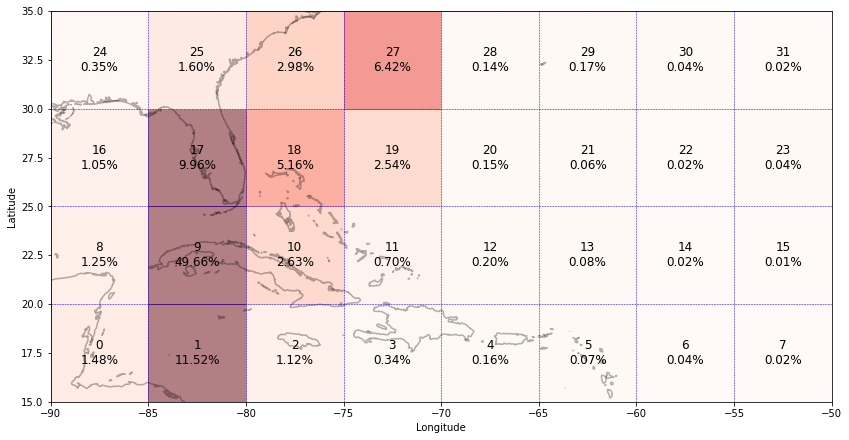

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

probability_mapping = {
    0: 0.014793, 1: 0.115158, 2: 0.011226, 3: 0.003373, 4: 0.001579, 5: 0.000742, 6: 0.000369, 7: 0.000224,
    8: 0.012473, 9: 0.496628, 10: 0.026334, 11: 0.007017, 12: 0.001978, 13: 0.000820, 14: 0.000220, 15: 0.000132,
    16: 0.010485, 17: 0.099641, 18: 0.051585, 19: 0.025354, 20: 0.001477, 21: 0.000559, 22: 0.000207, 23: 0.000420,
    24: 0.003482, 25: 0.015994, 26: 0.029833, 27: 0.064161, 28: 0.001357, 29: 0.001749, 30: 0.000409, 31: 0.000222
}

lat_range = (15, 35)
lon_range = (-90, -50)
lat_bins = 4
lon_bins = 8
total_bins = lat_bins * lon_bins

lat_bin_edges = np.linspace(lat_range[0], lat_range[1], lat_bins + 1)
lon_bin_edges = np.linspace(lon_range[0], lon_range[1], lon_bins + 1)
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline.plot(ax=ax, color='black', alpha=0.3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

# Plot grid lines
for lat in lat_bin_edges:
    plt.axhline(y=lat, color='blue', linestyle='--', linewidth=0.5)
for lon in lon_bin_edges:
    plt.axvline(x=lon, color='blue', linestyle='--', linewidth=0.5)

# Plot bin numbers and create heatmap
for i in range(lat_bins):
    for j in range(lon_bins):
        lat_center = (lat_bin_edges[i] + lat_bin_edges[i + 1]) / 2
        lon_center = (lon_bin_edges[j] + lon_bin_edges[j + 1]) / 2
        bin_number = i * lon_bins + j
        probability = probability_mapping[bin_number]
        
        # Convert probability to percentage
        probability_percentage = probability * 100
        
        # Plot the heatmap square with increased contrast
        plt.gca().add_patch(plt.Rectangle(
            (lon_bin_edges[j], lat_bin_edges[i]),
            lon_bin_edges[j + 1] - lon_bin_edges[j],
            lat_bin_edges[i + 1] - lat_bin_edges[i],
            color=plt.cm.Reds(probability * 10),  # Increase contrast by scaling the probability
            alpha=0.5
        ))
        
        # Plot the bin number and percentage with larger font size
        plt.text(lon_center, lat_center, f'{bin_number}\n{probability_percentage:.2f}%', color='black', ha='center', va='center', fontsize=12)

plt.show()

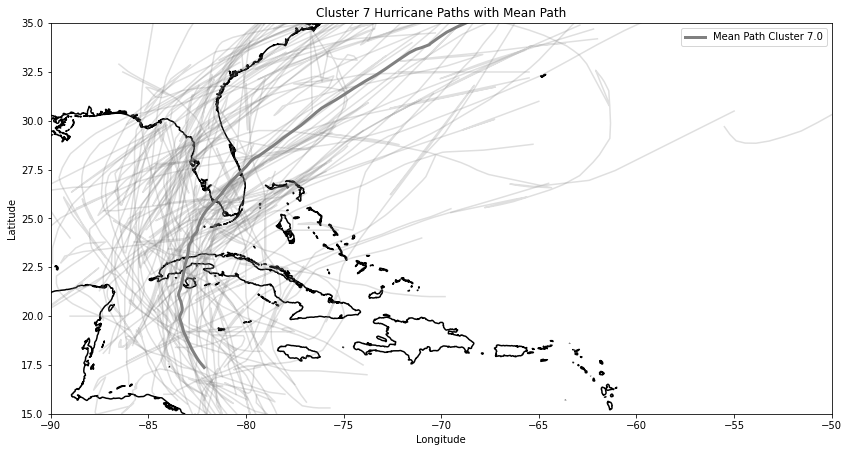

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import geopandas as gpd

# Load the hurricane data
hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')

# Filter paths for cluster 7
filtered_data = hurricane_data[hurricane_data['CLUSTER'] == 7]

# Function to preprocess paths for plotting
def preprocess_paths_for_plotting(storms):
    paths = []
    clusters = []
    for hid, group in storms:
        group = group.sort_values(by='DATE')
        latitudes = group['LATITUDE'].values
        longitudes = group['LONGITUDE'].values
        cluster = group['CLUSTER'].iloc[0]
        
        if len(latitudes) < 2:
            continue
        
        paths.append(np.array(list(zip(latitudes, longitudes))))
        clusters.append(cluster)
        
    return paths, np.array(clusters)

# Group the filtered data by 'HID' (Hurricane ID)
storms = filtered_data.groupby('HID')
paths, clusters = preprocess_paths_for_plotting(storms)

# Function to interpolate path
def interpolate_path(path, n_points=100):
    latitudes = path[:, 0]
    longitudes = path[:, 1]
    interp_lat = interp1d(np.linspace(0, 1, len(latitudes)), latitudes, kind='linear')
    interp_lon = interp1d(np.linspace(0, 1, len(longitudes)), longitudes, kind='linear')
    new_lat = interp_lat(np.linspace(0, 1, n_points))
    new_lon = interp_lon(np.linspace(0, 1, n_points))
    return np.column_stack((new_lat, new_lon))

# Function to plot paths and means
def plot_paths_and_means(paths, clusters, colors, title, ax, n_points=100):
    unique_clusters = np.unique(clusters)
    mean_paths = []
    
    for cluster in unique_clusters:
        cluster_paths = [interpolate_path(path, n_points) for path, cl in zip(paths, clusters) if cl == cluster]
        mean_path = np.mean(cluster_paths, axis=0)
        mean_paths.append(mean_path)
        
        for path in cluster_paths:
            ax.plot(path[:, 1], path[:, 0], color=colors[int(cluster) % len(colors)], alpha=0.25)
        ax.plot(mean_path[:, 1], mean_path[:, 0], color=colors[int(cluster) % len(colors)], linewidth=3, label=f'Mean Path Cluster {cluster}')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()

# Plotting
plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')
coastline.plot(ax=ax, color='black')

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

plot_paths_and_means(paths, clusters, colors, 'Cluster 7 Hurricane Paths with Mean Path', ax)

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

plt.show()

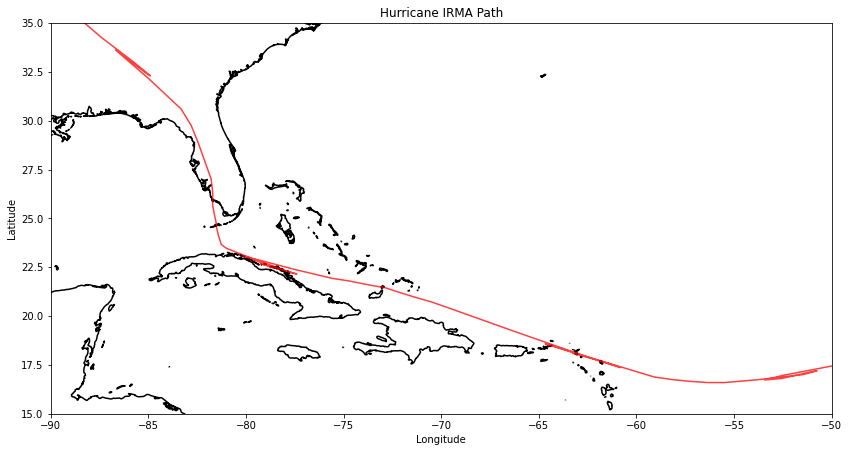

In [69]:
# Load the hurricane data
hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')

# Strip whitespace from the 'HNAME' column
hurricane_data['HNAME'] = hurricane_data['HNAME'].str.strip()

# Filter paths for the hurricane named IRMA
irma_data = hurricane_data[hurricane_data['HNAME'] == 'IRMA']

# Function to preprocess paths for plotting
def preprocess_paths_for_plotting(storms):
    paths = []
    for hid, group in storms:
        group = group.sort_values(by='DATE')
        latitudes = group['LATITUDE'].values
        longitudes = group['LONGITUDE'].values
        
        if len(latitudes) < 2:
            continue
        
        paths.append(np.array(list(zip(latitudes, longitudes))))
        
    return paths

# Group the filtered data by 'HID' (Hurricane ID)
irma_storms = irma_data.groupby('HID')
irma_paths = preprocess_paths_for_plotting(irma_storms)

# Function to interpolate path
def interpolate_path(path, n_points=100):
    latitudes = path[:, 0]
    longitudes = path[:, 1]
    interp_lat = interp1d(np.linspace(0, 1, len(latitudes)), latitudes, kind='linear')
    interp_lon = interp1d(np.linspace(0, 1, len(longitudes)), longitudes, kind='linear')
    new_lat = interp_lat(np.linspace(0, 1, n_points))
    new_lon = interp_lon(np.linspace(0, 1, n_points))
    return np.column_stack((new_lat, new_lon))

# Function to plot paths
def plot_paths(paths, color, title, ax, n_points=100):
    for path in paths:
        interpolated_path = interpolate_path(path, n_points)
        ax.plot(interpolated_path[:, 1], interpolated_path[:, 0], color=color, alpha=0.75)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

# Plotting
plt.figure(figsize=(14, 10))

ax = plt.gca()
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')
coastline.plot(ax=ax, color='black')  

# Define color for the specific hurricane path
irma_color = 'red'

# Plot the paths for hurricane IRMA
plot_paths(irma_paths, irma_color, 'Hurricane IRMA Path', ax)

greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

plt.show()

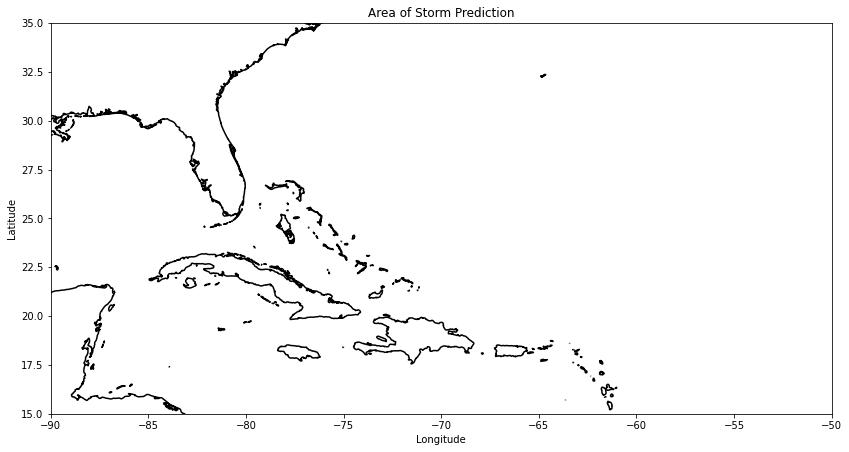

In [68]:
# Load the coastline shapefile
coastline = gpd.read_file('Coastline Files/ne_10m_coastline.shp')

# Plotting the coastline
plt.figure(figsize=(14, 10))
ax = plt.gca()
coastline.plot(ax=ax, color='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Define the range for latitude and longitude
greater_lat_range = (15, 35)
greater_lon_range = (-90, -50)
plt.xlim(greater_lon_range)
plt.ylim(greater_lat_range)

# Set the title
plt.title('Area of Storm Prediction')

plt.show()

In [73]:
hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')

# Strip whitespace from the 'HNAME' column
hurricane_data['HNAME'] = hurricane_data['HNAME'].str.strip()

# Print the min and max value in each category
category_min_max = hurricane_data.groupby('CATEGORY')['WINDSPEED_KT'].agg(['min', 'max'])
print("Min and Max value in each category:")
print(category_min_max)

# Filter data for IRMA
irma_data = hurricane_data[hurricane_data['HNAME'] == 'IRMA']

# Print all the WINDSPEED_KT values for IRMA
irma_windspeeds = irma_data['WINDSPEED_KT'].values
print("\nWINDSPEED_KT values for IRMA:")
print(irma_windspeeds)
print(irma_windspeeds.mean())

Min and Max value in each category:
           min    max
CATEGORY             
0          0.0   30.0
1         35.0   35.0
2         40.0   40.0
3         45.0   45.0
4         50.0   55.0
5         60.0   70.0
6         75.0   85.0
7         90.0  165.0

WINDSPEED_KT values for IRMA:
[ 30.  30.  30.  30.  30.  30.  30.  30.  40.  45.  45.  40.  40.  40.
  30.  35.  45.  50.  55.  65.  80.  95. 100. 100. 100. 100. 100. 100.
  95.  95.  95.  95. 100. 100. 100. 105. 110. 115. 125. 135. 150. 155.
 155. 155. 155. 155. 155. 155. 150. 150. 145. 145. 145. 140. 135. 135.
 135. 140. 145. 145. 130. 110.  95. 100. 115. 115. 115. 100. 100.  80.
  65.  50.  45.  35.  25.  20.  15.  15.  15.  15.]
89.0


# Daily Weather Data Processing

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import numpy as np
import pyarrow as pq
from sklearn.preprocessing import MinMaxScaler
import glob
from tqdm import tqdm
import concurrent.futures
from datetime import timedelta

In [1]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 43.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Loading Data

In [3]:

# Directory containing the weather data files
weather_data_directory = 'Weather/Open Meteo/Raw/'

# Get a list of all Parquet files in the directory
weather_files = glob.glob(f'{weather_data_directory}*.parquet')

# Reload the cleaned files
weather_data_list = []

for file in weather_files:
    df = pd.read_parquet(file)
    weather_data_list.append(df)

# Combine the data
weather_data = pd.concat(weather_data_list)
weather_data = weather_data.drop_duplicates(subset=['lat', 'lon', 'date'])
# Mapping of weather codes to new weather values
weather_code_mapping = {
    0.0: 0,
    1.0: 0,
    2.0: 0,
    3.0: 0,
    51.0: 1,
    53.0: 2,
    55.0: 3,
    61.0: 4,
    63.0: 5,
    65.0: 6,
    71.0: 4,
    73.0: 5,
    75.0: 6
}

# Apply the mapping to create the new 'weather' column
weather_data['weather'] = weather_data['weather_code'].map(weather_code_mapping)

# Drop the old 'weather_code' column
weather_data = weather_data.drop(columns=['weather_code'])
weather_data.fillna(0, inplace=True)

weather_data = weather_data.pivot_table(index=['date', 'lat', 'lon'], 
                                          values=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'weather'])

print(weather_data.head())


ValueError: ValueError: No objects to concatenate

In [6]:
# Load hurricane data
hurricane_data = pd.read_csv('Augmented_Hurricane_Data.csv')
hurricane_data['DATE'] = pd.to_datetime(hurricane_data['DATE'].astype(str), format='%Y-%m-%d')

# Define lat/lon range
florida_lat_range = (15, 35)
florida_lon_range = (-95, -50)

# Filter hurricanes within the lat/lon range
hurricane_data = hurricane_data[
    (hurricane_data['LATITUDE'] >= florida_lat_range[0]) &
    (hurricane_data['LATITUDE'] <= florida_lat_range[1]) &
    (hurricane_data['LONGITUDE'] >= florida_lon_range[0]) &
    (hurricane_data['LONGITUDE'] <= florida_lon_range[1])
]


min_day = min(weather_data.index.get_level_values('date'))+timedelta(days=121)
max_day = max(weather_data.index.get_level_values('date'))
hurricane_data['DATE'] = hurricane_data['DATE'].dt.tz_localize('UTC')

hurricane_data = hurricane_data[(hurricane_data['DATE']>=min_day)&(hurricane_data['DATE']<=max_day)]
hurricane_data = hurricane_data[hurricane_data['CLUSTER'] != -1]

In [7]:
weather_data['storm'] = 0
# Function to find the closest latitude and longitude
def find_closest_lat_lon(lat, lon, lat_values, lon_values):
    closest_lat = min(lat_values, key=lambda x: abs(x - lat))
    closest_lon = min(lon_values, key=lambda x: abs(x - lon))
    return closest_lat, closest_lon

# Function to update the storm column
def update_storm_column(weather_data, hurricane_data):
    lat_values = weather_data.index.get_level_values('lat').unique()
    lon_values = weather_data.index.get_level_values('lon').unique()
    
    for idx, row in hurricane_data.iterrows():
        hurricane_date = row['DATE']
        hurricane_lat = row['LATITUDE']
        hurricane_lon = row['LONGITUDE']
        wind_speed = row['WINDSPEED_KT']
        
        closest_lat, closest_lon = find_closest_lat_lon(hurricane_lat, hurricane_lon, lat_values, lon_values)
        
        weather_data.loc[(hurricane_date, closest_lat, closest_lon), 'storm'] = wind_speed
update_storm_column(weather_data, hurricane_data)

# Normalize weather data features
scaler = MinMaxScaler()
weather_variables = ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'weather', 'storm']
weather_data[weather_variables] = scaler.fit_transform(weather_data[weather_variables])


In [8]:
print(weather_data.describe())

       precipitation_sum  temperature_2m_max  temperature_2m_mean  \
count       1.315758e+07        1.315758e+07         1.315758e+07   
mean        6.516595e-03        6.670133e-01         7.560902e-01   
std         1.546522e-02        7.117655e-02         7.854374e-02   
min         0.000000e+00        0.000000e+00         0.000000e+00   
25%         0.000000e+00        6.343788e-01         7.275226e-01   
50%         1.137398e-03        6.800523e-01         7.785849e-01   
75%         5.686988e-03        7.096058e-01         8.078668e-01   
max         1.000000e+00        1.000000e+00         1.000000e+00   

       temperature_2m_min       weather  wind_direction_10m_dominant  \
count        1.315758e+07  1.315758e+07                 1.315758e+07   
mean         8.266495e-01  2.368223e-01                 3.972706e-01   
std          8.935820e-02  2.597965e-01                 2.829304e-01   
min          0.000000e+00  0.000000e+00                 0.000000e+00   
25%          7.988

### Weather Samples for Storm

In [9]:


# Assuming weather_data is already loaded and preprocessed
weather_grid_lat = weather_data.index.get_level_values('lat').unique()
weather_grid_lon = weather_data.index.get_level_values('lon').unique()
weather_times = pd.date_range(start='1940-05-01', end='2022-12-01', freq='MS')
weather_times = pd.to_datetime(weather_times).tz_localize('UTC')

# Define the sequence length
seq_length = 120

# Ensure weather_variables are defined
channels = len(weather_variables)
height = len(weather_grid_lat)
width = len(weather_grid_lon)

# Initialize weather_samples with the correct shape
num_samples = len(weather_times) - seq_length + 1

In [1]:
# Function to extract weather data
def extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    data_array = np.zeros((seq_length, channels, height, width))
    for i, date in enumerate(dates):
        daily_data = weather_data.loc[date]
        data_array[i] = daily_data.values.T.reshape(channels, height, width)
    return data_array

# Function to process each weather sample
def process_weather_sample(i, seq_length, weather_times, weather_data, channels, height, width):
    start_date = weather_times[i] - pd.Timedelta(days=seq_length)
    end_date = weather_times[i] - pd.Timedelta(days=1)
    sample = extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width)
    return sample

weather_samples = np.zeros((num_samples, seq_length, channels, height, width))

# Parallel processing of weather samples
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for i in tqdm(range(num_samples), desc="Submitting tasks for weather samples"):
        futures.append(executor.submit(process_weather_sample, i, seq_length, weather_times, weather_data, channels, height, width))
    
    for i, future in enumerate(tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results of weather samples")):
        weather_samples[i] = future.result()

print(weather_samples.shape)  # Should be (num_samples, seq_length, channels, height, width)

# Save the results to HDF5
hdf5_filename = 'Weather/Open Meteo/daily_weather_samples_storms.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('weather_samples_storms', data=weather_samples)

NameError: NameError: name 'np' is not defined

### Creating Path Samples

In [10]:


# Define the sequence length
seq_length = 120

# Ensure weather_variables are defined
channels = len(weather_variables)
weather_grid_lat = weather_data.index.get_level_values('lat').unique()
weather_grid_lon = weather_data.index.get_level_values('lon').unique()
height = len(weather_grid_lat)
width = len(weather_grid_lon)

In [146]:
print(hurricane_data.columns)

Index(['DATE', 'TIME_UTC', 'POINT_TYPE', 'STATUS', 'LATITUDE', 'LONGITUDE',
       'DIST_TO_COASTLINE', 'DIST_TO_LANDFALL', 'HU_LANDFALL', 'HID', 'HNAME',
       'WINDSPEED_KT', 'PRESSURE_MB', 'CATEGORY', 'NE_34KT', 'SE_34KT',
       'NW_34_KT', 'SW_34_KT', 'NE_50KT', 'SE_50KT', 'NW_50_KT', 'SW_50_KT',
       'NE_64KT', 'SE_64KT', 'NW_64_KT', 'SW_64_KT', 'RAD_MAX_WIND',
       'US_EAST_STORM', 'CLUSTER'],
      dtype='object')


In [13]:
import os
from multiprocessing import Manager
import zipfile

# Function to extract weather data
def extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    data_array = np.zeros((seq_length, channels, height, width))
    for i, date in enumerate(dates):
        daily_data = weather_data.loc[date]
        data_array[i] = daily_data.values.T.reshape(channels, height, width)
    return data_array
# Function to process each hurricane with caching
def process_hurricane(row, seq_length, channels, height, width, weather_data, cache):
    hurricane_date = row['DATE']

    end_date = (hurricane_date - pd.DateOffset(days=hurricane_date.day))
    start_date = end_date - pd.Timedelta(days=seq_length-1)
    
    # Check if the current dates match the cached dates
    cache_key = (start_date, end_date)
    if cache_key in cache:
        sample = cache[cache_key]
    else:
        # Extract new weather data
        sample = extract_weather_data(weather_data, start_date, end_date, seq_length, channels, height, width)
        # Update cache
        cache[cache_key] = sample
    
    return sample

def process_hurricanes_with_cache(hurricane_data, seq_length, channels, height, width, weather_data, start_idx, end_idx):
    # Function to manage caching and processing
    weather_samples = []

    with Manager() as manager:
        cache = manager.dict()

        with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
            futures = []
            for idx, row in tqdm(hurricane_data.iloc[start_idx:end_idx].iterrows(), total=end_idx-start_idx, desc="Submitting tasks"):
                futures.append(executor.submit(process_hurricane, row, seq_length, channels, height, width, weather_data, cache))

            for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results"):
                sample = future.result()
                weather_samples.append(sample)

    weather_samples = np.array(weather_samples)
    return weather_samples

num_chunks = 100
chunk_size = len(hurricane_data) // num_chunks

for i in range(95, 100):
    print(f'Processing chunk: {1+i}')
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i < num_chunks - 1 else len(hurricane_data)

    weather_samples = process_hurricanes_with_cache(hurricane_data, seq_length, channels, height, width, weather_data, start_idx, end_idx)

    print(weather_samples.shape)  # Should be (num_samples, seq_length, channels, height, width)

    hdf5_filename = f'daily_weather_samples_chunk_{i + 1}.h5'
    zip_filename = f'Weather/Open Meteo/Daily/Weather Samples/daily_weather_samples_chunk_{i + 1}.zip'
    
    with h5py.File(hdf5_filename, 'w') as f:
        f.create_dataset('weather_samples', data=weather_samples)
    
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        zipf.write(hdf5_filename, arcname=hdf5_filename)
    
    print(f'Saved file to location: {zip_filename}')

    os.remove(hdf5_filename)

Processing chunk: 96
(99, 120, 8, 14, 31)
Saved file to location: Weather/Open Meteo/Daily/Weather Samples/daily_weather_samples_chunk_96.zip
Processing chunk: 97
(99, 120, 8, 14, 31)
Saved file to location: Weather/Open Meteo/Daily/Weather Samples/daily_weather_samples_chunk_97.zip
Processing chunk: 98
(99, 120, 8, 14, 31)
Saved file to location: Weather/Open Meteo/Daily/Weather Samples/daily_weather_samples_chunk_98.zip
Processing chunk: 99
(99, 120, 8, 14, 31)
Saved file to location: Weather/Open Meteo/Daily/Weather Samples/daily_weather_samples_chunk_99.zip
Processing chunk: 100
(176, 120, 8, 14, 31)
Saved file to location: Weather/Open Meteo/Daily/Weather Samples/daily_weather_samples_chunk_100.zip


Processing results: 100%|██████████| 176/176 [05:53<00:00,  2.01s/it]


In [135]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))



Total: 47 GiB
Used: 11 GiB
Free: 36 GiB


In [1]:
!pip install PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.2/229.2 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 10.9 MB/s eta 0:00:00
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=3ecd9d6ac24c07885cf8019974d965200d5b907e878585c28e54e422b4408eb0
  Stored in directory: /home/datalore/.cache/pip/wheels/c6/14/12/ccdcc5d3b41661f360f9c7d9f7ea9d1879a5f85aa4ecc8cc6f
Successfully built PyDrive

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip inst

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# Authenticate and create the PyDrive client
gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Opens a local server for authentication
drive = GoogleDrive(gauth)

# List files in your Google Drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file in file_list:
    print('title: %s, id: %s' % (file['title'], file['id']))

InvalidConfigError: InvalidConfigError: Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)

In [137]:
import subprocess
def get_disk_usage():
    result = subprocess.run(['du', '-h', '--max-depth=3', '/'], stdout=subprocess.PIPE, text=True)
    print(result.stdout)

get_disk_usage()

0	/boot
0	/dev/vfio
0	/dev/snd
0	/dev/net
0	/dev/mapper
0	/dev/input
0	/dev/dma_heap
0	/dev/cpu/1
0	/dev/cpu/0
0	/dev/cpu
0	/dev/shm
0	/dev/mqueue
0	/dev/pts
0	/dev
8.0K	/etc/alternatives
48K	/etc/apt/apt.conf.d
0	/etc/apt/auth.conf.d
0	/etc/apt/keyrings
0	/etc/apt/preferences.d
4.0K	/etc/apt/sources.list.d
12K	/etc/apt/trusted.gpg.d
68K	/etc/apt
4.0K	/etc/cloud
4.0K	/etc/cron.d
8.0K	/etc/cron.daily
20K	/etc/default
8.0K	/etc/dpkg/dpkg.cfg.d
8.0K	/etc/dpkg/origins
20K	/etc/dpkg
0	/etc/gss/mech.d
0	/etc/gss
16K	/etc/init.d
4.0K	/etc/kernel/postinst.d
0	/etc/kernel/install.d
4.0K	/etc/kernel
8.0K	/etc/ld.so.conf.d
16K	/etc/logrotate.d
0	/etc/opt
80K	/etc/pam.d
4.0K	/etc/profile.d
0	/etc/rc0.d
0	/etc/rc1.d
0	/etc/rc2.d
0	/etc/rc3.d
0	/etc/rc4.d
0	/etc/rc5.d
0	/etc/rc6.d
0	/etc/rcS.d
0	/etc/security/limits.d
0	/etc/security/namespace.d
44K	/etc/security
4.0K	/etc/selinux
12K	/etc/skel
32K	/etc/sysctl.d
4.0K	/etc/systemd/system
0	/etc/systemd/user
0	/etc/systemd/network
44K	/etc/systemd
4.0

In [157]:
import os
lost_found_dir = '/data/notebook_files/lost+found'

# Check if the directory exists
if os.path.exists(lost_found_dir):
    # List contents
    print(f"Contents of {lost_found_dir}:")
    for root, dirs, files in os.walk(lost_found_dir):
        for name in files:
            print(os.path.join(root, name))
        for name in dirs:
            print(os.path.join(root, name))

Contents of /data/notebook_files/lost+found:
/data/notebook_files/lost+found/daily_weather_samples_chunk_58.zip-KWjUPG
/data/notebook_files/lost+found/daily_weather_samples_chunk_57.zip-kXjFsn
/data/notebook_files/lost+found/daily_weather_samples_chunk_56.zip-H1XOMc
/data/notebook_files/lost+found/daily_weather_samples_chunk_55.zip-LbABn8
/data/notebook_files/lost+found/daily_weather_samples_chunk_54.zip-pdyU8i
/data/notebook_files/lost+found/daily_weather_samples_chunk_53.zip-8hDHOv
/data/notebook_files/lost+found/daily_weather_samples_chunk_52.zip-KvJAyc
/data/notebook_files/lost+found/daily_weather_samples_chunk_51.zip-7uAQ8b
/data/notebook_files/lost+found/daily_weather_samples_chunk_50.zip-Ujz1jl
/data/notebook_files/lost+found/daily_weather_samples_chunk_49.zip-H3hwv2
/data/notebook_files/lost+found/daily_weather_samples_chunk_48.zip-4IUFLu
/data/notebook_files/lost+found/daily_weather_samples_chunk_47.zip-qEb4Xy
/data/notebook_files/lost+found/daily_weather_samples_chunk_46.zip-

In [158]:
import os
import zipfile

lost_found_dir = '/data/notebook_files/lost+found'
zip_filename = '/data/notebook_files/lost_and_found.zip'

# Create a zip file directly
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(lost_found_dir):
        for file in files:
            file_path = os.path.join(root, file)
            print(file_path)
            arcname = os.path.relpath(file_path, lost_found_dir)
            zipf.write(file_path, arcname)

print(f"Compressed lost+found directory to {zip_filename}")

/data/notebook_files/lost+found/daily_weather_samples_chunk_58.zip-KWjUPG
/data/notebook_files/lost+found/daily_weather_samples_chunk_57.zip-kXjFsn
/data/notebook_files/lost+found/daily_weather_samples_chunk_56.zip-H1XOMc
/data/notebook_files/lost+found/daily_weather_samples_chunk_55.zip-LbABn8
/data/notebook_files/lost+found/daily_weather_samples_chunk_54.zip-pdyU8i
/data/notebook_files/lost+found/daily_weather_samples_chunk_53.zip-8hDHOv
/data/notebook_files/lost+found/daily_weather_samples_chunk_52.zip-KvJAyc
/data/notebook_files/lost+found/daily_weather_samples_chunk_51.zip-7uAQ8b
/data/notebook_files/lost+found/daily_weather_samples_chunk_50.zip-Ujz1jl
/data/notebook_files/lost+found/daily_weather_samples_chunk_49.zip-H3hwv2
/data/notebook_files/lost+found/daily_weather_samples_chunk_48.zip-4IUFLu
/data/notebook_files/lost+found/daily_weather_samples_chunk_47.zip-qEb4Xy
/data/notebook_files/lost+found/daily_weather_samples_chunk_46.zip-JQm1WL
/data/notebook_files/lost+found/daily_

In [19]:
hdf5_filename = f'daily_weather_samples_paths_test.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('weather_samples_paths', data=weather_samples)
print(f'Saved file to location: {hdf5_filename}')

Saved file to location: daily_weather_samples_paths_test.h5


In [9]:
import h5py
with h5py.File('Weather/Open Meteo/Daily/daily_weather_samples_paths_chunk_1.h5', 'r') as f:
    weather_samples_test = f['weather_samples_paths'][:]
    
weather_samples_test.shape

(9, 120, 8, 14, 31)

In [14]:
# Function to extract weather data
# Function to process each hurricane with caching
def process_hurricane(row):
    hurricane_date = row['DATE']
    hurricane_cluster = row['CLUSTER']
    hurricane_lat = row['LATITUDE']
    hurricane_lon = row['LONGITUDE']
    hurricane_category = row['CATEGORY']
    hurricane_windspeed = row['WINDSPEED_KT']

    return hurricane_cluster, hurricane_lat, hurricane_lon, hurricane_category, hurricane_windspeed

# Function to manage caching and processing
hurricane_labels_paths = []
hurricane_labels_category = []
hurricane_labels_latlon = []
hurricane_labels_windspeed = []


with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    futures = []
    for idx, row in tqdm(hurricane_data.iterrows(), total=hurricane_data.shape[0], desc="Submitting tasks"):
        futures.append(executor.submit(process_hurricane, row))
    
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing results"):
        cluster, lat, lon, category, windspeed = future.result()
        hurricane_labels_paths.append(cluster)
        hurricane_labels_category.append(category)
        hurricane_labels_latlon.append([lat, lon])
        hurricane_labels_windspeed.append(windspeed)

hurricane_labels_paths = np.array(hurricane_labels_paths)
hurricane_labels_category = np.array(hurricane_labels_category)
hurricane_labels_latlon = np.array(hurricane_labels_latlon)
hurricane_labels_windspeed = np.array(hurricane_labels_windspeed)


print(hurricane_labels_paths.shape)
print(hurricane_labels_latlon.shape)
print(hurricane_labels_windspeed.shape)
print(hurricane_labels_category.shape)


hdf5_filename = 'Weather/Open Meteo/Daily/daily_hurricane_labels_paths.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('hurricane_labels_paths', data=hurricane_labels_paths)
hdf5_filename = 'Weather/Open Meteo/Daily/daily_hurricane_labels_category.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('hurricane_labels_category', data=hurricane_labels_category)
hdf5_filename = 'Weather/Open Meteo/Daily/daily_hurricane_labels_latlon.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('hurricane_labels_latlon', data=hurricane_labels_latlon)
hdf5_filename = 'Weather/Open Meteo/Daily/daily_hurricane_labels_windspeed.h5'
with h5py.File(hdf5_filename, 'w') as f:
    f.create_dataset('hurricane_labels_windspeed', data=hurricane_labels_windspeed)

(9977,)
(9977, 2)
(9977,)
(9977,)


Processing results: 100%|██████████| 9977/9977 [00:04<00:00, 2186.91it/s]
